# Data Analysis of MESOCOSM 

In [1]:
import os
from typing import List, Optional

from tqdm.notebook import tqdm

import numpy as np
import math
import pandas as pd
from scipy import stats
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

plt.rcParams['font.family'] = 'Arial Unicode MS'

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import statsmodels.api as sm
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


# PATH to the data directory
DATA_PATH = os.path.join(os.getcwd(), "data")

## 0. Loading the data

### 0.1 ```MesocosmExperimentData```

In [2]:
# Soil data
soil_data = pd.read_excel(
    os.path.join(DATA_PATH, "MesocosmExperimentData.xlsx"), 
    sheet_name="SoilData", 
    na_values="***"
    )

# reformat of ID
mask = soil_data["ID"].notna()
soil_data.loc[mask, "ID"] = (
    soil_data.loc[mask, "ID"]
    .astype(str)
    .str.replace(r"[（(].*$", "", regex=True)
    .str.strip()
)


# Species composition data
species_composition = pd.read_excel(
    os.path.join(DATA_PATH, "MesocosmExperimentData.xlsx"),
    sheet_name="SpeciesComposition",
    index_col=0, 
    )

## remove non used line from excel 
species_composition = species_composition[~species_composition.index.isna()]

# renaming the columns 
new_names = ["A-P", "I-T", "P-NoP", "Tuber", "Fruit"]
species_composition.columns.values[4:9] = new_names

# converting the data types to int and str
int_columns = ["Tea Tree", "#Species", "Tuber", "Fruit"]
for col in species_composition.columns:
    if col in int_columns:
        species_composition[col] = species_composition[col].fillna(0).astype(int)
    else :
        species_composition[col] = species_composition[col].astype(str)

# splitting the species names into list and finishing the species names
species_composition["Species"] = species_composition["Species"].apply(
    lambda x: [w.strip() for w in x.split(',')]
)

# merging both dataframes based on "Category"ArithmeticError
# Ensure df2 index is used properly
sc_subset = species_composition[["Tea Tree", "#Species", "Species"]]
soil_data = soil_data.merge(
    sc_subset,
    left_on="Category",
    right_index=True,
    how="left"
    )
soil_data["Latin Square"] = [id[0] for id in soil_data["ID"]]
soil_data.set_index("ID", inplace=True)
soil_data

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/2428676909.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  species_composition[col] = species_composition[col].fillna(0).astype(int)
/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/2428676909.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  species_composition[col] = species_composition[col].fillna(0).astype(int)


BIOTREX_NO       Date  SD_of_BIOTREX  BIOTREX Category  Fertilizer  \
ID                                                                          
A1-1        42811 2023-12-01           44.6   586445       x1        True   
A1-2        42812 2023-12-01           55.7   990077       a1        True   
A1-3        42813 2023-12-01           67.6  1421889       a2        True   
A1-4        42814 2023-12-01           59.0  1108531       b1        True   
A1-5        42815 2023-12-01           64.5  1308377       b2        True   
...           ...        ...            ...      ...      ...         ...   
B5-11       60640 2023-12-01           48.2   717259       c5       False   
B5-12       60641 2023-12-01           58.6  1094621       d2       False   
B5-13       60642 2023-12-01           39.2   391696       x2       False   
B5-14       60643 2023-12-01           75.6  1710008       a7       False   
B5-15       60644 2023-12-01           59.1  1113297       a8       False   

       EC　電気伝導率 (dS/m)  (1:5)  pH (H2O)  (1:2.5)  pH (KCl)  (1:2.5)  \
ID                                                                    
A1-1                     1.36               5.00               4.83   
A1-2                     1.66               5.02               4.81   
A1-3                     0.91               5.45               5.17   
A1-4                     1.07               5.01               4.86   
A1-5                     1.17               5.00               4.82   
...                       ...                ...                ...   
B5-11                    0.07               6.24               5.56   
B5-12                    0.08               6.18               5.55   
B5-13                    0.07               6.23               5.55   
B5-14                    0.07               6.33               5.59   
B5-15                    0.08               6.18               5.56   

      NH4-N　アンモニア態窒素 (mg/100g)  ... 塩基飽和度 (%)  Ca/Mg　石灰苦土比  Mg/K　苦土加里比  \
ID                              ...                                      
A1-1                       0.9  ...        38          3.1         1.6   
A1-2                       1.1  ...        43          3.9         1.2   
A1-3                      26.5  ...        35          2.9         1.9   
A1-4                       0.7  ...        32          2.8         1.8   
A1-5                       0.7  ...        33          2.6         1.6   
...                        ...  ...       ...          ...         ...   
B5-11                      0.4  ...        23          2.1        12.0   
B5-12                      0.4  ...        24          2.3         8.9   
B5-13                      0.6  ...        22          2.2         9.7   
B5-14                      0.2  ...        25          2.2         3.7   
B5-15                      0.2  ...        24          2.2         8.0   

       P-abc　リン酸吸収係数  SiO2　可吸態ケイ酸 (mg/100g)  Fe2O3　遊離酸化鉄 (%)  Tea Tree  \
ID                                                                       
A1-1             NaN                    NaN              NaN         0   
A1-2             NaN                    NaN              NaN         1   
A1-3             NaN                    NaN              NaN         1   
A1-4             NaN                    NaN              NaN         1   
A1-5             NaN                    NaN              NaN         1   
...              ...                    ...              ...       ...   
B5-11            NaN                    NaN              NaN         1   
B5-12            NaN                    NaN              NaN         1   
B5-13            NaN                    NaN              NaN         1   
B5-14            NaN                    NaN              NaN         1   
B5-15            NaN                    NaN              NaN         1   

       #Species                                            Species  \
ID                                                                   
A1-1          0

### 0.2 ```MesocosmExperimentData_Metabolome```

In [3]:
# Metabolome info 
metabolome_info_data = pd.read_excel(
    os.path.join(DATA_PATH, "MesocosmExperimentData_Metabolome.xlsx"),
    sheet_name="Sample Info",
    index_col=0,
).iloc[:-4,:]

# Metabolome composition
metabolome_compound_data = pd.read_excel(
    os.path.join(DATA_PATH, "MesocosmExperimentData_Metabolome.xlsx"),
    sheet_name="Compounds",
    na_values="**",
)

cols_to_drop = [
    "Metabolite Name\n(Click to View Detail)", "Annot. Delta\nMass (ppm)",
       "mzCloud\nResults", "mzCloud\nBest Match", "Fold Change\n[B]/[A]",
       "p-Value\nWelch's t-Test", "Significance", "Graph", "R.T.\n(min)",
       "M.W.", "Formula"
]

metabolome_compound_data.drop(columns= cols_to_drop, inplace = True)
# metabolome_compound_data = metabolome_compound_data.iloc[:, metabolome_compound_data.columns.get_loc("Formula"):]
metabolome_compound_data.columns = metabolome_compound_data.columns.str.replace(r'\n\[[A-Z]\]', '', regex=True)
metabolome_compound_data.set_index("No.", inplace=True)
metabolome_compound_data = metabolome_compound_data.T
metabolome_compound_data["Fertilizer"] = metabolome_info_data["Group"].replace({'F' : True, 'N' : False})
metabolome_compound_data["Latin Square"] = metabolome_info_data["Latin Square"]
metabolome_compound_data["Category"] = [s[:-1] for s in metabolome_compound_data.index[:26]] + \
                                        [s[-2:] for s in metabolome_compound_data.index[26:35]] + \
                                        [s[:-1] for s in metabolome_compound_data.index[35:61]] + \
                                        [s[-2:] for s in metabolome_compound_data.index[61:]] 
blank_data = metabolome_compound_data.iloc[-1,:]
metabolome_compound_data = metabolome_compound_data.iloc[:-1,:]

metabolome_compound_data

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Sparkline Group extension is not supported and will be removed
  warn(msg)


No.                 38            22            21          2599  \
a1F       1.819492e+07  5.691000e+06  3.135071e+07  5.167002e+07   
a2F       1.472600e+07  4.852423e+06  3.508723e+07  3.629909e+07   
a3F       1.530090e+07  4.093936e+06  3.594607e+07  4.561861e+07   
a4F       1.685195e+07  4.243987e+06  2.769493e+07  6.103472e+07   
a5F       1.399835e+07  4.116599e+06  3.089885e+07  3.381104e+07   
...                ...           ...           ...           ...   
5_12_Bd2  3.048506e+07  1.005040e+07  1.196159e+06  9.489892e+07   
6_13_Bd2  2.994040e+07  1.348366e+07  1.524412e+05  7.398111e+07   
4_4_Ax2   2.880299e+07  1.454571e+07  2.517492e+05  8.002726e+07   
6_6_Ax2   1.272122e+06  2.075744e+06  1.104255e+05  3.960425e+06   
5_13_Bx2  5.451360e+05  5.979525e+06  4.813817e+05  7.497024e+06   

No.                 24            25            16            20  \
a1F       8.340390e+06  1.736485e+06  3.632571e+09  5.547914e+07   
a2F       6.156934e+06  1.322739e+06  4.130262e+09  7.205907e+07   
a3F       4.592040e+06  8.542351e+05  5.002559e+09  7.325691e+07   
a4F       6.451235e+06  1.251585e+06  3.694623e+09  6.156260e+07   
a5F       5.592117e+06  9.570642e+05  4.694710e+09  7.704005e+07   
...                ...           ...           ...           ...   
5_12_Bd2  1.486958e+07  4.064821e+06  1.515328e+08  2.207693e+06   
6_13_Bd2  1.924918e+07  5.526130e+06  9.962925e+06  2.750354e+05   
4_4_Ax2   1.679718e+07  4.438813e+06  2.868248e+07  5.024621e+05   
6_6_Ax2   2.859056e+06  1.165740e+06  2.551345e+06  1.405134e+07   
5_13_Bx2  7.693071e+06  6.575458e+05  7.489766e+06  1.873284e+07   

No.               2670           946  ...          1082          2537  \
a1F       3.357707e+06  5.268186e+06  ...  5.918106e+06  5.993645e+06   
a2F       2.691354e+06  5.310311e+06  ...  4.338608e+06  3.471525e+06   
a3F       2.840462e+06  4.858087e+06  ...  1.536054e+06  3.159151e+06   
a4F       4.351368e+06  3.796347e+06  ...  5.991961e+06  3.149223e+06   
a5F       2.899187e+06  4.820068e+06  ...  4.025905e+06  2.976764e+06   
...                ...           ...  ...           ...           ...   
5_12_Bd2  1.110554e+07  7.373136e+05  ...  6.394191e+06  4.143620e+06   
6_13_Bd2  5.991928e+06  4.120468e+05  ...  2.474162e+06  5.217029e+06   
4_4_Ax2   6.409451e+06  4.182821e+05  ...  5.771488e+06  5.677586e+06   
6_6_Ax2   9.994184e+06  3.225565e+06  ...  3.875225e+04  5.103928e+04   
5_13_Bx2  1.040495e+07  2.728806e+06  ...  4.444547e+04  7.724835e+04   

No.                337          1515          3681          2701  \
a1F       5.363509e+06  2.190729e+08  1.184997e+07  5.328642e+06   
a2F       5.372764e+06  1.835851e+08  1.469548e+07  5.717654e+06   
a3F       4.815516e+06  2.008288e+08  2.367954e+06  5.203543e+06   
a4F       4.982791e+06  1.492457e+08  1.091379e+07  4.495264e+06   
a5F       5.357867e+06  2.210033e+08  9.516162e+06  5.367435e+06   
...                ...           ...           ...           ...   
5_12_Bd2  4.377307e+06  1.658280e+08  1.580969e+07  4.267486e+06   
6_13_Bd2  6.566686e+06  2.280996e+08  1.982747e+07  4.551793e+06   
4_4_Ax2   7.429381e+06  1.772276e+08  2.155933e+06  6.297021e+06   
6_6_Ax2   5.449229e+04  4.204647e+06  4.701888e+04  9.392362e+06   
5_13_Bx2  5.134115e+04  5.019314e+06  4.548908e+04  2.267456e+06   

No.               3243  Fertilizer  Latin Square  Category  
a1F       2.860464e+06        True             A        a1  
a2F       2.765273e+06        True             A        a2  
a3F       2.777435e+06        True             A        a3  
a4F       2.828875e+06        True             A        a4  
a5F       2.483267e+06        True             B        a5  
...                ...         ...           ...       ...  
5_12_Bd2  3.086597e+06       False             B        d2  
6_13_Bd2  2.799877e+06       False             B        d2  
4_4_Ax2   3.310004e+06       False             A        x2  
6_6_Ax2   3.630796e+06       False             A        x2  
5

### 0.3 `Mesocosm_3D_data`

In [4]:
mesocosm_3D_df = pd.read_excel(
    os.path.join(DATA_PATH, 'table_dataset240724.xlsx'),
    sheet_name='table_dataset240724',
    index_col=0)

# dropping NA columns
mesocosm_3D_df.dropna(axis=1, how='all', inplace=True)

# extracting the feature names
features_3D = mesocosm_3D_df.columns.tolist()

### 0.4 `MetagenomeData`

In [5]:
# Shannon index data
metagenomeData_Shannon = pd.read_excel(
    os.path.join(DATA_PATH, "MetagenomeData_Shannon_Index.xlsx"),
    index_col=0
)[:-14]
metagenomeData_Shannon = metagenomeData_Shannon.rename(
    lambda c : c if c == metagenomeData_Shannon.columns[0] else f"Shannon_{c}",
    axis=1
)
SHANNON_COL = metagenomeData_Shannon.columns.to_list()[1:]

# Simpson index data
metagenomeData_Simpson = pd.read_excel(
    os.path.join(DATA_PATH, "MetagenomeData_Simpson_Index.xlsx"),
    index_col=0
)[:-14]
metagenomeData_Simpson = metagenomeData_Simpson.rename(
    lambda c : c if c == metagenomeData_Simpson.columns[0] else f"Simpson_{c}",
    axis=1
)
SIMPSON_COL = metagenomeData_Simpson.columns.to_list()[1:]

# Species richness data
metagenomeData_Richness = pd.read_excel(
    os.path.join(DATA_PATH, "MetagenomeData_SpeciesRichness.xlsx"),
    index_col=0
)[:-14]
metagenomeData_Richness = metagenomeData_Richness.rename(
    lambda c : c if c == metagenomeData_Richness.columns[0] else f"Richness_{c}",
    axis=1
)
RICHNESS_COL = metagenomeData_Richness.columns.to_list()[1:]


# Combine all diversity indices into a single DataFrame
metagenomeData_df = pd.concat(
    [
        metagenomeData_Shannon,
        metagenomeData_Simpson.iloc[:, 1:],   # drop duplicate first column
        metagenomeData_Richness.iloc[:, 1:]   # drop duplicate first column
    ],
    axis=1
)

metagenomeData_df

Primer  Shannon_m_0.6  Shannon_SC_0.6  Shannon_qD_0.6  \
Sample                                                         
A1-1      18S       2.250125        0.600001        1.671635   
A1-1       V4     125.286472        0.600000       65.436969   
A1-10      V4     169.956622        0.600000       75.606200   
A1-11      V4     110.656167        0.600000       49.708627   
A1-12     18S       1.507532        0.599997        1.216143   
...       ...            ...             ...             ...   
B6-8     ITS1       9.619405        0.599999        5.692287   
B6-8       V4     475.903092        0.600000      259.328437   
B6-9      18S       1.000000        0.738235        1.000000   
B6-9     ITS1       2.777388        0.600001        1.878232   
B6-9       V4      64.557930        0.600000       29.469647   

        Shannon_qD.LCL_0.6  Shannon_qD.UCL_0.6  Shannon_m_0.7  Shannon_SC_0.7  \
Sample                                                                          
A1-1              1.658962            1.684308       2.985315        0.700002   
A1-1             64.888315           65.985623     185.675565        0.700000   
A1-10            74.442435           76.769964     268.586797        0.700000   
A1-11            48.894252           50.523002     168.156335        0.700000   
A1-12             1.189443            1.242843       2.333013        0.700000   
...                    ...                 ...            ...             ...   
B6-8              5.618104            5.766469      13.587852        0.700000   
B6-8            257.374762          261.282113     670.013678        0.700000   
B6-9              1.000000            1.000000       1.000000        0.738235   
B6-9              0.000000            3.957708       4.406239        0.699999   
B6-9             29.095077           29.844218      95.618000        0.700000   

        Shannon_qD_0.7  Shannon_qD.LCL_0.7  ...  Richness_m_0.95  \
Sample                                      ...                    
A1-1          1.936184            1.919331  ...         8.155739   
A1-1         79.067769           78.464138  ...       780.229755   
A1-10        93.381891           92.082796  ...      1184.663601   
A1-11        60.447622           59.531124  ...       743.924853   
A1-12         1.505933            1.474392  ...        18.772145   
...                ...                 ...  ...              ...   
B6-8          6.738659            6.656466  ...        57.785997   
B6-8        306.886520          304.743507  ...      2406.612128   
B6-9          1.000000            1.000000  ...        31.562514   
B6-9          2.323346            0.647346  ...        27.429639   
B6-9         35.450941           35.024597  ...       408.324469   

        Richness_SC_0.95  Richness_qD_0.95  Richness_qD.LCL_0.95  \
Sample                                                             
A1-1                0.95          2.926070              2.895989   
A1-1                0.95        174.129547            173.211804   
A1-10               0.95        251.107738            249.687959   
A1-11               0.95        157.937872            156.956988   
A1-12               0.95          3.771151              3.703991   
...                  ...               ...                   ...   
B6-8                0.95         13.317760             13.179605   
B6-8                0.95        591.534903            589.615940   
B6-9                0.95          3.781346              2.141249   
B6-9                0.95          5.591115              2.794164   
B6-9                0.95         88.686621             88.243756   

        Richness_qD.UCL_0.95  Richness_m_0.99  Richness_SC_0.99  \
Sample                                                            
A1-1                2.956152        17.731528              0.99   
A1-1              175.047289      1835.168109              0.99   
A1-10             252.527518      2710.097101              0.99   
A1-11          

### 0.5 Full Merging in `mesocosm_df`

In [6]:
compound_data_geolocated_index = ['1_9_Ad1', '2_10_Ad1',
       '3_11_Ad1', '1_8_Bd2', '2_9_Bd2', '3_10_Bd2', '2_2_Ax2', '1_9_Bx2',
       '3_11_Bx2', '4_12_Ad1', '5_13_Ad1', '6_14_Ad1', '4_11_Bd2', '5_12_Bd2', 
       '6_13_Bd2', '4_4_Ax2','6_6_Ax2', '5_13_Bx2'
       ]

index_of_interest = []
for s in compound_data_geolocated_index:
    sp = s.split("_")
    index_of_interest.append(f"{sp[2][0]}{sp[0]}-{sp[1]}")

# Subset the second dataframe (metabolome)
metab_subset = metabolome_compound_data.loc[compound_data_geolocated_index].copy()

# Rename its index to match soil_data if needed
metab_subset.index = index_of_interest  # make sure indices correspond to soil_data

# Drop columns that already exist in the first dataframe
metab_features = metab_subset.drop(columns=["Fertilizer", "Latin Square", "Category"], errors="ignore")
features = metab_features.columns

# Reindex to the full soil_data index — this fills missing rows with NaN
metab_aligned = metab_features.reindex(soil_data.index)

mesocosm_df = pd.concat([soil_data, metab_aligned], axis=1)

KEYS = ["Fertilizer", "Latin Square", "Category"]

features = metabolome_compound_data.drop(columns=KEYS).columns

for i in mesocosm_df.drop(index=index_of_interest).index:
    fertil, latin_square, cat = mesocosm_df.loc[i, KEYS]
    filter = (
        (metabolome_compound_data["Fertilizer"] == fertil) &
        (metabolome_compound_data["Latin Square"] == latin_square) &
        (metabolome_compound_data["Category"] == cat)
    )
    mesocosm_df.loc[i, features] = metabolome_compound_data.loc[
        filter, features].mean(numeric_only=True).values

mesocosm_df.loc[mesocosm_df["Category"] == "x1", features] = np.repeat(blank_data[features].values.reshape(1, -1),
                                                                   mesocosm_df[mesocosm_df["Category"] == "x1"][features].shape[0] , 
                                                                   axis=0)
mesocosm_df.drop(columns=["Date", "BIOTREX_NO"], inplace=True)

# Adding 3D data 
mesocosm_df[features_3D] = mesocosm_3D_df[features_3D]
mesocosm_df

SD_of_BIOTREX  BIOTREX Category  Fertilizer  EC　電気伝導率 (dS/m)  (1:5)  \
ID                                                                           
A1-1            44.6   586445       x1        True                    1.36   
A1-2            55.7   990077       a1        True                    1.66   
A1-3            67.6  1421889       a2        True                    0.91   
A1-4            59.0  1108531       b1        True                    1.07   
A1-5            64.5  1308377       b2        True                    1.17   
...              ...      ...      ...         ...                     ...   
B5-11           48.2   717259       c5       False                    0.07   
B5-12           58.6  1094621       d2       False                    0.08   
B5-13           39.2   391696       x2       False                    0.07   
B5-14           75.6  1710008       a7       False                    0.07   
B5-15           59.1  1113297       a8       False                    0.08   

       pH (H2O)  (1:2.5)  pH (KCl)  (1:2.5) NH4-N　アンモニア態窒素 (mg/100g)  \
ID                                                                     
A1-1                5.00               4.83                      0.9   
A1-2                5.02               4.81                      1.1   
A1-3                5.45               5.17                     26.5   
A1-4                5.01               4.86                      0.7   
A1-5                5.00               4.82                      0.7   
...                  ...                ...                      ...   
B5-11               6.24               5.56                      0.4   
B5-12               6.18               5.55                      0.4   
B5-13               6.23               5.55                      0.6   
B5-14               6.33               5.59                      0.2   
B5-15               6.18               5.56                      0.2   

      NO3-N　硝酸態窒素 (mg/100g)  Tr-P2O5　有効態リン酸 (mg/100g)  ...  sd.Dplus_1103  \
ID                                                     ...                  
A1-1                     65                      13.0  ...            NaN   
A1-2                     78                       6.1  ...      13.422553   
A1-3                     16                       7.6  ...      13.422553   
A1-4                     55                      16.0  ...       4.688123   
A1-5                     57                       4.6  ...       4.688123   
...                     ...                       ...  ...            ...   
B5-11                   0.6                       3.0  ...       1.437249   
B5-12                   1.2                       4.5  ...       0.000000   
B5-13                   0.5                       2.3  ...            NaN   
B5-14                   0.2                       4.5  ...      13.422553   
B5-15                   1.2                       2.3  ...      13.422553   

       SDplus_1103  Species_1103     D_1130  Dplus_1130  Dstar_1130  \
ID                                                                    
A1-1           NaN             0        NaN         NaN         NaN   
A1-2    200.000000             2  53.333333  100.000000  100.000000   
A1-3    200.000000             2  57.142857  100.000000  100.000000   
A1-4    400.000000             4  79.487179  100.000000  100.000000   
A1-5    400.000000             4  73.333333  100.000000  100.000000   
...            ...           ...        ...         ...         ...   
B5-11   764.285714             8  85.263158   95.535714   95.857988   
B5-12  1543.333333            16  91.092437   96.458333   96.441281   
B5-13          NaN             0        NaN         NaN         NaN   
B5-14   200.000000             2  57.142857  100.000000  100.000000   
B5-15   200.000000             2  57.142857  100.000000  100.000000   

       Lambda_1130  sd.Dplus_1130  SDplus_1130  Species_1130  
ID                                                            
A1-

In [7]:
# transformation of columns : one hot encoding and nan dropping
mesocosm_df = pd.get_dummies(mesocosm_df, columns=['Category', 'Latin Square'], prefix=['Category', 'LatinSquare'])

species_str = mesocosm_df['Species'].apply(lambda x: '|'.join(x))
df_species_ohe = species_str.str.get_dummies(sep='|').add_prefix('Species_')
mesocosm_df.drop(columns=['Species'], inplace=True)

mesocosm_df = pd.concat([mesocosm_df, df_species_ohe], axis=1)
mesocosm_df.drop(columns=["P-abc　リン酸吸収係数",  "SiO2　可吸態ケイ酸 (mg/100g)", "Fe2O3　遊離酸化鉄 (%)", "Species_nan" ],
                 inplace=True
                )
mesocosm_df.columns = mesocosm_df.columns.astype(str)
mesocosm_df.to_csv(os.path.join(DATA_PATH, "mesocosm_processed_data.csv"), index=True)

mesocosm_df = mesocosm_df.replace("<0.2", 0.19)
mesocosm_df = mesocosm_df.replace("<0.1", 0.09)
mesocosm_df = mesocosm_df.apply(pd.to_numeric, errors='ignore')

# drop redundante 3D columns
mesocosm_df.drop(columns=['BIOTREX_1201', 'Sample_ID'], inplace = True)
# Fill NaN with mean over [Ferilizer, #Species]
numeric_cols = mesocosm_df.select_dtypes(include=[np.number]).columns.to_list()
mesocosm_df[numeric_cols] = mesocosm_df.groupby(['Fertilizer', '#Species'])[numeric_cols].transform(
    lambda x: x.fillna(x.mean())
    )

mesocosm_df.fillna(mesocosm_df.mean(numeric_only=True), inplace=True)

mesocosm_df.columns = (
    mesocosm_df.columns
    .str.replace(" ", "_")
    .str.replace("(", "_")
    .str.replace(")", "")
)

mesocosm_df

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/4062019419.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mesocosm_df = mesocosm_df.replace("<0.2", 0.19)
/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/4062019419.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mesocosm_df = mesocosm_df.replace("<0.1", 0.09)
/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/4062019419.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric wit

SD_of_BIOTREX  BIOTREX  Fertilizer  EC　電気伝導率__dS/m___1:5  \
ID                                                                
A1-1            44.6   586445        True                  1.36   
A1-2            55.7   990077        True                  1.66   
A1-3            67.6  1421889        True                  0.91   
A1-4            59.0  1108531        True                  1.07   
A1-5            64.5  1308377        True                  1.17   
...              ...      ...         ...                   ...   
B5-11           48.2   717259       False                  0.07   
B5-12           58.6  1094621       False                  0.08   
B5-13           39.2   391696       False                  0.07   
B5-14           75.6  1710008       False                  0.07   
B5-15           59.1  1113297       False                  0.08   

       pH__H2O___1:2.5  pH__KCl___1:2.5  NH4-N　アンモニア態窒素__mg/100g  \
ID                                                                 
A1-1              5.00             4.83                      0.9   
A1-2              5.02             4.81                      1.1   
A1-3              5.45             5.17                     26.5   
A1-4              5.01             4.86                      0.7   
A1-5              5.00             4.82                      0.7   
...                ...              ...                      ...   
B5-11             6.24             5.56                      0.4   
B5-12             6.18             5.55                      0.4   
B5-13             6.23             5.55                      0.6   
B5-14             6.33             5.59                      0.2   
B5-15             6.18             5.56                      0.2   

       NO3-N　硝酸態窒素__mg/100g  Tr-P2O5　有効態リン酸__mg/100g  CaO　交換性石灰__mg/100g  ...  \
ID                                                                        ...   
A1-1                   65.0                     13.0                 270  ...   
A1-2                   78.0                      6.1                 350  ...   
A1-3                   16.0                      7.6                 260  ...   
A1-4                   55.0                     16.0                 230  ...   
A1-5                   57.0                      4.6                 240  ...   
...                     ...                      ...                 ...  ...   
B5-11                   0.6                      3.0                 200  ...   
B5-12                   1.2                      4.5                 220  ...   
B5-13                   0.5                      2.3                 210  ...   
B5-14                   0.2                      4.5                 200  ...   
B5-15                   1.2                      2.3                 210  ...   

       Species_Eggplan  Species_Eggplant  Species_Japanese_Radish_red  \
ID                                                                      
A1-1                 0                 0                            0   
A1-2                 0                 1                            0   
A1-3                 0                 0                            0   
A1-4                 0                 1                            1   
A1-5                 0                 0                            0   
...                ...               ...                          ...   
B5-11                0                 1                            1   
B5-12                0                 1                            1   
B5-13                0                 0                            0   
B5-14                0                 0                            0   
B5-15                0                 0                            0   

       Species_Komatsuna  Species_Lettuce_red  Species_Mint  Species_Pea  \
ID                                                                         
A1-1                   0                    0             0            0   
A1-2              

### 0.6 `metagenome_mesocosm_df`

In [8]:
metagenome_mesocosm_df = metagenomeData_df.join(
    mesocosm_df,
    how="left"
)

metagenome_mesocosm_df.index = (
   metagenome_mesocosm_df.index.astype(str) + "_" + metagenome_mesocosm_df["Primer"]
)
metagenome_mesocosm_df.index.name = "ID"

primer_dummies = pd.get_dummies(
    metagenome_mesocosm_df["Primer"],
    prefix="Primer"
)

metagenome_mesocosm_df = pd.concat(
    [metagenome_mesocosm_df, primer_dummies],
    axis=1
)

metagenome_mesocosm_df = metagenome_mesocosm_df.drop(columns=["Primer"])

metagenome_mesocosm_df

Shannon_m_0.6  Shannon_SC_0.6  Shannon_qD_0.6  Shannon_qD.LCL_0.6  \
ID                                                                             
A1-1_18S        2.250125        0.600001        1.671635            1.658962   
A1-1_V4       125.286472        0.600000       65.436969           64.888315   
A1-10_V4      169.956622        0.600000       75.606200           74.442435   
A1-11_V4      110.656167        0.600000       49.708627           48.894252   
A1-12_18S       1.507532        0.599997        1.216143            1.189443   
...                  ...             ...             ...                 ...   
B6-8_ITS1       9.619405        0.599999        5.692287            5.618104   
B6-8_V4       475.903092        0.600000      259.328437          257.374762   
B6-9_18S        1.000000        0.738235        1.000000            1.000000   
B6-9_ITS1       2.777388        0.600001        1.878232            0.000000   
B6-9_V4        64.557930        0.600000       29.469647           29.095077   

           Shannon_qD.UCL_0.6  Shannon_m_0.7  Shannon_SC_0.7  Shannon_qD_0.7  \
ID                                                                             
A1-1_18S             1.684308       2.985315        0.700002        1.936184   
A1-1_V4             65.985623     185.675565        0.700000       79.067769   
A1-10_V4            76.769964     268.586797        0.700000       93.381891   
A1-11_V4            50.523002     168.156335        0.700000       60.447622   
A1-12_18S            1.242843       2.333013        0.700000        1.505933   
...                       ...            ...             ...             ...   
B6-8_ITS1            5.766469      13.587852        0.700000        6.738659   
B6-8_V4            261.282113     670.013678        0.700000      306.886520   
B6-9_18S             1.000000       1.000000        0.738235        1.000000   
B6-9_ITS1            3.957708       4.406239        0.699999        2.323346   
B6-9_V4             29.844218      95.618000        0.700000       35.450941   

           Shannon_qD.LCL_0.7  Shannon_qD.UCL_0.7  ...  Species_Komatsuna  \
ID                                                 ...                      
A1-1_18S             1.919331            1.953037  ...                  0   
A1-1_V4             78.464138           79.671400  ...                  0   
A1-10_V4            92.082796           94.680986  ...                  0   
A1-11_V4            59.531124           61.364121  ...                  1   
A1-12_18S            1.474392            1.537474  ...                  1   
...                       ...                 ...  ...                ...   
B6-8_ITS1            6.656466            6.820852  ...                  1   
B6-8_V4            304.743507          309.029532  ...                  1   
B6-9_18S             1.000000            1.000000  ...                  0   
B6-9_ITS1            0.647346            3.999345  ...                  0   
B6-9_V4             35.024597           35.877286  ...                  0   

           Species_Lettuce_red  Species_Mint  Species_Pea  Species_Potato_red  \
ID                                                                              
A1-1_18S                     0             0            0                   0   
A1-1_V4                      0             0            0                   0   
A1-10_V4                     1             0            0                   0   
A1-11_V4                     0             0            0                   0   
A1-12_18S                    0             0            0                   0   
...                        ...           ...          ...                 ...   
B6-8_ITS1                    0             0            1                   0   
B6-8_V4                      0             0            1                   0   
B6-9_18S                     0             1            0                   0   
B6-9_ITS1                    0      

# 1. ANALYSIS

In [9]:
BIOTREX_FEATURES = mesocosm_df.columns[:2].to_list() # features that gives an indication about soil richessness
SOIL_FEATURES = mesocosm_df.columns[3:20].to_list() # feaures that gives the compotition of the soil, each feature is a componnent 
METABOLOME_FEATURES = mesocosm_df.columns[22:-84].to_list() # Features that give the amount pf a certain component in the soil
M_3D_FEATURES = mesocosm_3D_df.columns.to_list()[2:] # features extracted from 3D data
FIXED_3D_FEATURES = ["Dplus_1001", "Dstar_1001", "Lambda_1001", "SDplus_1001", "Species_1001", "Dplus_1103", "Dstar_1103", "Lambda_1103", "SDplus_1103", "Species_1103" , "Dplus_1130", "Dstar_1130", "Lambda_1130", "SDplus_1130", "Species_1130"]
VAR_3D_FEATURES = M_3D_FEATURES
for fixed_features in FIXED_3D_FEATURES:
    VAR_3D_FEATURES.remove(fixed_features)
CATEGORY_FEATURES = [col for col in mesocosm_df.columns if col.startswith("Category_")] # Features that gives an information about the category of the plantation, one hot encoded
SPECIES_FEATURES = [col for col in mesocosm_df.columns if col.startswith("Species_") and col not in FIXED_3D_FEATURES] # Features that give information about the species of plant present for each measurment, one hot encoded

## 1.1 Distribution shapes

In [10]:
features_of_interest = BIOTREX_FEATURES + SOIL_FEATURES

# Widget
feature_selector = widgets.Dropdown(
    options=features_of_interest,
    value=features_of_interest[0] if features_of_interest else None,
    description='Soil data :',
    disabled=False,
)

# Output
output_area = widgets.Output()

# Plotting function (same signature as you had)
def plot_distributions(feature_name, df):
    # Vérifie si la feature est valide
    if feature_name not in df.columns or not pd.api.types.is_numeric_dtype(df[feature_name]):
        with output_area:
            clear_output(wait=True)
            print("Select a numeric feature...")
        return

    with output_area:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'Distribution of **{feature_name}** colored by **Fertilizer**', fontsize=16)

        # 1. Histogram + KDE
        sns.histplot(
            data=df,
            x=feature_name,
            hue='Fertilizer',
            kde=True,
            palette='viridis',
            ax=axes[0],
            element="step",
            stat="density",
        )
        axes[0].set_title('1. Histogram and KDE (Density)')
        axes[0].legend(title='Fertilizer')

        # 2. Box Plot
        sns.boxplot(
            data=df,
            x='Fertilizer',
            y=feature_name,
            hue='Fertilizer',
            palette='viridis',
            ax=axes[1],
            showfliers=False
        )
        axes[1].set_title('2. Box Plot (Median, IQR, Outliers)')

        # 3. Violin Plot
        sns.violinplot(
            data=df,
            x='Fertilizer',
            y=feature_name,
            hue='Fertilizer',
            palette='viridis',
            ax=axes[2],
        )
        axes[2].set_title('3. Violin Plot (Shape of the distribution)')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Descriptive stats
        print("\n--- Compared descriptive statistics ---")
        stats_comparison = df.groupby('Fertilizer')[feature_name].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
        display(stats_comparison)

        # Shapiro normality test (on the whole column)
        print("\n--- Statistical normality (Shapiro-Wilk on full column) ---")
        try:
            W, p_normality = stats.shapiro(df[feature_name].dropna())
            display(pd.DataFrame({
                "feature": [feature_name],
                "Shapiro-Wilk W": [W],
                "p-value": [p_normality],
                "statistical normality": ['Yes' if p_normality > 0.05 else 'No']
            }).set_index('feature'))
        except Exception as e:
            print("Shapiro test failed:", e)

# Callback: pass the dataframe slice when calling plot_distributions
def on_feature_change(change):
    if change.get('type') == 'change' and change.get('name') == 'value':
        feat = change['new']
        if feat is None:
            return
        df_for_plot = mesocosm_df[features_of_interest + ["Fertilizer"]].copy()
        plot_distributions(feat, df=df_for_plot)

# Attach observer (listen only to 'value' changes)
feature_selector.observe(on_feature_change, names='value')

# Initial call (pass df explicitly)
initial_df = mesocosm_df[features_of_interest + ["Fertilizer"]].copy()
plot_distributions(feature_selector.value, df=initial_df)

# Display widgets
display(feature_selector, output_area)

Dropdown(description='Soil data :', options=('SD_of_BIOTREX', 'BIOTREX', 'EC\u3000電気伝導率__dS/m___1:5', 'pH__H2O…

Output()

In [11]:
features_of_interest = METABOLOME_FEATURES

# Widget pour sélectionner la feature à analyser
feature_selector = widgets.Dropdown(
    options=features_of_interest,
    value=features_of_interest[0] if features_of_interest else None,
    description='Soil data :',
    disabled=False,
)

# Conteneur pour les sorties des graphiques
output_area = widgets.Output()

feature_selector.observe(on_feature_change)

# Exécuter la fonction une première fois avec la valeur par défaut
plot_distributions(feature_selector.value, df= mesocosm_df[features_of_interest + ["Fertilizer"]].copy())

# --- 5. Affichage Final dans Jupyter ---
print("Sélectionnez la feature pour voir la distribution comparée par 'Fertilizer':")
display(feature_selector, output_area)

Sélectionnez la feature pour voir la distribution comparée par 'Fertilizer':


Dropdown(description='Soil data :', options=('38', '22', '21', '2599', '24', '25', '16', '20', '2670', '946', …

Output()

In [12]:
features_of_interest = M_3D_FEATURES

# Widget pour sélectionner la feature à analyser
feature_selector = widgets.Dropdown(
    options=features_of_interest,
    value=features_of_interest[0] if features_of_interest else None,
    description='3D data :',
    disabled=False,
)

# Conteneur pour les sorties des graphiques
output_area = widgets.Output()

feature_selector.observe(on_feature_change)

# Exécuter la fonction une première fois avec la valeur par défaut
plot_distributions(feature_selector.value, df= mesocosm_df[features_of_interest + ["Fertilizer"]].copy())

# --- 5. Affichage Final dans Jupyter ---
print("Sélectionnez la feature pour voir la distribution comparée par 'Fertilizer':")
display(feature_selector, output_area)

Sélectionnez la feature pour voir la distribution comparée par 'Fertilizer':


Dropdown(description='3D data :', options=('EnclosedSpace_0822to0825', 'EnclosedSpace_1001', 'EnclosedSpace_11…

Output()

In [13]:
df = mesocosm_df[BIOTREX_FEATURES+ SOIL_FEATURES + METABOLOME_FEATURES + VAR_3D_FEATURES + ["Fertilizer"]].copy()

# Get fertilizer groups
fert1, fert2 = df["Fertilizer"].unique()
group1 = df[df["Fertilizer"] == fert1]
group2 = df[df["Fertilizer"] == fert2]

results = []

for col in df.select_dtypes(include="number").columns:
    
    # ============================
    # General statistics
    # ============================
    general_mean = df[col].mean()
    general_sd = df[col].std()
    general_median = df[col].median()
    
    # ============================
    # Stats by Fertilizer
    # ============================
    g1_mean = group1[col].mean()
    g1_sd   = group1[col].std()

    g2_mean = group2[col].mean()
    g2_sd   = group2[col].std()
    
    # ============================
    # Normality test (Shapiro)
    # ============================
    W, p_normality = stats.shapiro(df[col].dropna())
    
    # ============================
    # Statistical difference test
    # ============================
    p1 = stats.shapiro(group1[col].dropna())[1]
    p2 = stats.shapiro(group2[col].dropna())[1]

    if p1 > 0.05 and p2 > 0.05:
        # t-test
        stat, pvalue = stats.ttest_ind(group1[col].dropna(),
                                       group2[col].dropna(),
                                       equal_var=False)
        test_used = "t-test"
    else:
        # Mann–Whitney (non-parametric)
        stat, pvalue = stats.mannwhitneyu(group1[col].dropna(),
                                          group2[col].dropna(),
                                          alternative="two-sided")
        test_used = "Mann–Whitney"
    
    # ============================
    # Append one row
    # ============================
    results.append({
        "Feature": col,

        # General stats
        "mean": general_mean,
        "std": general_sd,
        "median": general_median,

        # Fertilizer group stats
        f"F_{fert1}_mean": g1_mean,
        f"F_{fert1}_sd": g1_sd,

        f"F_{fert2}_mean": g2_mean,
        f"F_{fert2}_sd": g2_sd,

        # Normality
        "statistical_Normality" : "Yes" if p_normality > 0.05 else "No" if p_normality <= 0.05 else "N/A",
        "Normality_stat": W,
        "Normality_pvalue": p_normality,

        # Difference between fertilizer groups
        "Fertilizer_Test_used": test_used,
        "Significant_Difference": "Yes" if pvalue < 0.05 else "No" if pvalue >= 0.05 else "N/A",
        "Fertilizer_Test_statistic": stat,
        "Fertilizer_Test_pvalue": pvalue,
    })

# Convert to a single dataframe
mesocosm_stat_df = pd.DataFrame(results)

mesocosm_stat_df

Feature          mean            std        median  \
0            SD_of_BIOTREX  5.989500e+01       7.203888  6.030000e+01   
1                  BIOTREX  1.141688e+06  260823.889010  1.157095e+06   
2     EC　電気伝導率__dS/m___1:5  7.232778e-01       0.657349  6.900000e-01   
3          pH__H2O___1:2.5  5.625389e+00       0.576606  5.465000e+00   
4          pH__KCl___1:2.5  5.174389e+00       0.347562  5.175000e+00   
...                    ...           ...            ...           ...   
3816         sd.Dplus_1001  6.429516e+00       4.558083  4.688123e+00   
3817                D_1103  7.377145e+01      15.945509  7.848485e+01   
3818         sd.Dplus_1103  6.215681e+00       4.641527  4.688123e+00   
3819                D_1130  7.343614e+01      13.181583  7.692308e+01   
3820         sd.Dplus_1130  6.337310e+00       4.658544  4.688123e+00   

       F_True_mean      F_True_sd  F_False_mean     F_False_sd  \
0     6.243778e+01       6.136455  5.735222e+01       7.324090   
1     1.233826e+06  222257.811484  1.049550e+06  265055.869064   
2     1.332444e+00       0.312681  1.141111e-01       0.144206   
3     5.079000e+00       0.161899  6.171778e+00       0.196678   
4     4.843889e+00       0.117384  5.504889e+00       0.090891   
...            ...            ...           ...            ...   
3816  6.492186e+00       4.525067  6.366846e+00       4.615355   
3817  7.415149e+01      14.079400  7.339141e+01      17.687672   
3818  6.244987e+00       4.627619  6.186375e+00       4.681133   
3819  7.288221e+01      13.070919  7.399007e+01      13.341329   
3820  6.467825e+00       4.646404  6.206794e+00       4.693014   

     statistical_Normality  Normality_stat  Normality_pvalue  \
0                       No        0.984054      3.802997e-02   
1                       No        0.983982      3.718862e-02   
2                       No        0.814954      7.671089e-14   
3                       No        0.806899      3.669426e-14   
4                       No        0.818940      1.114238e-13   
...                    ...             ...               ...   
3816                    No        0.819240      1.146256e-13   
3817                    No        0.806857      3.655527e-14   
3818                    No        0.795015      1.284788e-14   
3819                    No        0.898690      9.538193e-10   
3820                    No        0.809328      4.572506e-14   

     Fertilizer_Test_used Significant_Difference  Fertilizer_Test_statistic  \
0            Mann–Whitney                    Yes                     5809.5   
1            Mann–Whitney                    Yes                     5812.0   
2            Mann–Whitney                    Yes                     8087.5   
3            Mann–Whitney                    Yes                       16.0   
4            Mann–Whitney                    Yes                        0.0   
...                   ...                    ...                        ...   
3816         Mann–Whitney                     No                     4148.0   
3817         Mann–Whitney                     No                     4066.0   
3818         Mann–Whitney                     No                     4074.5   
3819         Mann–Whitney                     No                     3795.0   
3820         Mann–Whitney                     No                     4222.5   

      Fertilizer_Test_pvalue  
0               4.837638e-07  
1               4.666358e-07  
2               3.159895e-31  
3               8.096095e-31  
4               4.589880e-31  
...                      ...  
3816            7.726681e-01  
3817            9.645842e-01  
3818            9.427753e-01  
3819            4.652263e-01  
3820            6.084888e-01  

[3821 rows x 15 columns]

## 1.2 Box-Cox transformation where necessary

The Box-Cox transformation enable the shift from the usual non-normal distribution to a normal one. It is helpful in order to use statistical model that need this normality hypothesis. 
**IMPORTANT** : As the Box-Cox transformation is a logarithmic transformation with parameter $\lambda$, WE DO NOT APPLY IT TO **pH** FEATURES as **pH** features are already a log-transformation. 

In [14]:
# export non normal features + filter to eject pH features 
# no need to filter for non-numerical features as they are exclude from statistical test
non_normal_features = [
    feature_name
    for feature_name in mesocosm_stat_df[mesocosm_stat_df["statistical_Normality"] == "No"]["Feature"].tolist() 
    if "pH" not in feature_name
    ]

print(f"There is {len(non_normal_features)} non-normal features to transform.")
mesocosm_normal_df = mesocosm_df.copy()

optimal_lambda = {}
offset = 1e-6  # Small offset to avoid zero or negative values

for feature in tqdm(non_normal_features, total=len(non_normal_features), desc="Transforming non-normal features"):
    # Apply offset if there are non-positive values
    data = mesocosm_normal_df[feature]
    if (data <= 0).any():
        data = data + abs(data.min()) + offset
    
    try:
        # Box Cox transformation and optimal lambda estimation
        transformed_data, lambda_val = stats.boxcox(data)
        
        mesocosm_normal_df[feature] = transformed_data
        optimal_lambda[feature] = lambda_val
        
    except ValueError as e:
        print(f"⚠️ Error in transforming feature {feature}: {e}")

mesocosm_normal_df

There is 3804 non-normal features to transform.


Transforming non-normal features:   0%|          | 0/3804 [00:00<?, ?it/s]

SD_of_BIOTREX       BIOTREX  Fertilizer  EC　電気伝導率__dS/m___1:5  \
ID                                                                     
A1-1     1340.509065  3.704644e+08        True              0.310743   
A1-2     2133.465989  8.198753e+08        True              0.515711   
A1-3     3198.131185  1.419698e+09        True             -0.094007   
A1-4     2406.290772  9.731829e+08        True              0.067816   
A1-5     2899.173882  1.251374e+09        True              0.157850   
...              ...           ...         ...                   ...   
B5-11    1576.747709  5.028003e+08       False             -2.431288   
B5-12    2372.308894  9.547195e+08       False             -2.319468   
B5-13    1023.438743  2.008496e+08       False             -2.431288   
B5-14    4040.613539  1.878223e+09       False             -2.431288   
B5-15    2414.825631  9.795367e+08       False             -2.319468   

       pH__H2O___1:2.5  pH__KCl___1:2.5  NH4-N　アンモニア態窒素__mg/100g  \
ID                                                                 
A1-1              5.00             4.83                -0.107996   
A1-2              5.02             4.81                 0.093220   
A1-3              5.45             5.17                 1.677649   
A1-4              5.01             4.86                -0.388107   
A1-5              5.00             4.82                -0.388107   
...                ...              ...                      ...   
B5-11             6.24             5.56                -1.143619   
B5-12             6.18             5.55                -1.143619   
B5-13             6.23             5.55                -0.576919   
B5-14             6.33             5.59                -2.399368   
B5-15             6.18             5.56                -2.399368   

       NO3-N　硝酸態窒素__mg/100g  Tr-P2O5　有効態リン酸__mg/100g  CaO　交換性石灰__mg/100g  ...  \
ID                                                                        ...   
A1-1               5.064062                 2.203025            0.393306  ...   
A1-2               5.331445                 1.623041            0.393306  ...   
A1-3               3.148110                 1.797107            0.393306  ...   
A1-4               4.822882                 2.353057            0.393306  ...   
A1-5               4.874146                 1.392652            0.393306  ...   
...                     ...                      ...                 ...  ...   
B5-11             -0.499291                 1.028297            0.393306  ...   
B5-12              0.183822                 1.374376            0.393306  ...   
B5-13             -0.672024                 0.792063            0.393306  ...   
B5-14             -1.498581                 1.374376            0.393306  ...   
B5-15              0.183822                 0.792063            0.393306  ...   

       Species_Eggplan  Species_Eggplant  Species_Japanese_Radish_red  \
ID                                                                      
A1-1                 0                 0                            0   
A1-2                 0                 1                            0   
A1-3                 0                 0                            0   
A1-4                 0                 1                            1   
A1-5                 0                 0                            0   
...                ...               ...                          ...   
B5-11                0                 1                            1   
B5-12                0                 1                            1   
B5-13                0                 0                            0   
B5-14                0                 0                            0   
B5-15                0                 0                            0   

       Species_Komatsuna  Species_Lettuce_red  Species_Mint  Species_Pea  \
ID                                                                         
A1-1                   0     

In [15]:
features_of_interest = BIOTREX_FEATURES + SOIL_FEATURES + METABOLOME_FEATURES + M_3D_FEATURES

# Widget pour sélectionner la feature à analyser
feature_selector = widgets.Dropdown(
    options=features_of_interest,
    value=features_of_interest[0] if features_of_interest else None,
    description='Soil data :',
    disabled=False,
)

# Conteneur pour les sorties des graphiques
output_area = widgets.Output()

feature_selector.observe(on_feature_change)

# Exécuter la fonction une première fois avec la valeur par défaut
plot_distributions(feature_selector.value, df= mesocosm_normal_df[features_of_interest + ["Fertilizer"]].copy())

# --- 5. Affichage Final dans Jupyter ---
display(feature_selector, output_area)

Dropdown(description='Soil data :', options=('SD_of_BIOTREX', 'BIOTREX', 'EC\u3000電気伝導率__dS/m___1:5', 'pH__H2O…

Output()

## 1.3 Comprehensive correlation analysis

In [16]:
def Correlation_heat_map(
        df:pd.DataFrame
        ):
    
    index = df.index

    # correlation matrix
    corr_matrix = df.corr(method='pearson')
    corr_triang = np.triu(np.ones(corr_matrix.shape, dtype=bool))
    plt.figure(figsize=(12,10))
    sns.heatmap(
        corr_matrix,
        mask=corr_triang,
        cmap='viridis',
        center=0,
        square=True,
        cbar_kws={"shrink": .5},
        linewidths=.5
    )
    plt.title("Correlation Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()

def UMAP_representation(
    df: pd.DataFrame,
    target_color_col: str,
    random_state: Optional[int] = 42,
    n_neighbors: int = 15,
    min_dist: float = 0.1,
    n_components: int = 2,
    figsize=(10, 8)
):

    # Keep original color column values for coloring (do not use one-hot encoded)
    if target_color_col in df.columns:
        color_raw = df[target_color_col]
    else:
        color_raw = None

    # Align features and color (drop rows where color is NaN only if necessary for categorical labeling)
    # We'll keep all rows for embedding; when plotting, we'll mask points with missing color if needed.
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(columns=[target_color_col], errors='ignore'))

    # 2) Compute embedding (UMAP or TSNE fallback) ----------------------------

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=random_state
    )
    emb = reducer.fit_transform(X)

    # 3) Plot -----------------------------------------------------------------
    plt.figure(figsize=figsize)
    ax = plt.gca()

    if color_raw is None:
        # No color column provided -> plain scatter
        ax.scatter(emb[:, 0], emb[:, 1], s=30, alpha=0.8)
        ax.set_title("Embedding (no color column provided)")
    else:
        # If color column exists: decide if categorical or numeric
        col = color_raw
        # If column is object/category OR has relatively few unique values -> treat as categorical
        n_unique = col.nunique(dropna=True)
        is_numeric_dtype = np.issubdtype(col.dtype, np.number)

        categorical_threshold = 20  # <= this -> treat as categorical even if numeric (e.g. encoded ints)
        is_categorical = (not is_numeric_dtype) or (n_unique <= categorical_threshold)

        if is_categorical:
            # treat as categorical
            # fill NaNs with a special category label
            col_cat = col.astype('category').cat.add_categories(["<NA>"]).fillna("<NA>")
            labels, uniques = pd.factorize(col_cat)
            n_cats = len(uniques)

            # choose a qualitative colormap; fallback to tab20 for many categories
            cmap = plt.get_cmap('tab10' if n_cats <= 10 else 'tab20')

            scatter = ax.scatter(emb[:, 0], emb[:, 1], c=labels, s=35, cmap=cmap, alpha=0.85)

            # Build legend: map integer labels back to category names
            # We'll create one proxy artist per category
            handles = []
            for lab in range(n_cats):
                color = cmap(lab / max(1, n_cats - 1))
                handles.append(plt.Line2D([0], [0], marker='o', color='w', label=str(uniques[lab]),
                                          markerfacecolor=color, markersize=8))
            ax.legend(handles=handles, title=target_color_col, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            ax.set_title(f"Embedding colored by categorical '{target_color_col}'")

        else:
            # numeric continuous coloring (float or int with many unique values)
            col_num = col.astype(float)
            # Mask NaN values: plot them in light gray with smaller size
            mask_notna = ~col_num.isna().values
            vmin = np.nanmin(col_num.values)
            vmax = np.nanmax(col_num.values)
            # Plot points with values
            sc = ax.scatter(emb[mask_notna, 0], emb[mask_notna, 1],
                            c=col_num.values[mask_notna], s=35, cmap='viridis', alpha=0.9,
                            vmin=vmin, vmax=vmax)
            # Plot NaNs if any
            if mask_notna.sum() < len(col_num):
                ax.scatter(emb[~mask_notna, 0], emb[~mask_notna, 1], s=25, color='lightgray',
                           alpha=0.8, label='missing')
            cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label(str(target_color_col))
            ax.set_title(f"Embedding colored by numeric '{target_color_col}' (continuous)")

    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.grid(True, linestyle=':', linewidth=0.4)
    plt.tight_layout()
    plt.show()

def PCA_analysis(
        df: pd.DataFrame,
        target_color_col: str,
        random_state: Optional[int] = 42,
        top_n_vars: int = 40
    ):
    
    index = df.index

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

    # PCA
    pca = PCA(n_components=7, random_state=random_state)
    scores = pca.fit_transform(scaled_data)
    loadings = pca.components_.T
    explained = pca.explained_variance_ratio_

    ev_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(explained))],
    'ExplainedVarianceRatio': explained,
    'ExplainedVariancePct': explained * 100,
    'CumulativePct': np.cumsum(explained) * 100
    })
    pd.set_option('display.float_format', lambda x: f"{x:.4f}")
    print("\nPCA explained variance (first components):\n")
    print(ev_df)

    plt.figure(figsize=(8,4))
    components = np.arange(1, len(explained)+1)
    plt.bar(components, explained*100, alpha=0.7, align='center')
    plt.step(components, np.cumsum(explained)*100, where='mid', color='red', label='Cumulative %')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance (%)')
    plt.xticks(components)
    plt.title('Scree Plot')
    plt.legend()
    plt.tight_layout()
    plt.show()


    pc_x, pc_y = 0, 1       # components to plot
    top_n_vars = 40          # number of variable names to annotate

    feature_names = df.columns.tolist()
    n_features = len(feature_names)

    # Contribution magnitude for selecting top features
    abs_load = np.sqrt(loadings[:, pc_x]**2 + loadings[:, pc_y]**2)
    top_idx = np.argsort(abs_load)[-min(top_n_vars, n_features):]

    # Identify Fertilizer in the feature list (if present)
    fert_idx = feature_names.index(target_color_col)

    # Create subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(20, 9))

    # --------------------------------------------------------------------------
    # 1️⃣ FEATURE MAP (left subplot)
    # --------------------------------------------------------------------------
    ax = axes[0]

    # Axes lines
    ax.axhline(0, color='0.7', linewidth=0.8)
    ax.axvline(0, color='0.7', linewidth=0.8)

    # Plot all loadings in grey
    ax.scatter(loadings[:, pc_x], loadings[:, pc_y], s=20, alpha=0.5, color="grey")

    # Highlight Fertilizer in RED
    if fert_idx is not None:
        ax.scatter(loadings[fert_idx, pc_x], loadings[fert_idx, pc_y],
                s=60, color='red', label=target_color_col, edgecolor='black')
        ax.text(loadings[fert_idx, pc_x], loadings[fert_idx, pc_y],
                target_color_col, fontsize=10, color="red")

    # Annotate top-contributing variables
    for i in top_idx:
        if i == fert_idx:   # skip because already annotated
            continue
        ax.text(loadings[i, pc_x], loadings[i, pc_y],
                feature_names[i], fontsize=8)

    ax.set_xlabel(f"PC{pc_x+1} ({explained[pc_x]*100:.2f}% var)")
    ax.set_ylabel(f"PC{pc_y+1} ({explained[pc_y]*100:.2f}% var)")
    ax.set_title("PCA - Feature Map (loadings)")
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend()

    # --------------------------------------------------------------------------
    # 2️⃣ INDIVIDUAL SCORES (right subplot)
    # --------------------------------------------------------------------------
    ax = axes[1]

    # If Fertilizer exists, color individuals by this feature
    if target_color_col in df.columns:
        color_raw = scaled_data[target_color_col] if target_color_col in scaled_data.columns else df[target_color_col]
        labels, uniques = pd.factorize(color_raw)

        scatter = ax.scatter(scores[:, pc_x], scores[:, pc_y],
                            c=labels, s=30, cmap='tab10', alpha=0.8)

        # Make custom legend
        legend_elements = []
        for label_id, label_name in enumerate(uniques):
            legend_elements.append(
                plt.Line2D([0], [0], marker='o', linestyle='',
                        color=scatter.cmap(label_id / max(1, len(uniques)-1)),
                        label=str(label_name))
            )
        ax.legend(handles=legend_elements, title=target_color_col,
                bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.scatter(scores[:, pc_x], scores[:, pc_y], s=30, alpha=0.8)

    # Optionally annotate first 30 individuals
    for i, idx in enumerate(df.index):
        if i < 30:
            ax.text(scores[i, pc_x], scores[i, pc_y], str(idx), fontsize=7)

    ax.set_xlabel(f"PC{pc_x+1} ({explained[pc_x]*100:.2f}% var)")
    ax.set_ylabel(f"PC{pc_y+1} ({explained[pc_y]*100:.2f}% var)")
    ax.set_title("PCA - Individuals (scores)")
    ax.grid(True, linestyle=':', linewidth=0.5)

    plt.tight_layout()
    plt.show()

### 1.3.1 Analysis on `Soil Features`

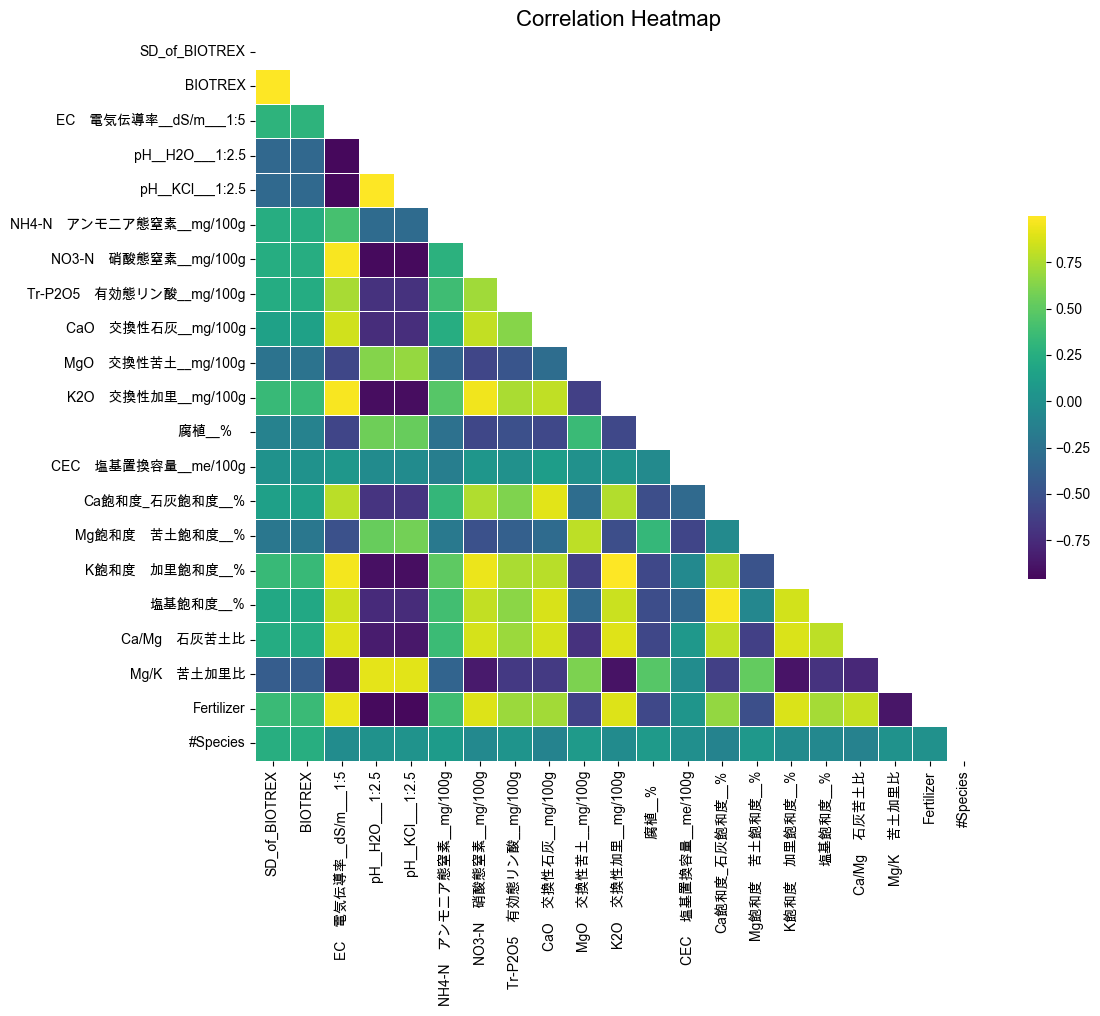


PCA explained variance (first components):

    PC  ExplainedVarianceRatio  ExplainedVariancePct  CumulativePct
0  PC1                  0.5901               59.0142        59.0142
1  PC2                  0.1056               10.5623        69.5765
2  PC3                  0.0916                9.1648        78.7413
3  PC4                  0.0491                4.9120        83.6534
4  PC5                  0.0420                4.1989        87.8523
5  PC6                  0.0360                3.6013        91.4536
6  PC7                  0.0279                2.7931        94.2466


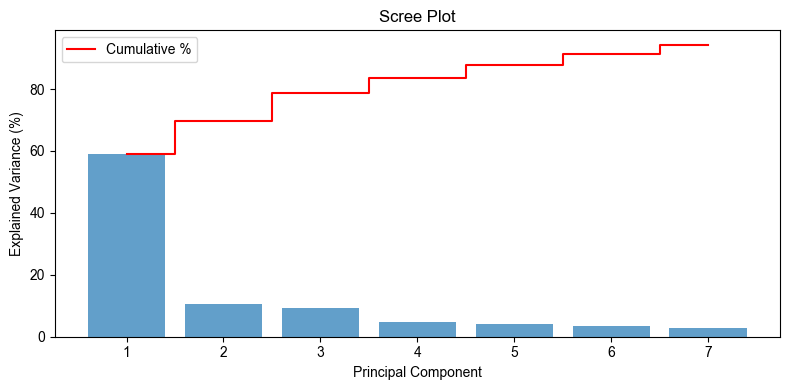

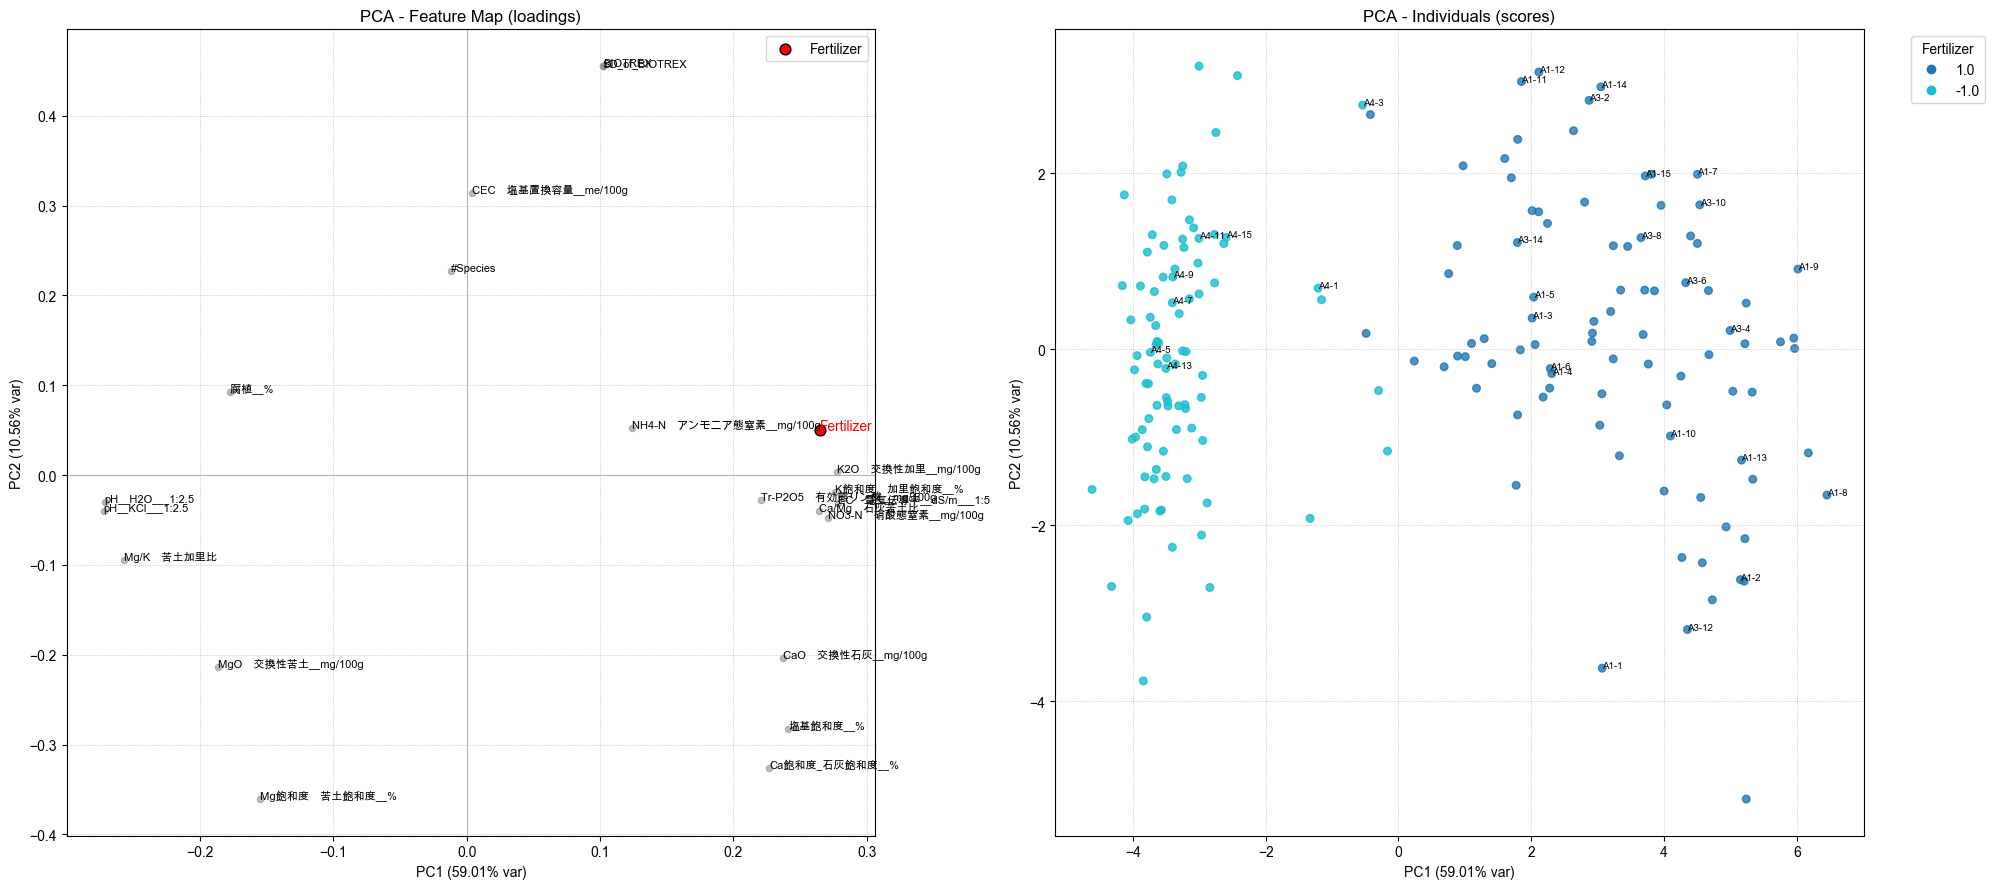

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


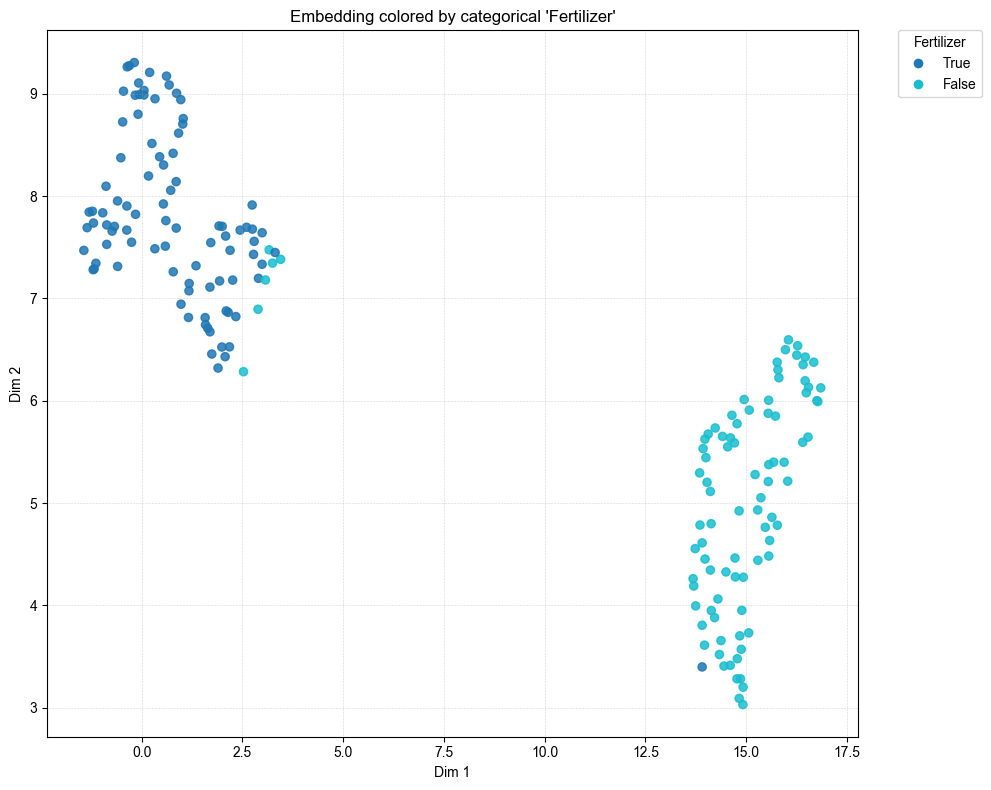

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


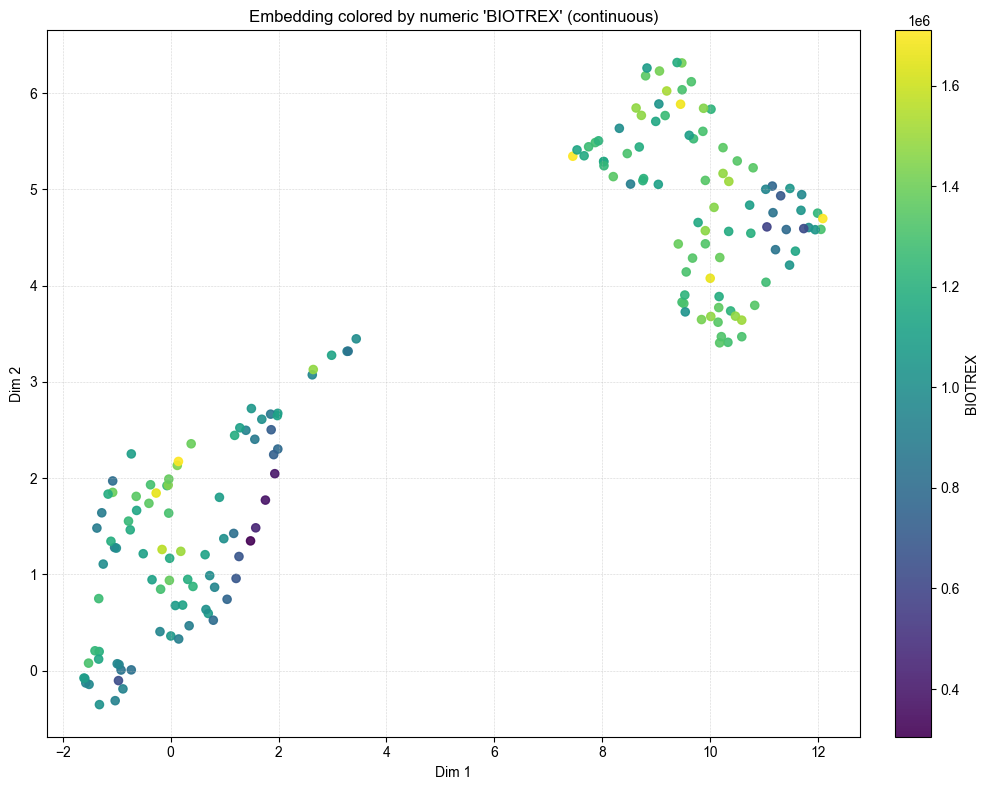

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


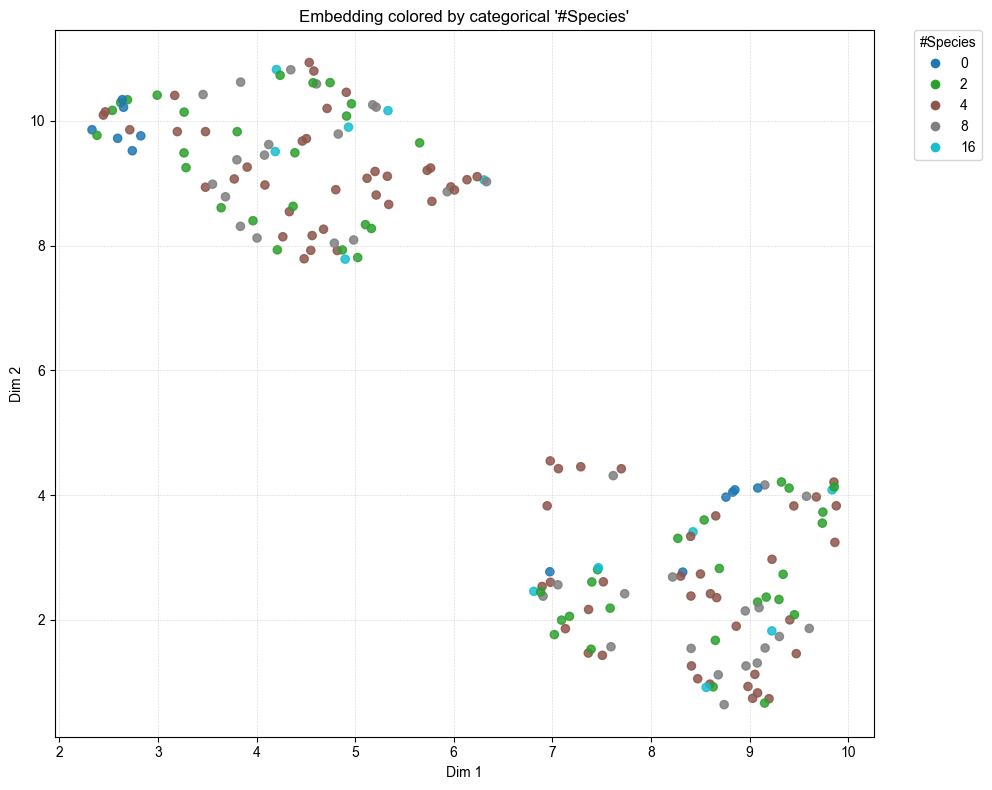

In [17]:
features_of_interest = BIOTREX_FEATURES + SOIL_FEATURES + ["Fertilizer", "#Species"]

Correlation_heat_map(
    df=mesocosm_df[features_of_interest].copy()
)

PCA_analysis(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="BIOTREX"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="#Species"
)

### 1.3.2 Analysis on `Metabolome Features`

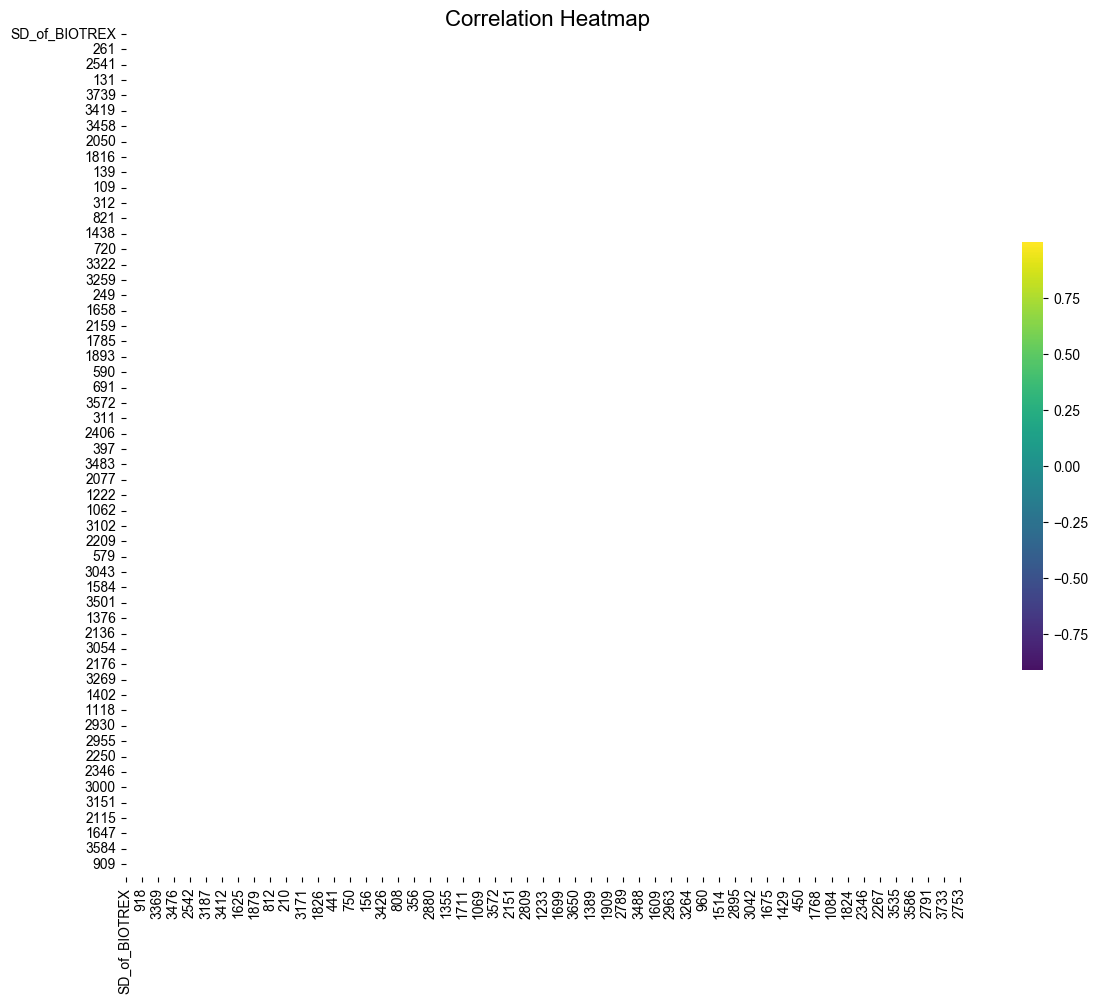


PCA explained variance (first components):

    PC  ExplainedVarianceRatio  ExplainedVariancePct  CumulativePct
0  PC1                  0.2839               28.3895        28.3895
1  PC2                  0.2041               20.4150        48.8044
2  PC3                  0.0993                9.9280        58.7324
3  PC4                  0.0570                5.7026        64.4350
4  PC5                  0.0306                3.0555        67.4904
5  PC6                  0.0246                2.4605        69.9509
6  PC7                  0.0192                1.9172        71.8681


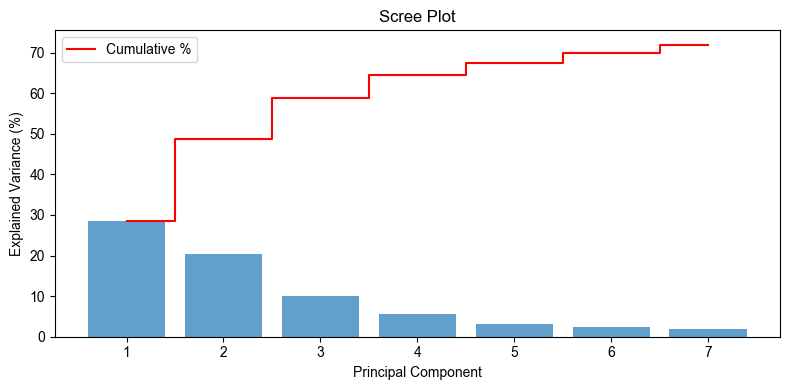

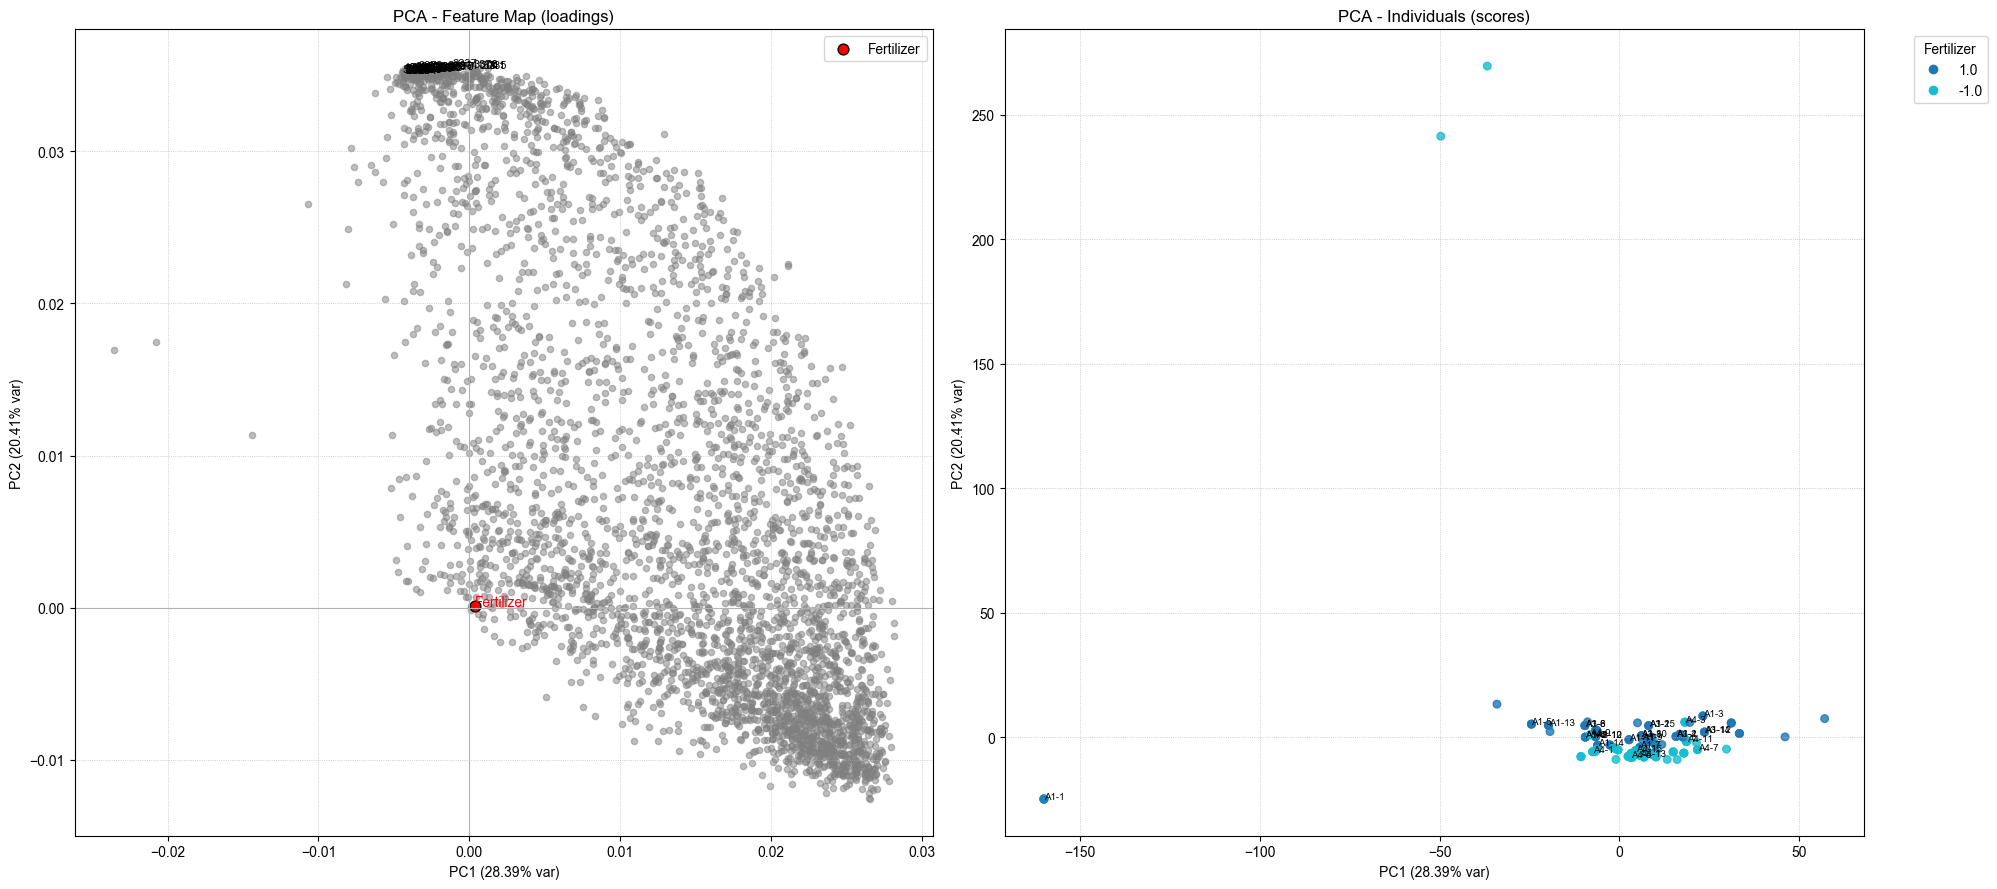

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


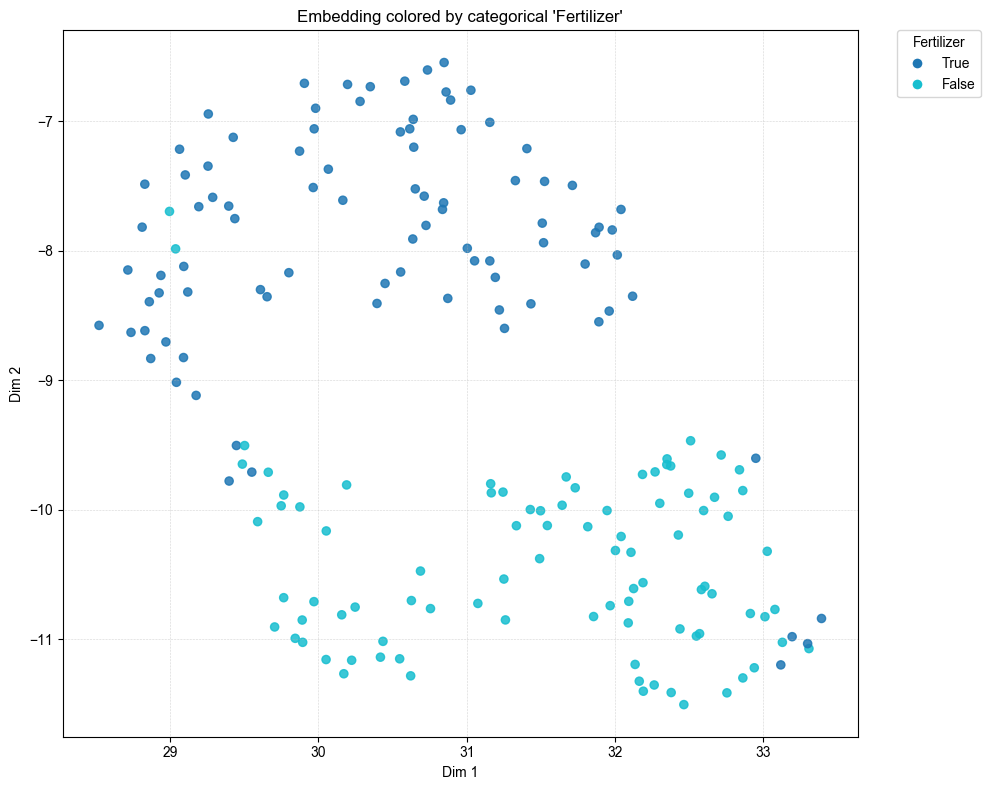

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


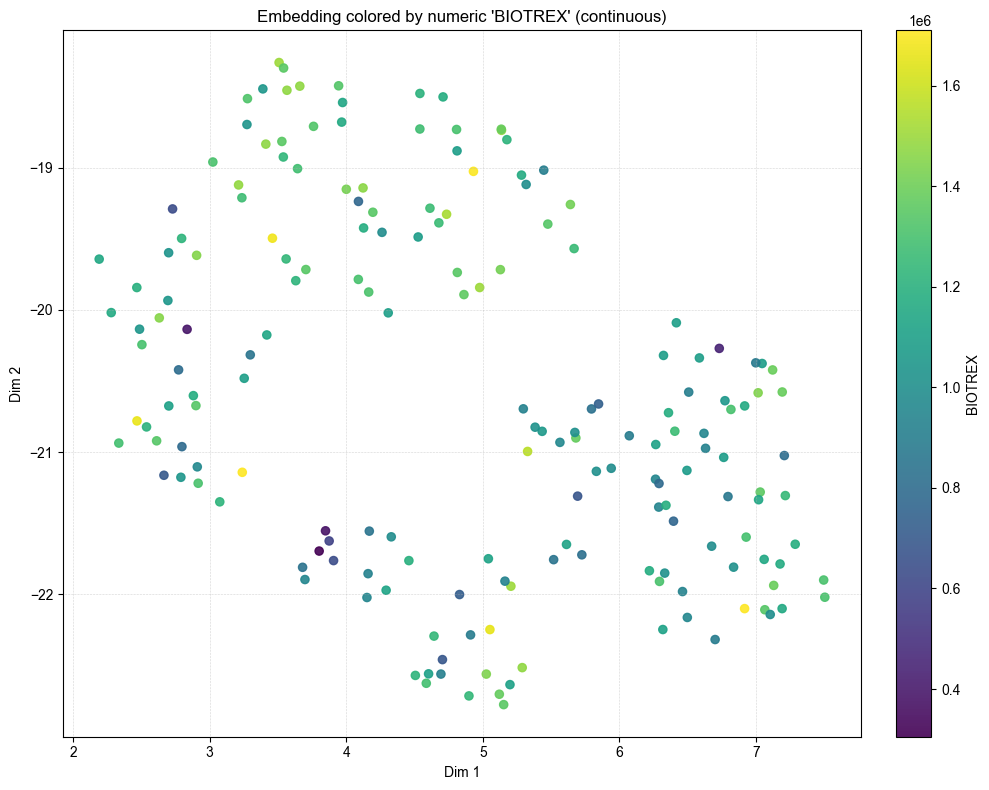

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


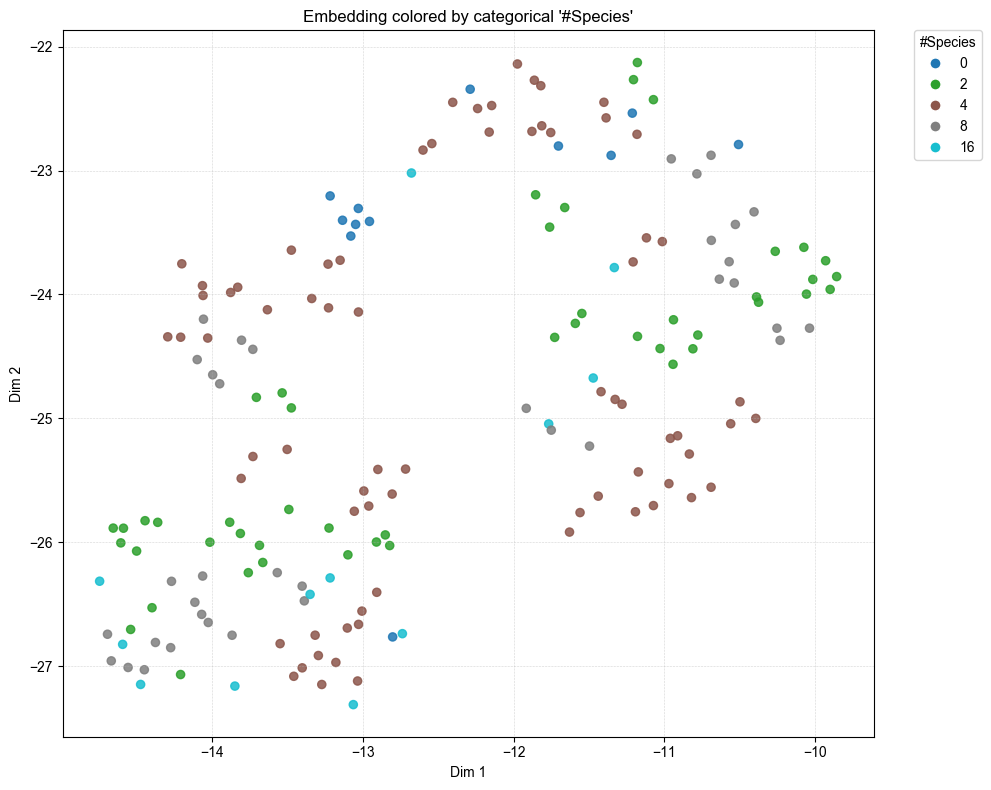

In [18]:
features_of_interest = BIOTREX_FEATURES + METABOLOME_FEATURES + ["Fertilizer", "#Species"]

Correlation_heat_map(
    df=mesocosm_df[features_of_interest].copy()
)

PCA_analysis(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="BIOTREX"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="#Species"
)

### 1.3.4 Analysis of `3D data`

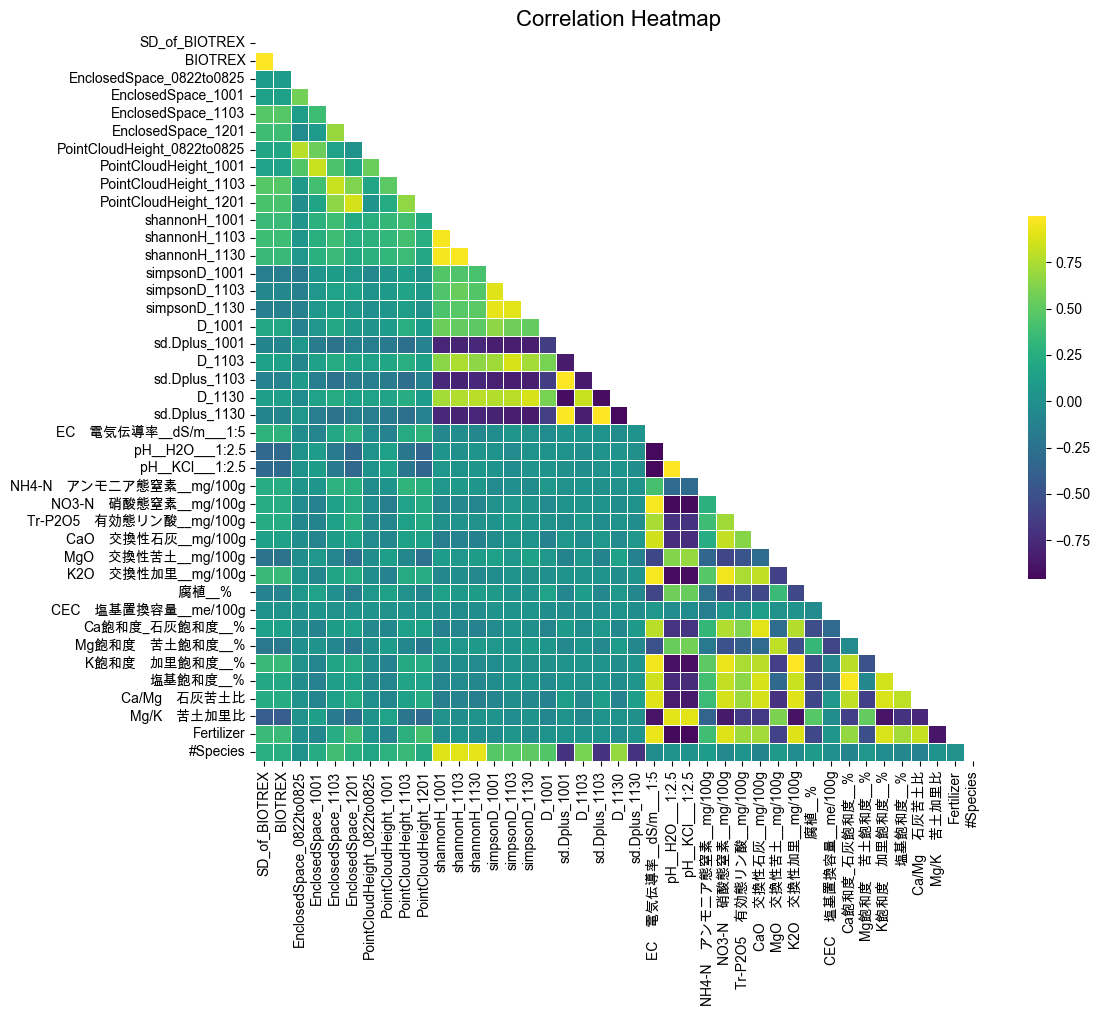


PCA explained variance (first components):

    PC  ExplainedVarianceRatio  ExplainedVariancePct  CumulativePct
0  PC1                  0.3115               31.1539        31.1539
1  PC2                  0.2556               25.5646        56.7185
2  PC3                  0.1027               10.2704        66.9889
3  PC4                  0.0568                5.6846        72.6736
4  PC5                  0.0500                4.9978        77.6713
5  PC6                  0.0418                4.1755        81.8468
6  PC7                  0.0256                2.5606        84.4074


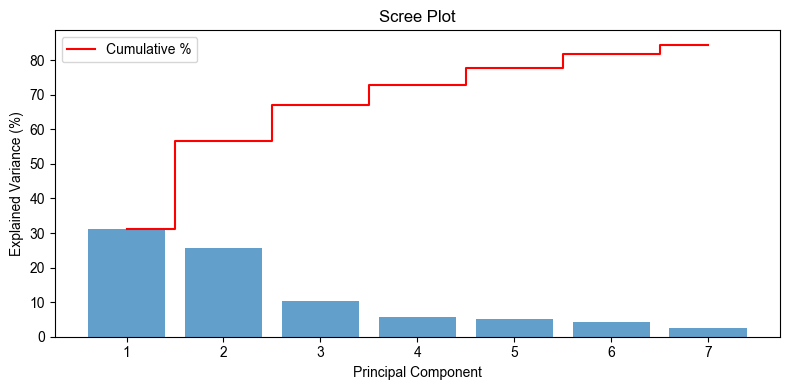

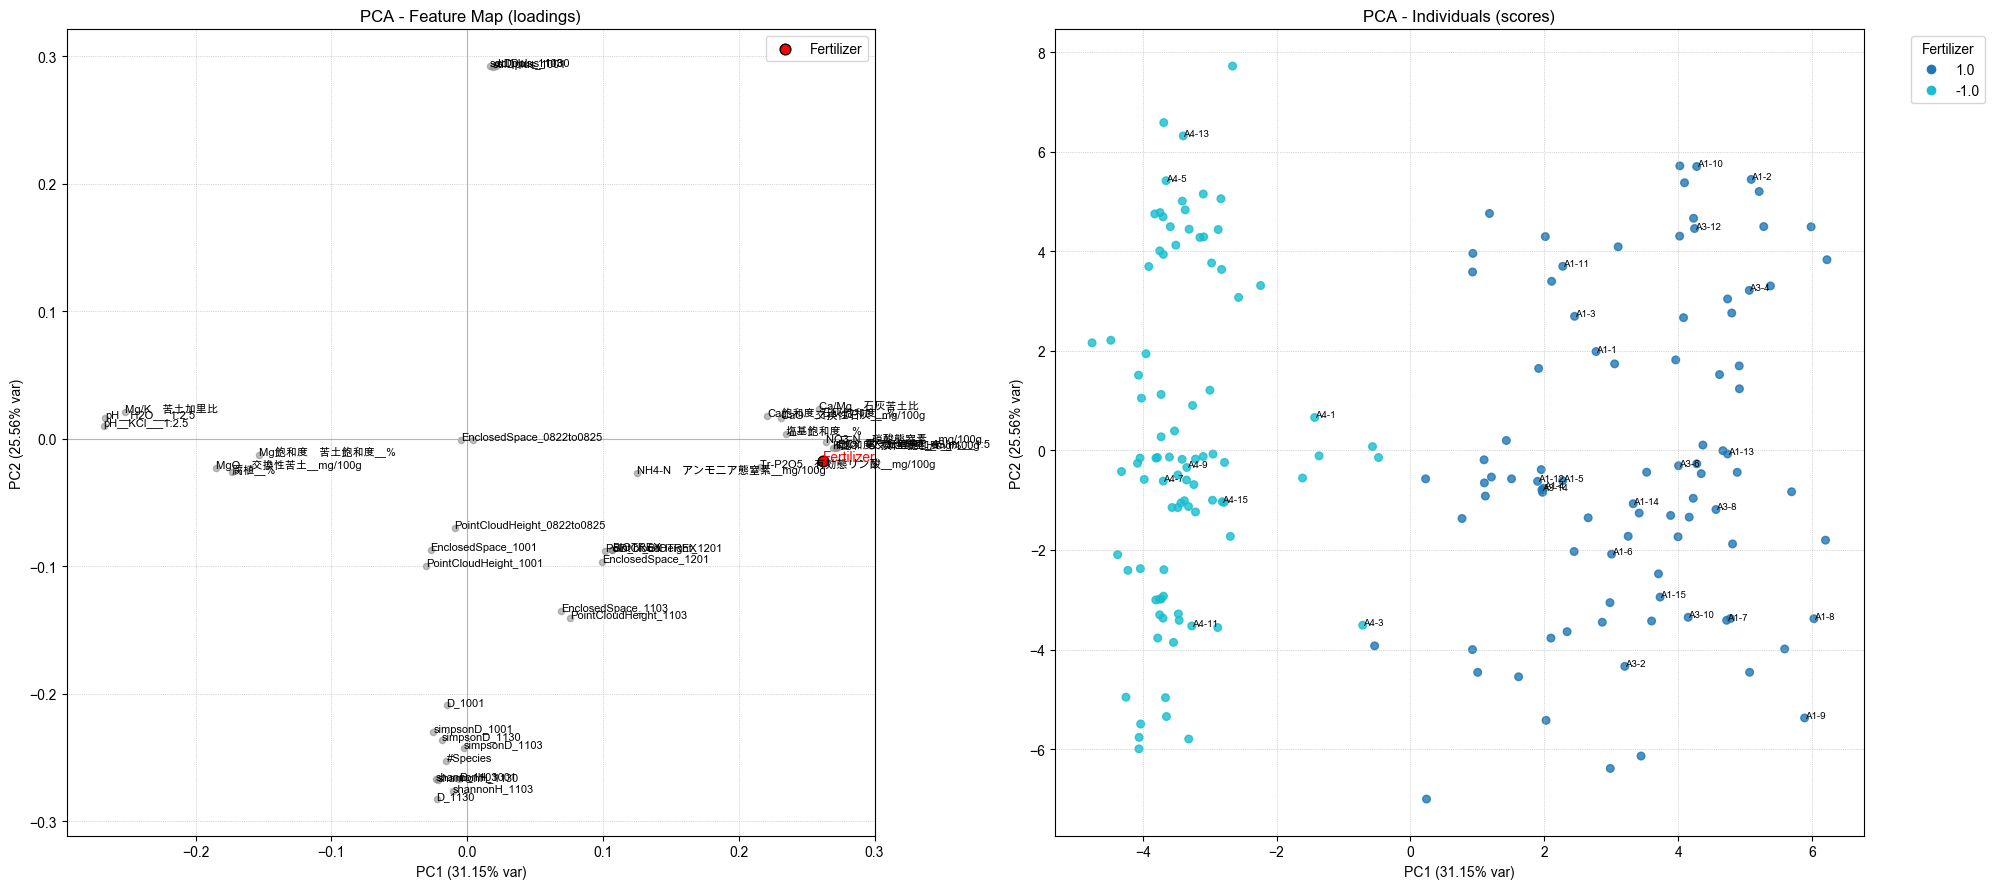


PCA explained variance (first components):

    PC  ExplainedVarianceRatio  ExplainedVariancePct  CumulativePct
0  PC1                  0.3115               31.1539        31.1539
1  PC2                  0.2556               25.5646        56.7185
2  PC3                  0.1027               10.2704        66.9889
3  PC4                  0.0568                5.6846        72.6736
4  PC5                  0.0500                4.9978        77.6713
5  PC6                  0.0418                4.1755        81.8468
6  PC7                  0.0256                2.5606        84.4074


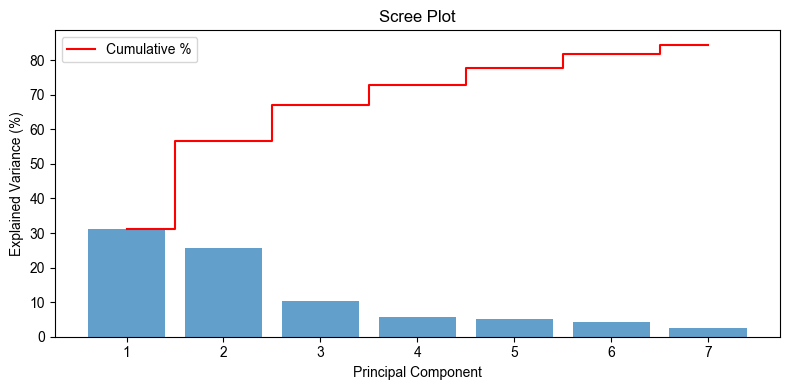

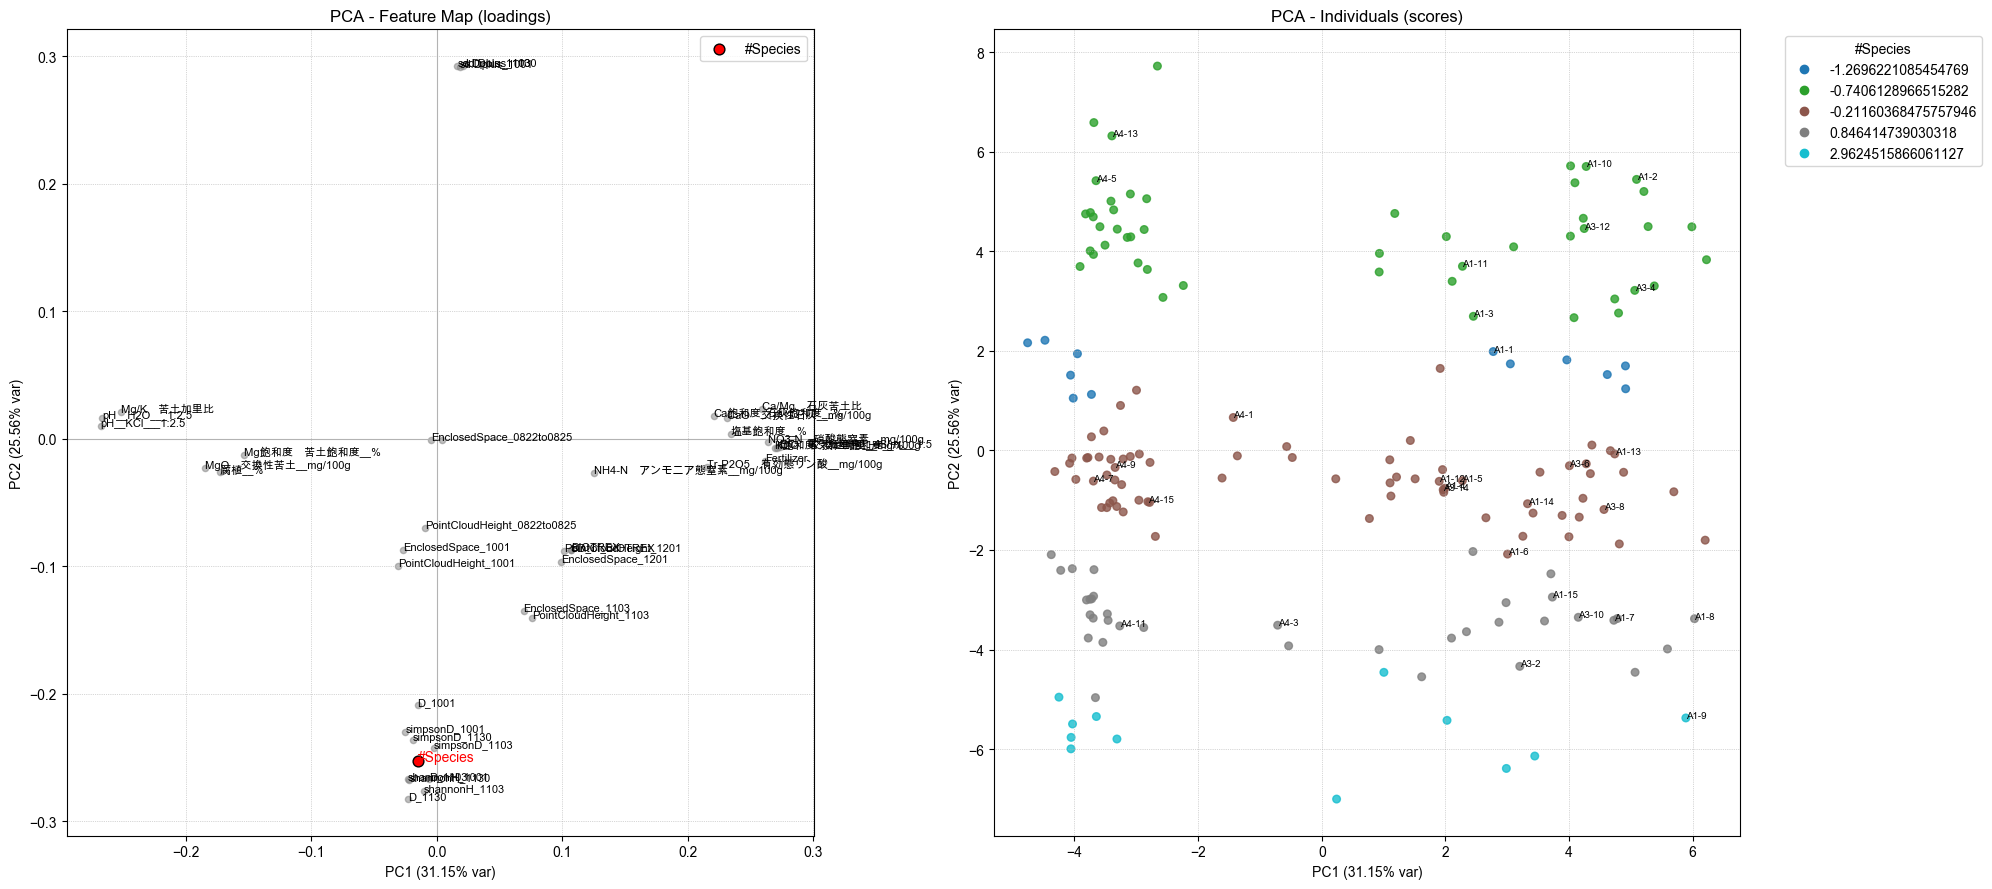

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


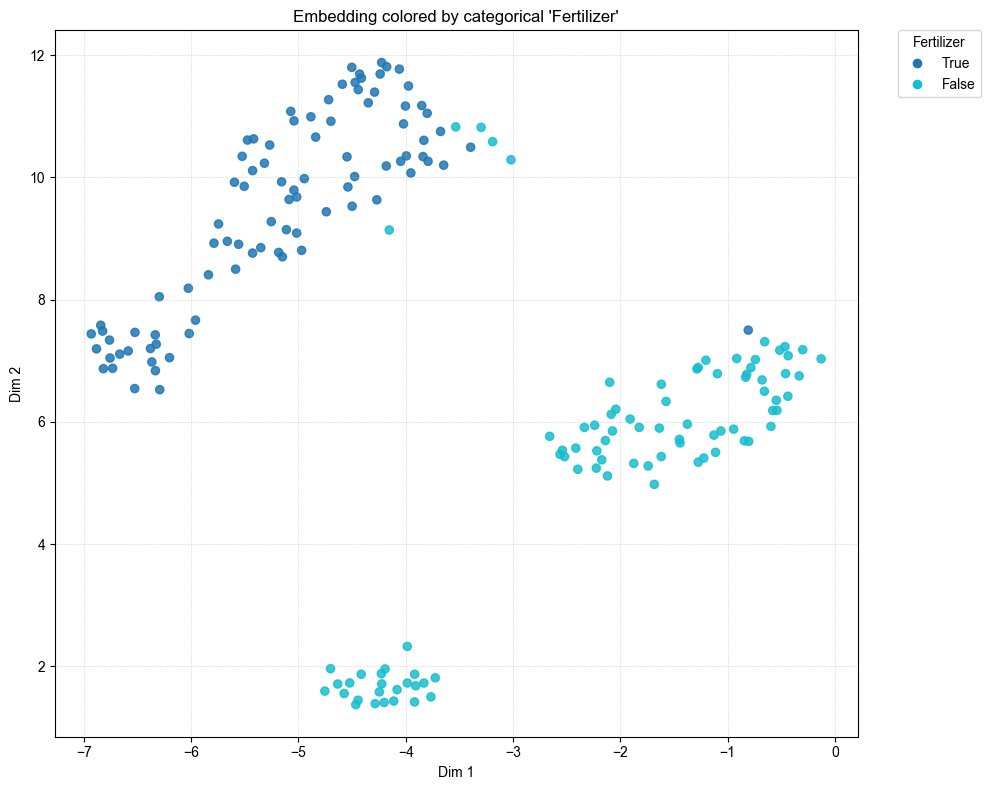

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


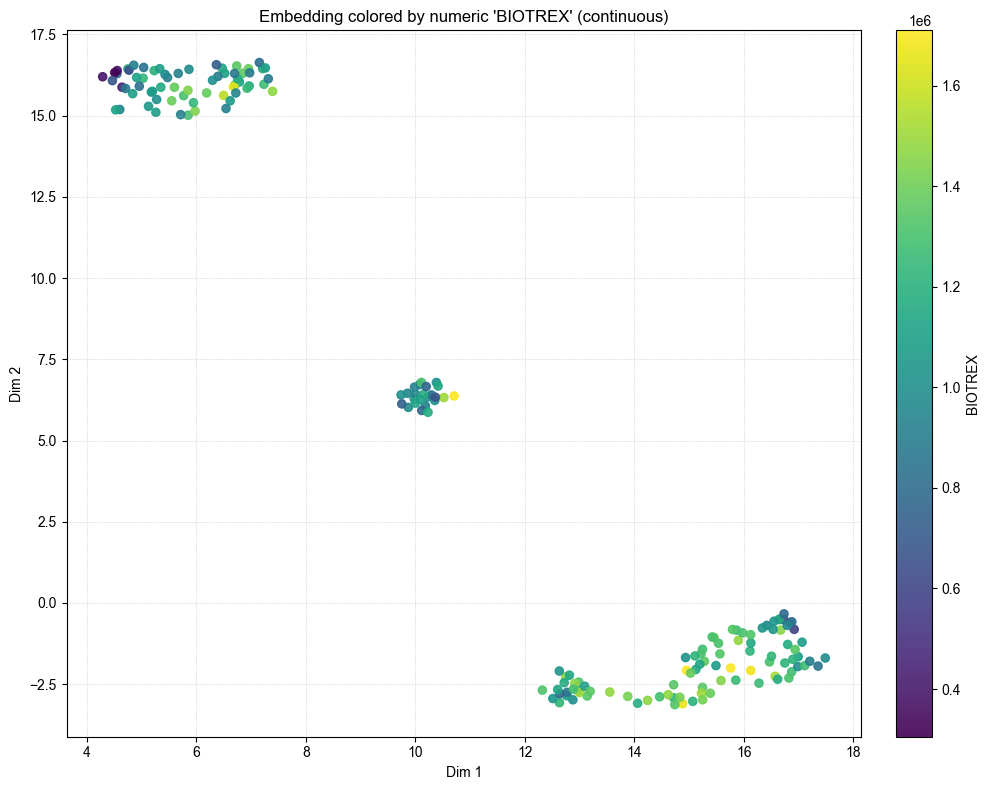

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


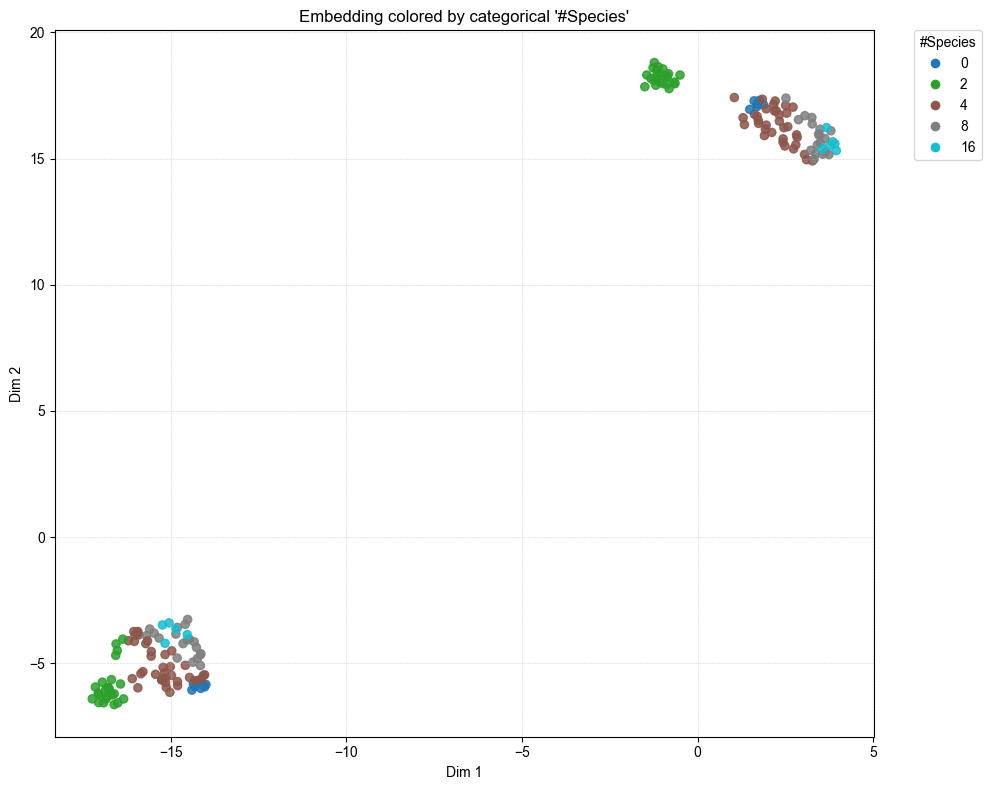

In [19]:
features_of_interest = BIOTREX_FEATURES + M_3D_FEATURES + SOIL_FEATURES + ["Fertilizer", "#Species"]

Correlation_heat_map(
    df=mesocosm_df[features_of_interest].copy()
)

PCA_analysis(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

PCA_analysis(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="#Species"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="BIOTREX"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="#Species"
)

### 1.3.5 `Species Features`

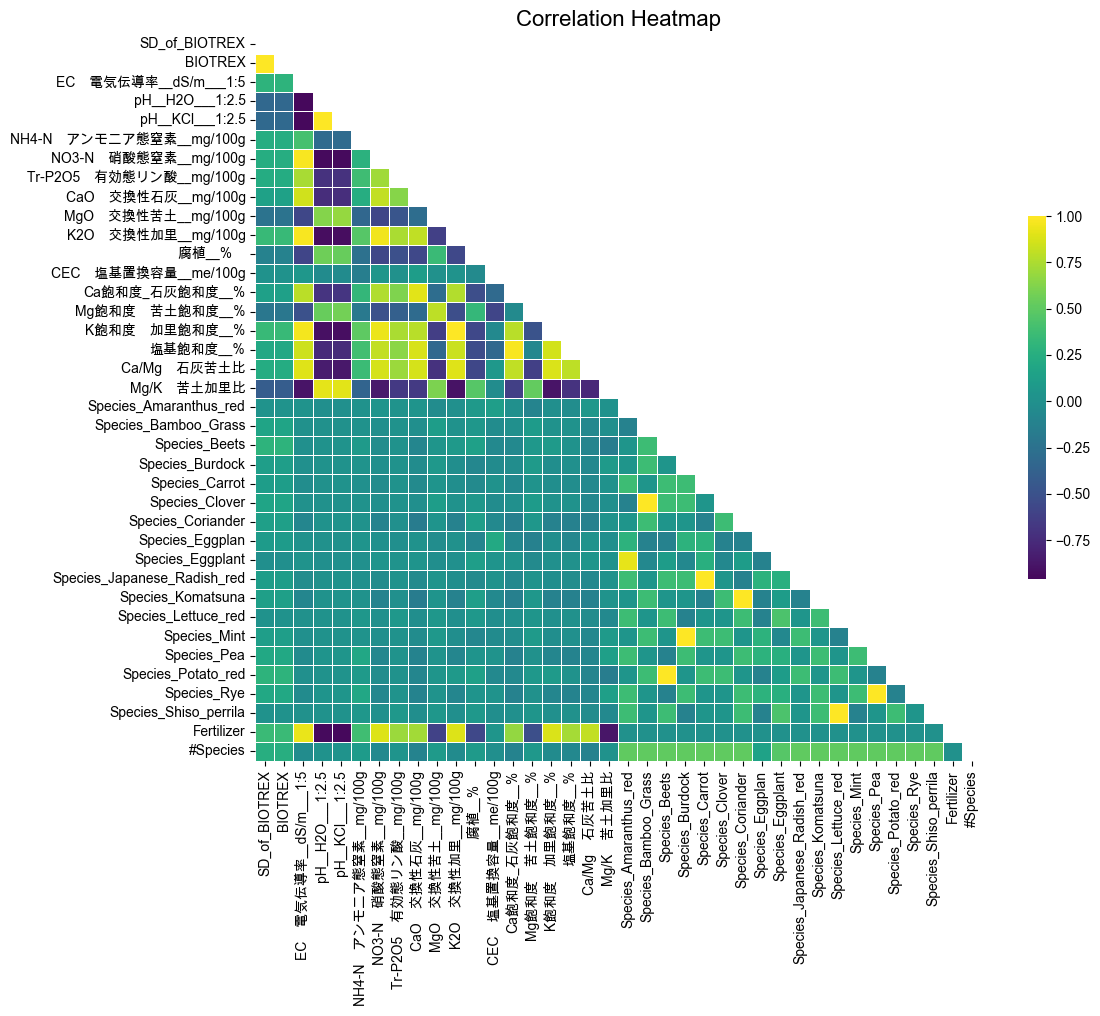


PCA explained variance (first components):

    PC  ExplainedVarianceRatio  ExplainedVariancePct  CumulativePct
0  PC1                  0.3269               32.6909        32.6909
1  PC2                  0.1448               14.4790        47.1699
2  PC3                  0.0835                8.3538        55.5237
3  PC4                  0.0781                7.8055        63.3291
4  PC5                  0.0755                7.5451        70.8742
5  PC6                  0.0577                5.7699        76.6441
6  PC7                  0.0446                4.4640        81.1081


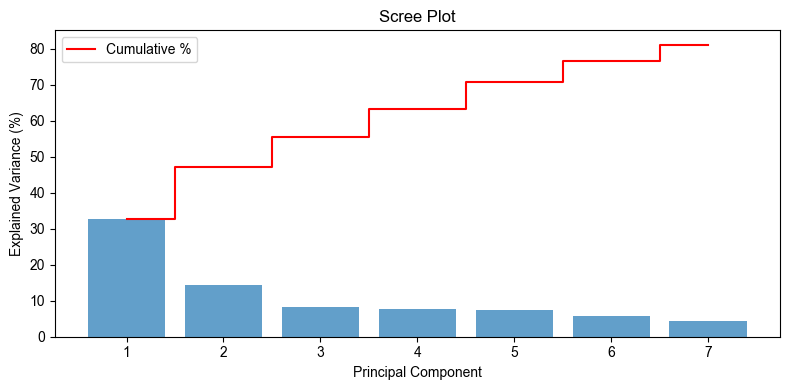

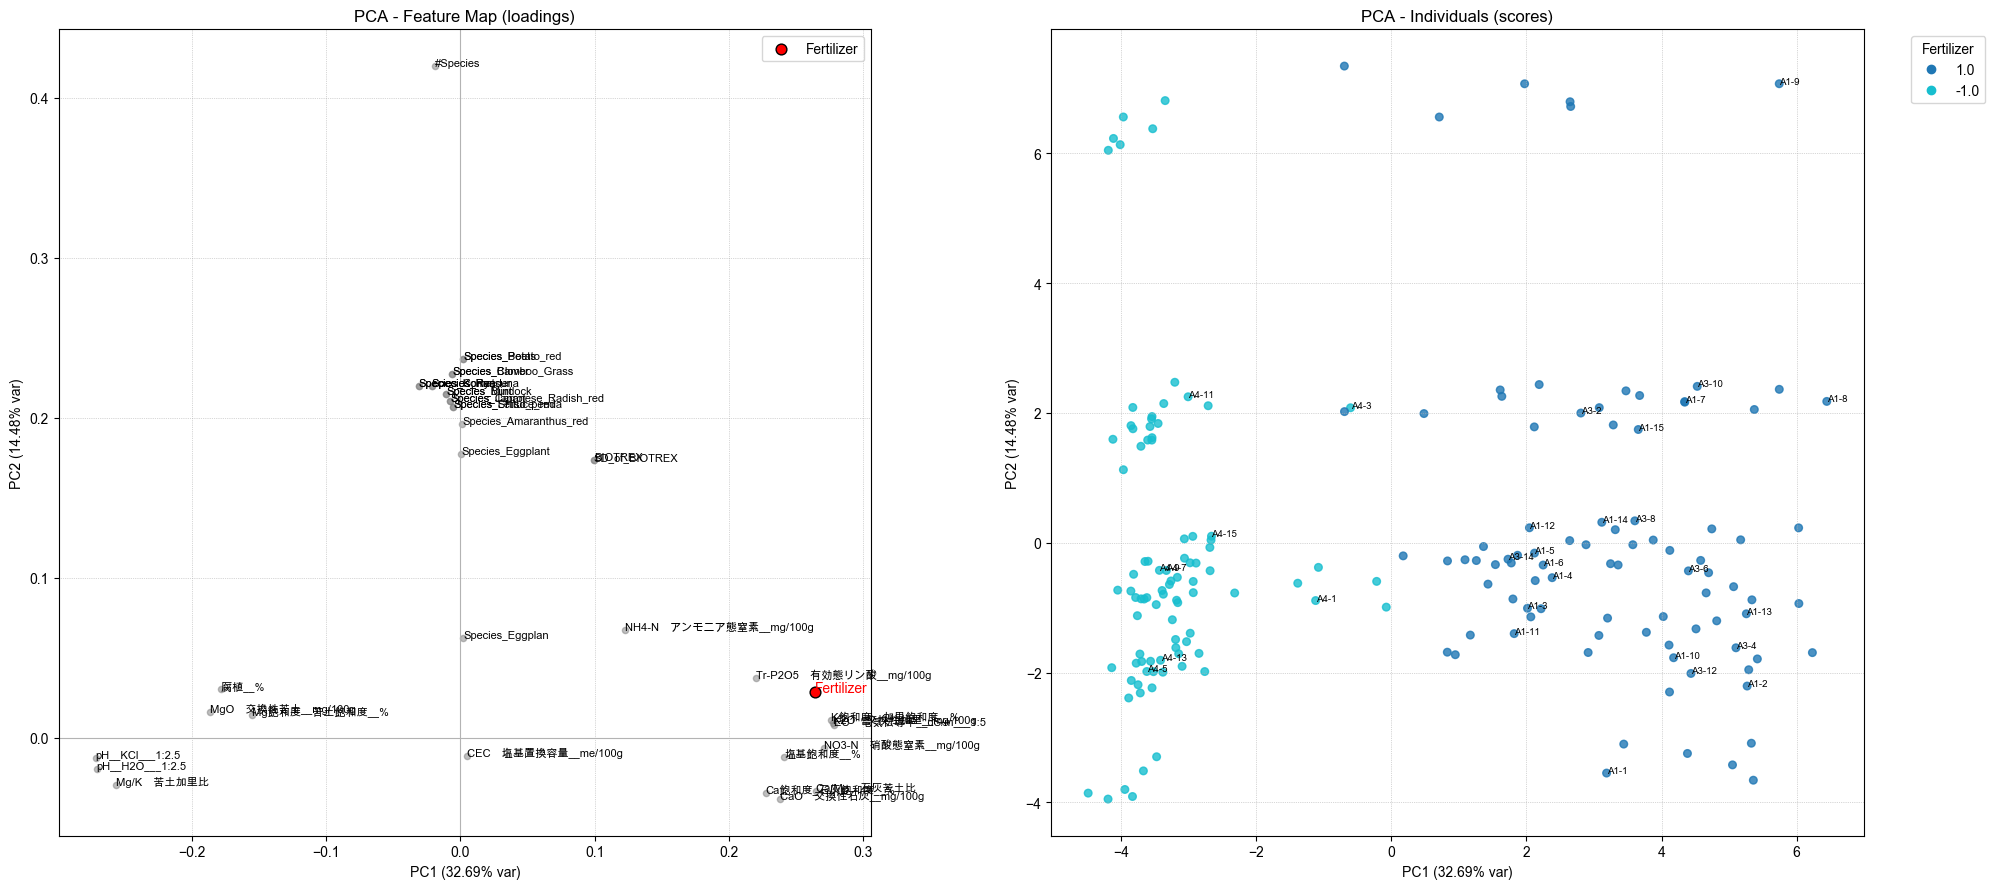


PCA explained variance (first components):

    PC  ExplainedVarianceRatio  ExplainedVariancePct  CumulativePct
0  PC1                  0.3269               32.6909        32.6909
1  PC2                  0.1448               14.4790        47.1699
2  PC3                  0.0835                8.3538        55.5237
3  PC4                  0.0781                7.8055        63.3291
4  PC5                  0.0755                7.5451        70.8742
5  PC6                  0.0577                5.7699        76.6441
6  PC7                  0.0446                4.4640        81.1081


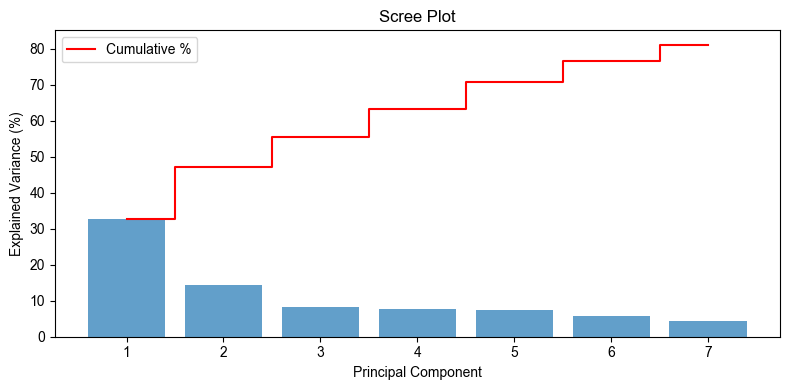

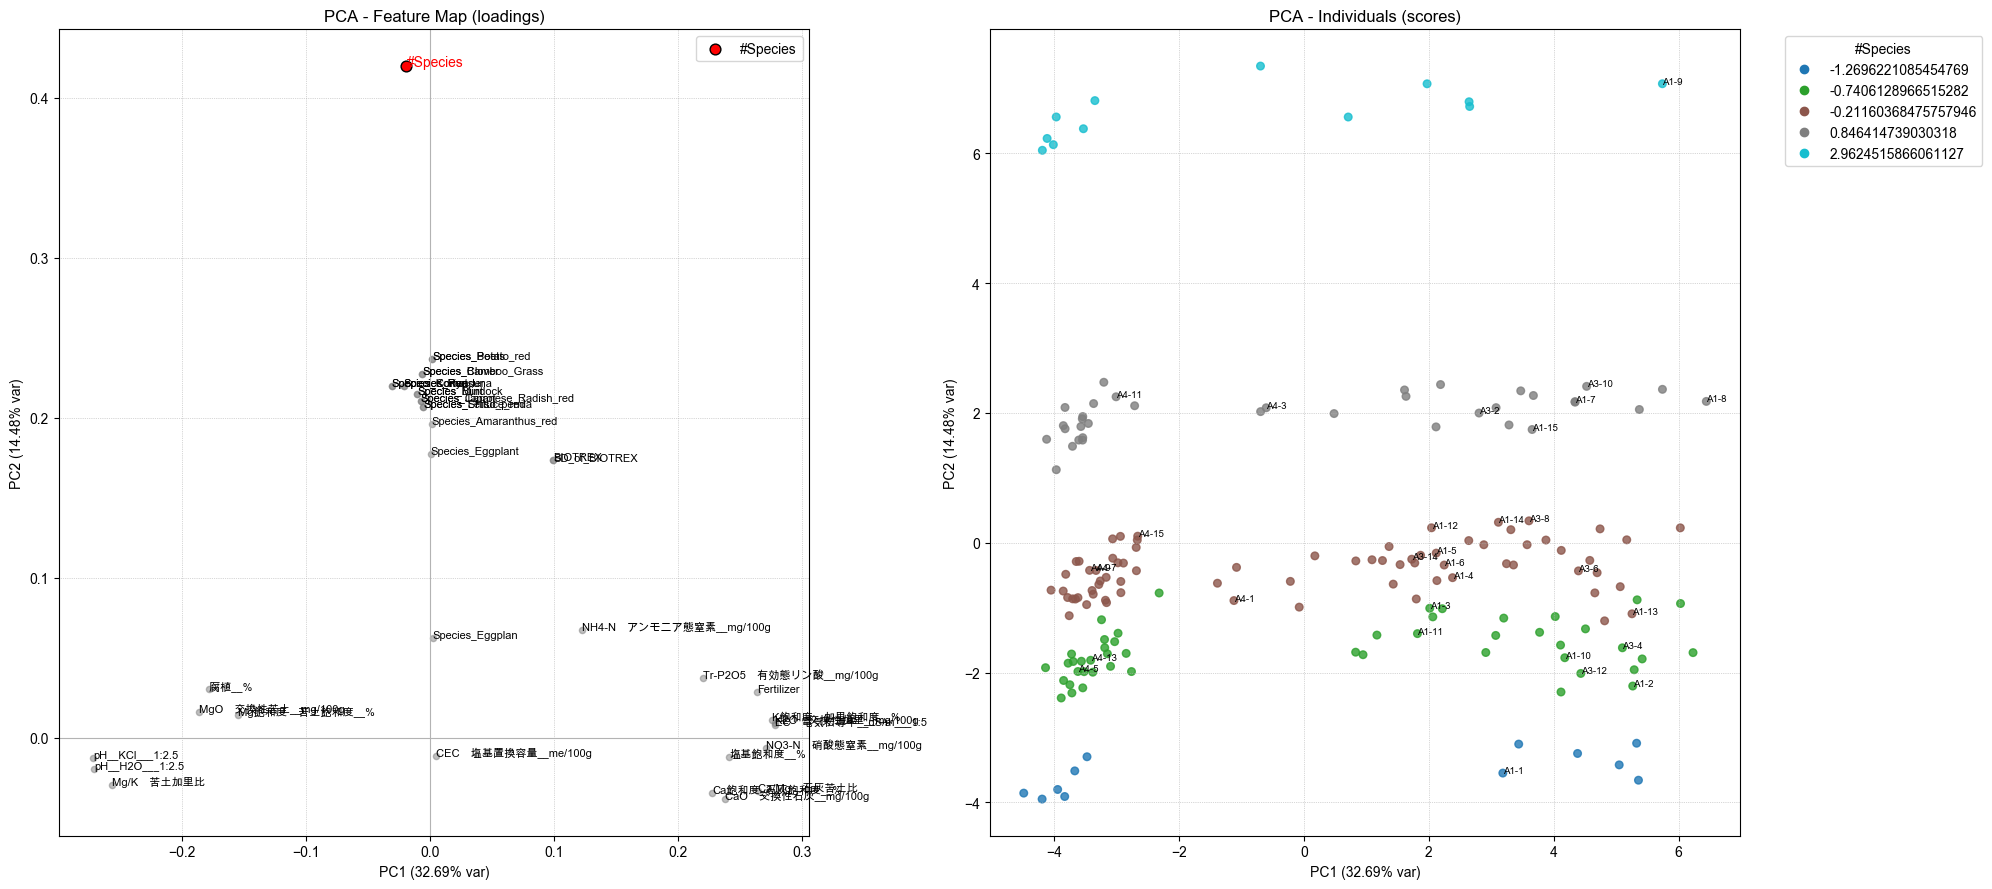

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


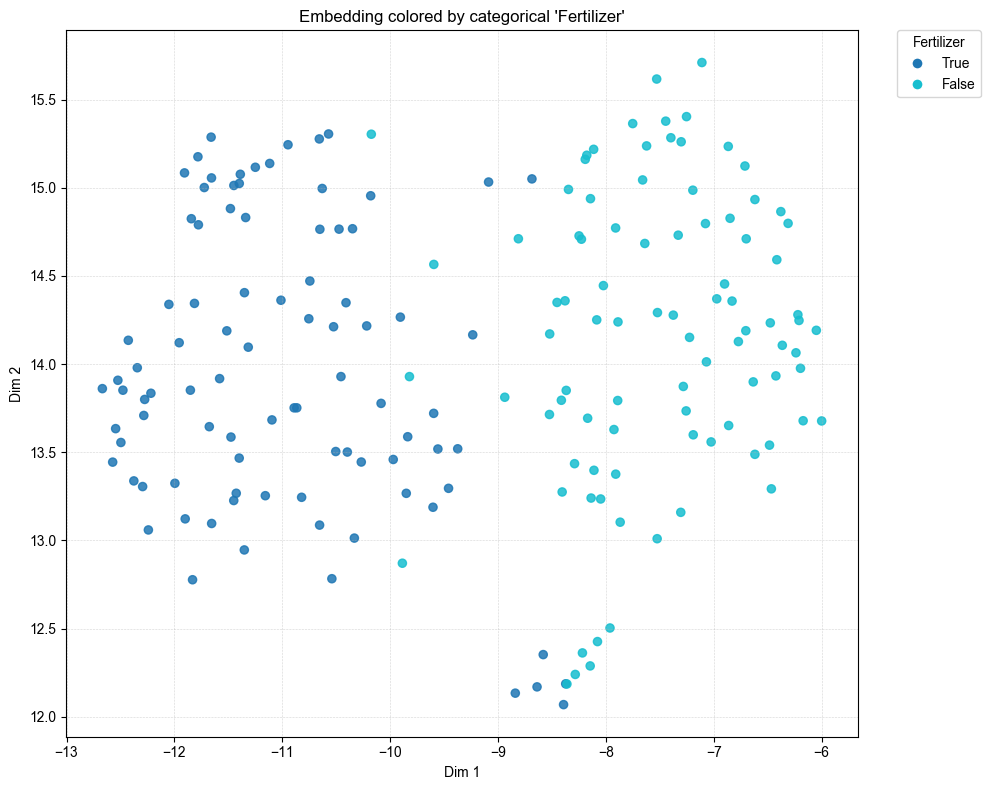

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


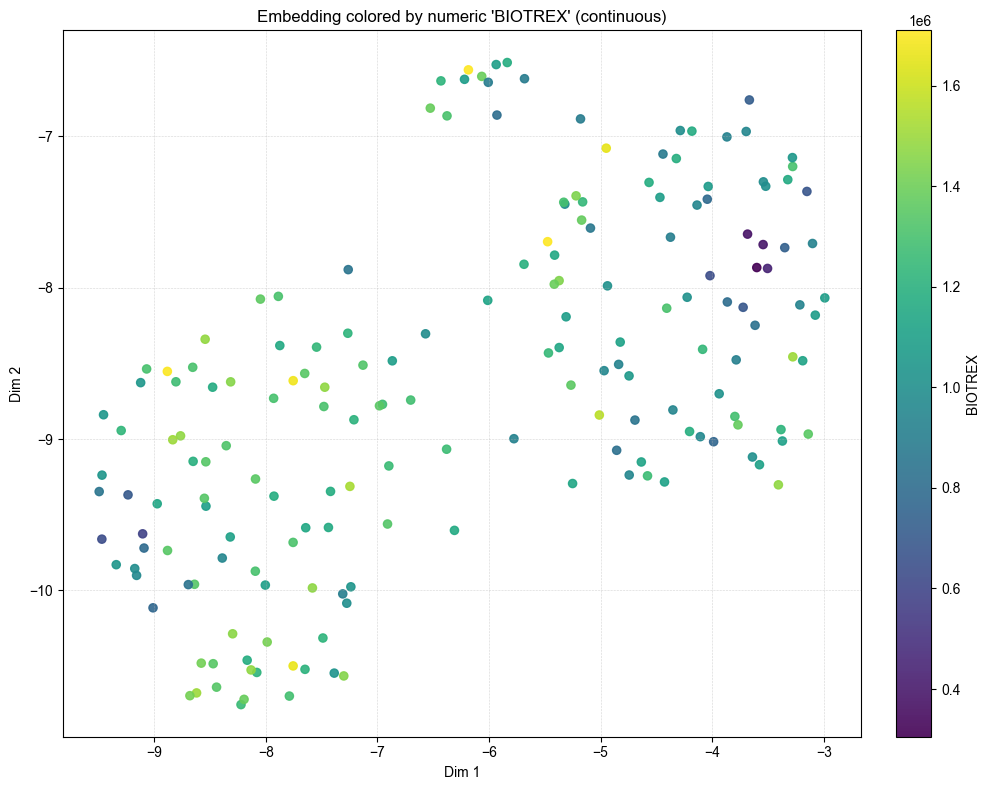

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


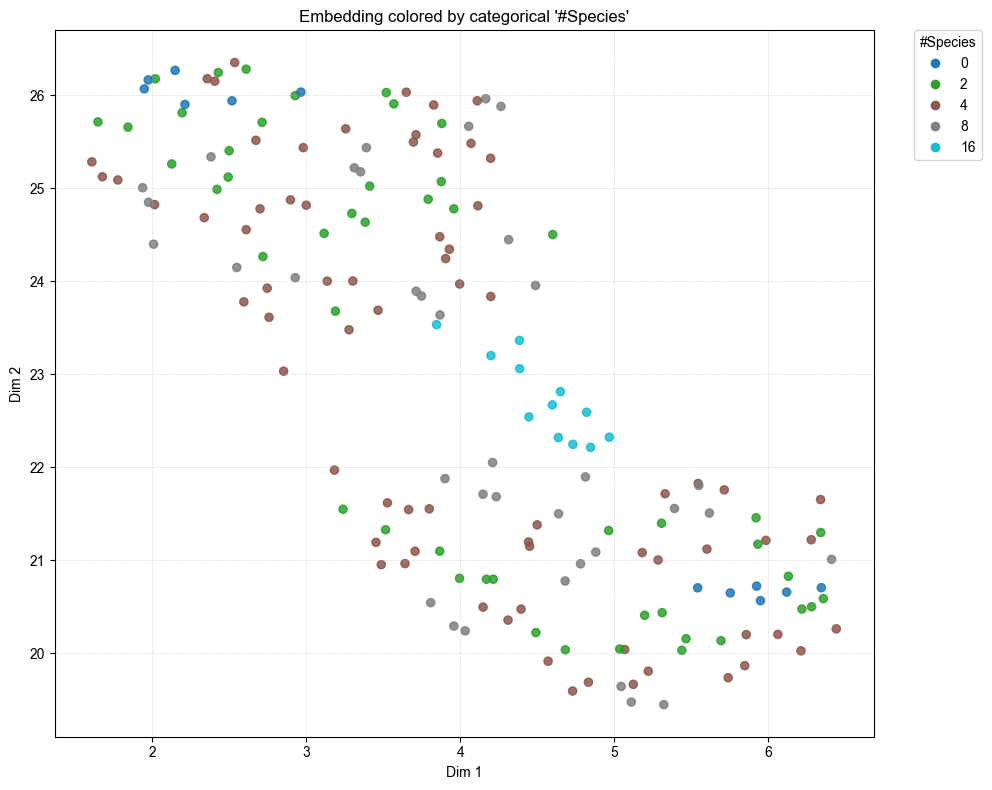

In [20]:
features_of_interest = BIOTREX_FEATURES + SOIL_FEATURES + SPECIES_FEATURES + ["Fertilizer", "#Species"]

Correlation_heat_map(
    df=mesocosm_df[features_of_interest].copy()
)

PCA_analysis(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

PCA_analysis(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="#Species"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="BIOTREX"
)

UMAP_representation(
    df=mesocosm_df[features_of_interest].copy(),
    target_color_col="#Species"
)

## 2. Impact of Number of Species on `BIOTREX`

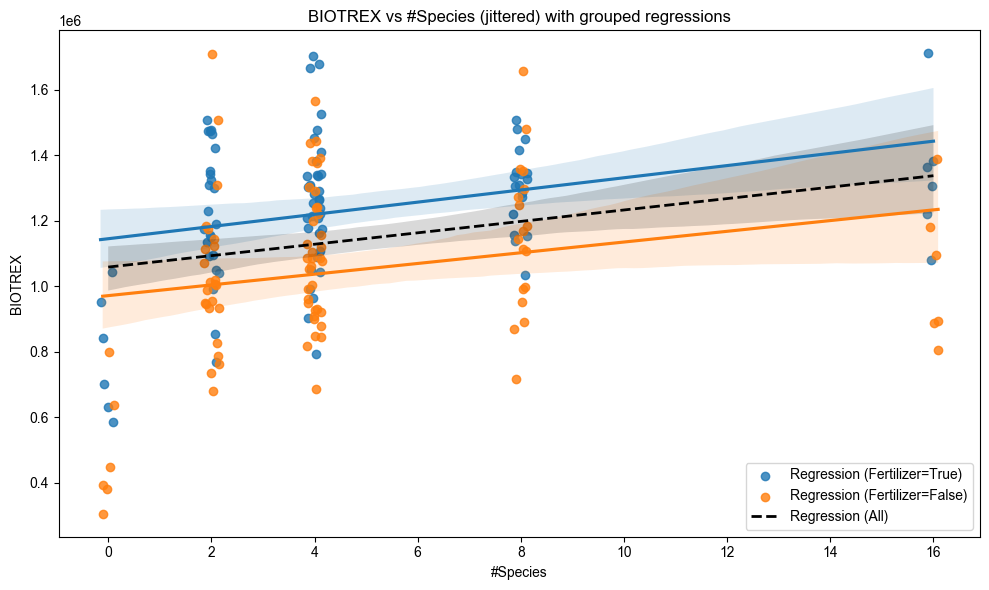

0.30286853218312454 3.587100135257328e-05
the correlation is statistically significant


In [21]:
df = mesocosm_df.copy()

# --- JITTER ON X AXIS ---
# jitter amplitude (adjust if needed)
jitter = 0.15
df["species_jitter"] = df["#Species"] + np.random.uniform(-jitter, jitter, size=len(df))

plt.figure(figsize=(10, 6))

# --- REGRESSION LINES FOR EACH GROUP ---
sns.regplot(
    data=df[df["Fertilizer"] == True],
    x="species_jitter",
    y="BIOTREX",
    scatter=True,
    label="Regression (Fertilizer=True)"
)

sns.regplot(
    data=df[df["Fertilizer"] == False],
    x="species_jitter",
    y="BIOTREX",
    scatter=True,
    label="Regression (Fertilizer=False)"
)

# --- REGRESSION LINE FOR ALL POINTS COMBINED ---
sns.regplot(
    data=df,
    x="#Species",
    y="BIOTREX",
    scatter=False,
    color="black",
    label="Regression (All)",
    line_kws={"linewidth": 2, "linestyle": "--"}
)

plt.xlabel("#Species")
plt.title("BIOTREX vs #Species (jittered) with grouped regressions")
plt.legend()
plt.tight_layout()
plt.show()

from scipy.stats import spearmanr
corr, pval = spearmanr(df["BIOTREX"], df["#Species"])
print(corr, pval)
if pval < 0.05 :
    print("the correlation is statistically significant")

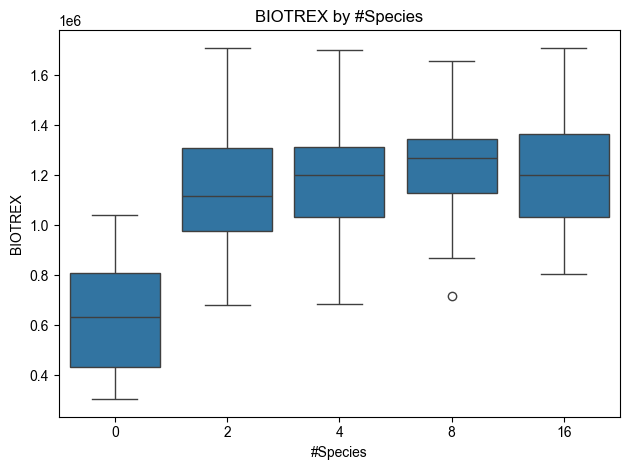

In [22]:
sns.boxplot(
    data=mesocosm_df,
    x="#Species",
    y="BIOTREX"      
)

plt.title("BIOTREX by #Species")
plt.tight_layout()
plt.show()

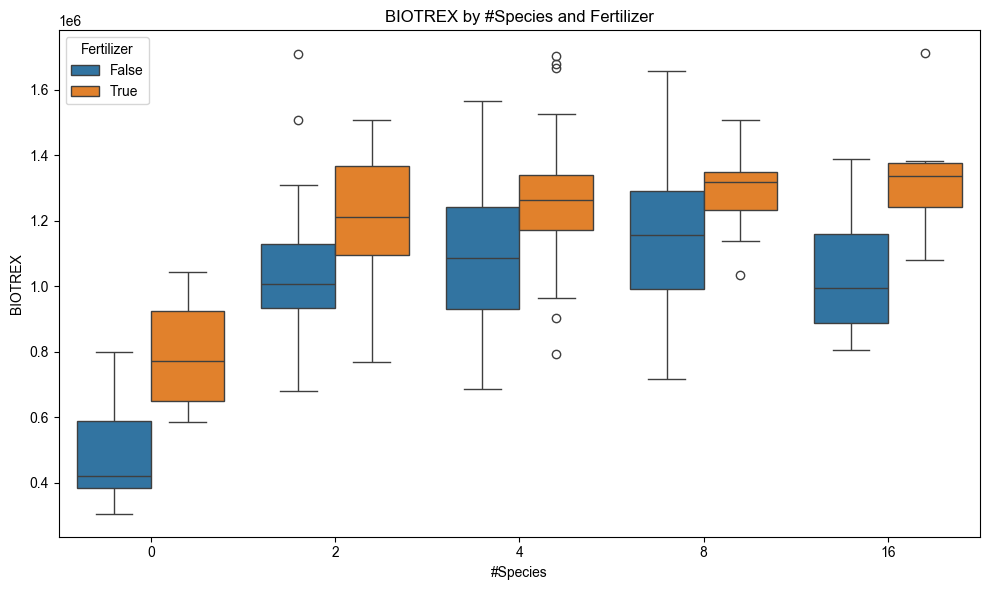

In [23]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=mesocosm_df,
    x="#Species",
    y="BIOTREX",
    hue="Fertilizer"        # one boxplot per Fertilizer group for each species
)

plt.title("BIOTREX by #Species and Fertilizer")
plt.legend(title="Fertilizer")
plt.tight_layout()
plt.show()


## Identify Which Species Impact `BIOTREX` the Most

### Linear impact with Linear Regression

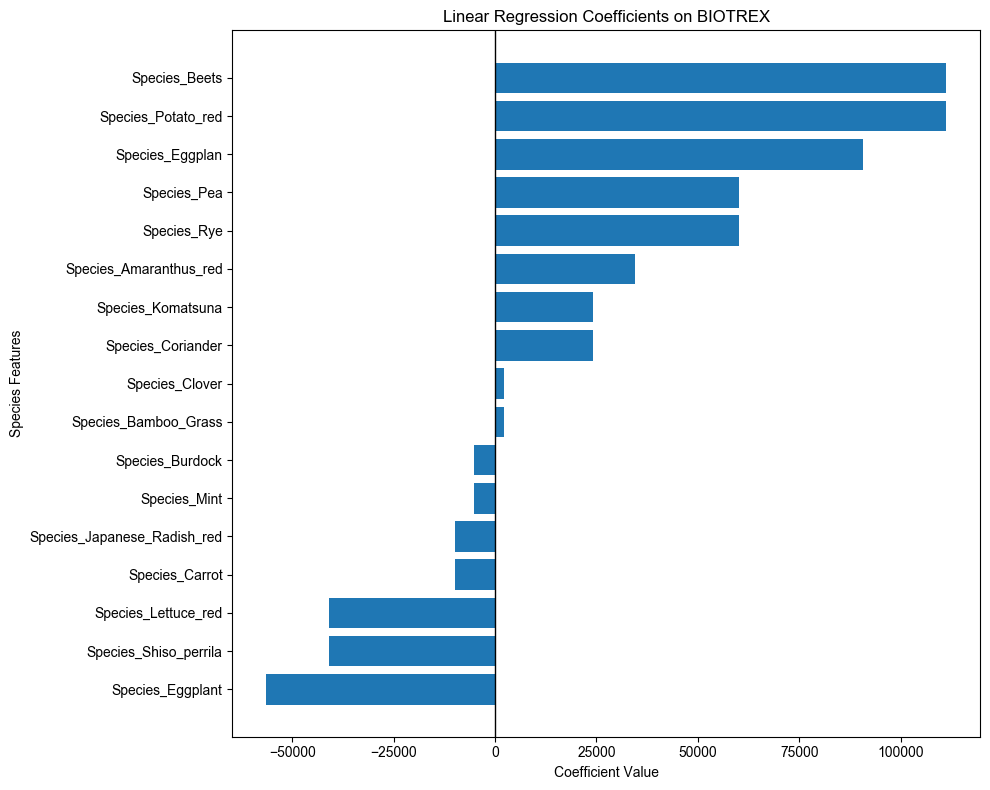

In [24]:
from sklearn.linear_model import LinearRegression

# Define features and target
X = mesocosm_df[SPECIES_FEATURES]       # list of species feature column names
y = mesocosm_df["BIOTREX"]

# Fit model
linreg = LinearRegression()
linreg.fit(X, y)

# Extract coefficients
coef = linreg.coef_
feature_names = X.columns


coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
}).sort_values("coefficient")

plt.figure(figsize=(10, 8))
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.axvline(0, color="black", linewidth=1)  # vertical zero line

plt.title("Linear Regression Coefficients on BIOTREX")
plt.xlabel("Coefficient Value")
plt.ylabel("Species Features")

plt.tight_layout()
plt.show()

### Non-linear impact with Random Forest & SHAP

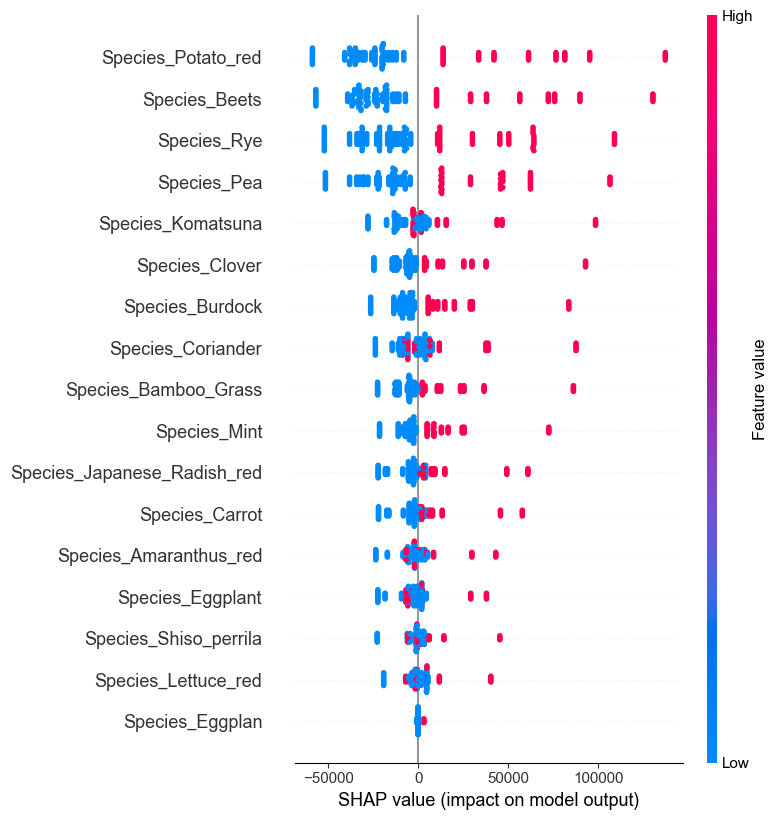

In [25]:
from sklearn.ensemble import RandomForestRegressor
import shap

X = mesocosm_df[SPECIES_FEATURES]    # species columns
y = mesocosm_df["BIOTREX"]

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# create the SHAP explainer
explainer = shap.TreeExplainer(rf)

# compute SHAP values
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="dot")


## Find Non-Fertilizer Combinations Matching Fertilizer Quality

In [26]:
import plotly.express as px

fig = px.scatter(
    df,
    x="#Species",
    y="BIOTREX",
    color="Fertilizer",
    hover_data=SPECIES_FEATURES,      # shows which species are present
    opacity=0.8
)

fig.update_traces(marker=dict(size=9))
fig.update_layout(title="BIOTREX vs Species Count (Interactive)")
fig.show()

Mean BIOTREX with fertilizer: 1233825.5777777778
Champion combination: ['Species_Amaranthus_red', 'Species_Burdock', 'Species_Carrot', 'Species_Eggplan', 'Species_Japanese_Radish_red', 'Species_Mint', 'Species_Pea', 'Species_Rye']
Champion combination: ['Species_Amaranthus_red', 'Species_Carrot', 'Species_Eggplant', 'Species_Japanese_Radish_red']
Champion combination: ['Species_Bamboo_Grass', 'Species_Beets', 'Species_Burdock', 'Species_Carrot', 'Species_Clover', 'Species_Japanese_Radish_red', 'Species_Mint', 'Species_Potato_red']
Champion combination: ['Species_Bamboo_Grass', 'Species_Clover', 'Species_Coriander', 'Species_Komatsuna']
Champion combination: ['Species_Pea', 'Species_Rye']
Champion combination: ['Species_Beets', 'Species_Lettuce_red', 'Species_Potato_red', 'Species_Shiso_perrila']
Champion combination: ['Species_Burdock', 'Species_Mint', 'Species_Pea', 'Species_Rye']
Champion combination: ['Species_Amaranthus_red', 'Species_Bamboo_Grass', 'Species_Beets', 'Species_Burdoc

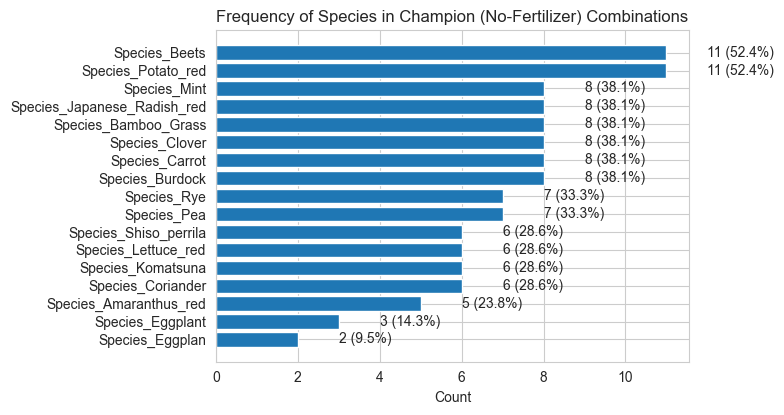

In [27]:
fert_mean = df[df["Fertilizer"] == 1]["BIOTREX"].mean()
print("Mean BIOTREX with fertilizer:", fert_mean)

champions = df[
    (df["Fertilizer"] == 0) &
    (df["BIOTREX"] >= fert_mean)
]

species_cols = SPECIES_FEATURES  # your binary species feature list

champion_species = champions[species_cols]

unique_combinations = champion_species.drop_duplicates()

for i, row in unique_combinations.iterrows():
    present = [sp for sp in species_cols if row[sp] == 1]
    print("Champion combination:", present)

if champions.empty:
    print("No champion rows found (no non-fertilized rows meet/exceed fertilized mean).")
else:
    # If species columns are binary (0/1), sum gives counts of presence
    species_counts = champions[species_cols].sum(axis=0).sort_values(ascending=True)

    # Also compute percentage of champion rows in which each species is present
    n_champions = len(champions)
    species_pct = (species_counts / n_champions * 100).round(1)

    # Create dataframe for plotting
    plot_df = pd.DataFrame({
        "species": species_counts.index,
        "count": species_counts.values,
        "pct": species_pct.values
    }).sort_values("count", ascending=True)  # ascending for horizontal barplot

    # Plot: horizontal bar chart
    plt.figure(figsize=(8, max(4, 0.25 * len(plot_df))))  # height scales with number of species
    sns.set_style("whitegrid")

    ax = plt.barh(plot_df["species"], plot_df["count"])
    plt.xlabel("Count")
    plt.title("Frequency of Species in Champion (No-Fertilizer) Combinations")

    # Annotate counts and % on the bars
    for i, (count, pct) in enumerate(zip(plot_df["count"], plot_df["pct"])):
        plt.text(count + max(1, n_champions*0.01), i, f"{count} ({pct}%)", va="center")

    plt.tight_layout()
    plt.show()

Top 10 Features most impacted by #Species:
          Feature  Correlation Type  P_Value
36  sd.Dplus_1103      -0.9531   3D   0.0000
28  shannonH_1103       0.9503   3D   0.0000
29  shannonH_1130       0.9438   3D   0.0000
27  shannonH_1001       0.9397   3D   0.0000
38  sd.Dplus_1130      -0.9339   3D   0.0000
34  sd.Dplus_1001      -0.9175   3D   0.0000
35         D_1103       0.9007   3D   0.0000
37         D_1130       0.8685   3D   0.0000
33         D_1001       0.5978   3D   0.0000
31  simpsonD_1103       0.5595   3D   0.0000


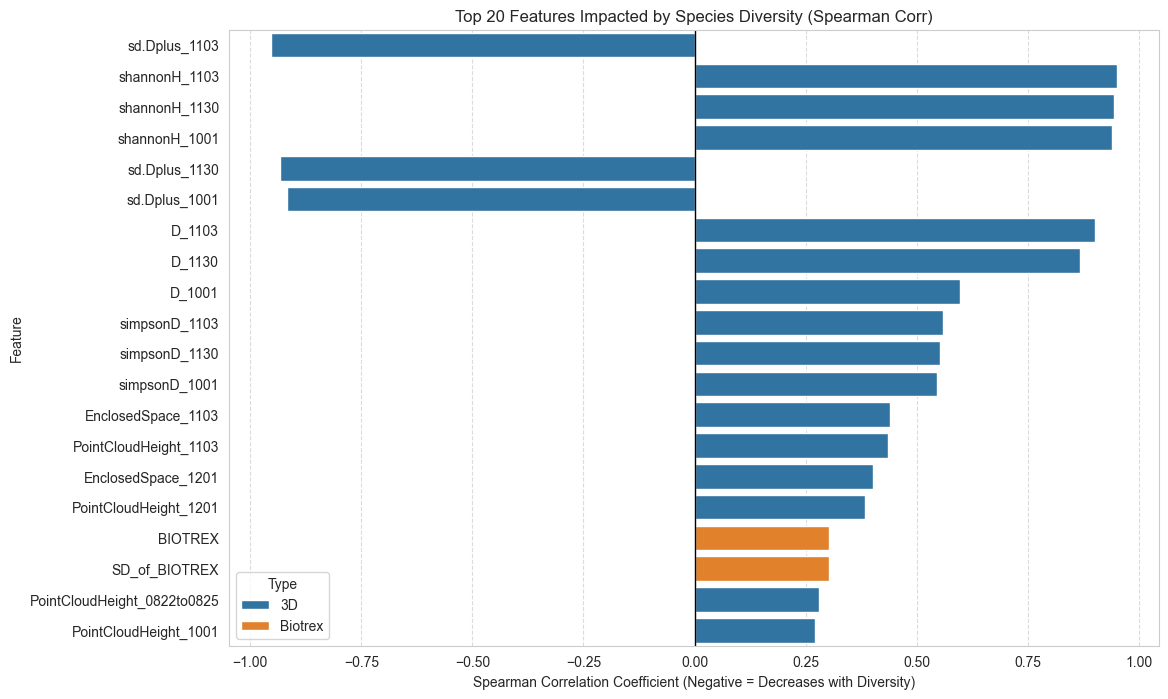

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/1935514660.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/1935514660.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/1935514660.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/1935514660.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

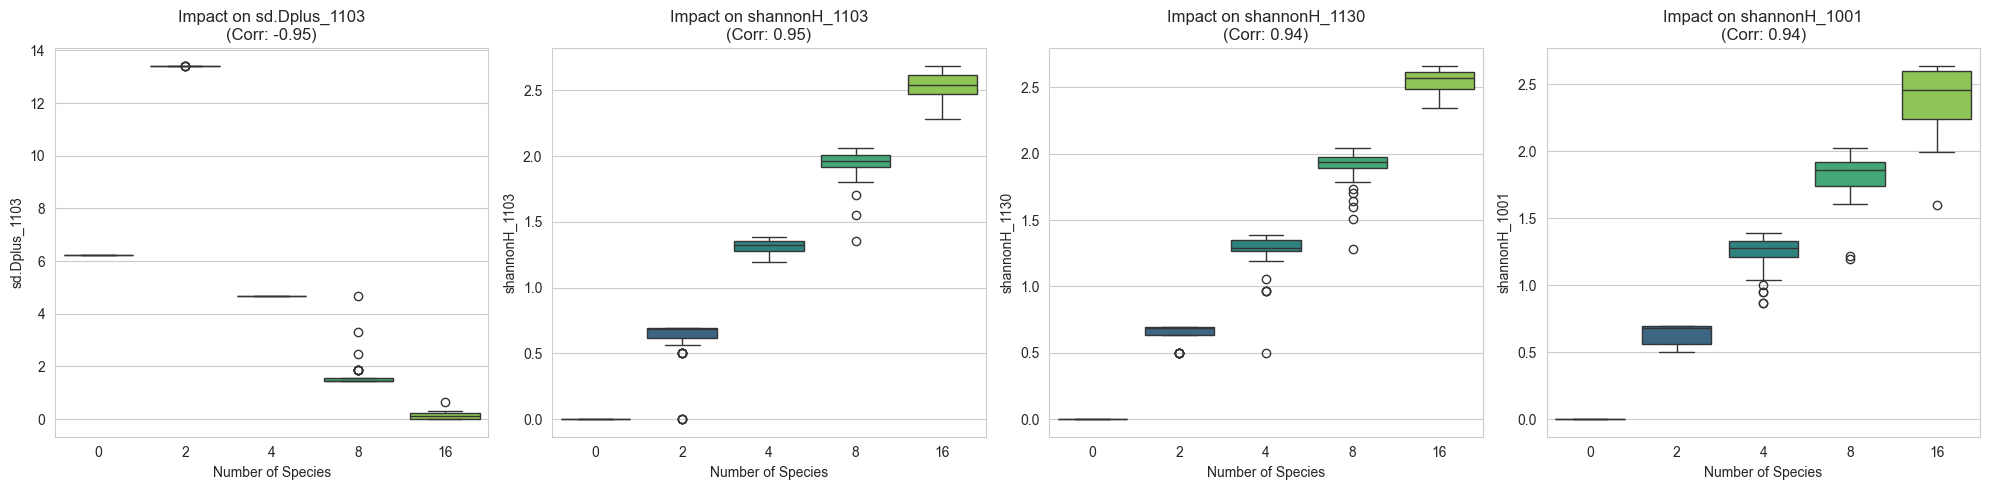

In [28]:
from scipy.stats import spearmanr

# 1. Aggregate all target features into one list
# We exclude the categorical/species one-hot columns from the target list
TARGET_FEATURES = SOIL_FEATURES + BIOTREX_FEATURES + M_3D_FEATURES 

# 2. Calculate Spearman Correlation for all features against #Species
correlation_results = []

for feature in TARGET_FEATURES:
    # Drop NaNs to ensure valid calculation
    temp_df = mesocosm_df[[feature, '#Species']].dropna()
    
    if len(temp_df) > 0:
        corr, p_val = spearmanr(temp_df['#Species'], temp_df[feature])
        correlation_results.append({
            'Feature': feature,
            'Correlation': corr,
            'Abs_Correlation': abs(corr), # Useful for sorting
            'P_Value': p_val,
            'Type': 'Metabolome' if feature in METABOLOME_FEATURES else 
                    ('Soil' if feature in SOIL_FEATURES else 
                    ('Biotrex' if feature in BIOTREX_FEATURES else '3D'))
        })

# Create a DataFrame of results
results_df = pd.DataFrame(correlation_results)

# 3. Filter for statistical significance (p < 0.05) and Sort
significant_results = results_df[results_df['P_Value'] < 0.05].sort_values(by='Abs_Correlation', ascending=False)

# Display top 10 impacted features
print("Top 10 Features most impacted by #Species:")
print(significant_results[['Feature', 'Correlation', 'Type', 'P_Value']].head(10))

# --- PLOTTING ---

# Plot 1: The "Impact Ranking" (Horizontal Bar Chart)
plt.figure(figsize=(12, 8))
# We take the top 20 most correlated features
top_features = significant_results.head(20)

sns.barplot(data=top_features, y='Feature', x='Correlation', hue='Type', dodge=False)
plt.title('Top 20 Features Impacted by Species Diversity (Spearman Corr)')
plt.xlabel('Spearman Correlation Coefficient (Negative = Decreases with Diversity)')
plt.axvline(0, color='black', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Plot 2: Detailed Boxplots for the Top 4 Features
# This shows exactly HOW the data changes as #Species increases
top_4_names = significant_results['Feature'].head(4).tolist()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, feature in enumerate(top_4_names):
    sns.boxplot(data=mesocosm_df, x='#Species', y=feature, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Impact on {feature}\n(Corr: {significant_results.iloc[i]['Correlation']:.2f})")
    axes[i].set_xlabel("Number of Species")

plt.tight_layout()
plt.show()

TODO : DETECT the species diversity, wich spicies number affecting the diversity
Is there a features taht is very affected by the diversity 
Is the species specific is affecting soil data 
What species is very important to BIOTREX, 
How to improve BIOTREX without using Fertilizer

## 1.4 Multiple Regression Analysis

For the dependent variables, several soil indicators such as BIOTREX and characteristic metabolome compounds

## 2. `metagenome_mesocosm_df` analysis

In [29]:
metagenome_mesocosm_df["nb_species"] = metagenome_mesocosm_df["#Species"]

### How is soil chemistry / metabolome / 3D structure correlated with microbial diversity?

In [30]:
def aggregate_qd(df, prefix):
    cols = [c for c in df.columns if c.startswith(prefix) and "_qD_" in c]
    return df[cols].mean(axis=1)

metagenome_mesocosm_df["Shannon_mean"] = aggregate_qd(metagenome_mesocosm_df, "Shannon")
metagenome_mesocosm_df["Simpson_mean"] = aggregate_qd(metagenome_mesocosm_df, "Simpson")
metagenome_mesocosm_df["Richness_mean"] = aggregate_qd(metagenome_mesocosm_df, "Richness")

targets = ["Shannon_mean", "Simpson_mean", "Richness_mean"]

for t in targets:
    for primer in ["18S", "ITS1", "V4"]:
        metagenome_mesocosm_df[f"{t}_{primer}"] = (
            metagenome_mesocosm_df[t] * metagenome_mesocosm_df[f"Primer_{primer}"]
        )

X = (
    BIOTREX_FEATURES +
    SOIL_FEATURES +
    SPECIES_FEATURES +
    CATEGORY_FEATURES
)
Y = [
    "Shannon_mean_18S", "Shannon_mean_ITS1", "Shannon_mean_V4",
    "Richness_mean_18S", "Richness_mean_ITS1", "Richness_mean_V4"
]

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 30813 (\N{CJK UNIFIED IDEOGRAPH-785D}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 37240 (\N{CJK UNIFIED IDEOGRAPH-9178}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 24907 (\N{CJK UNIFIED IDEOGRAPH-614B}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 31378 (\N{CJK UNIFIED IDEOGRAPH-7A92}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 32032 (\N{CJK UNIFIED IDEOGRAPH-7D20}) missing from font(s) Arial.

/opt/an

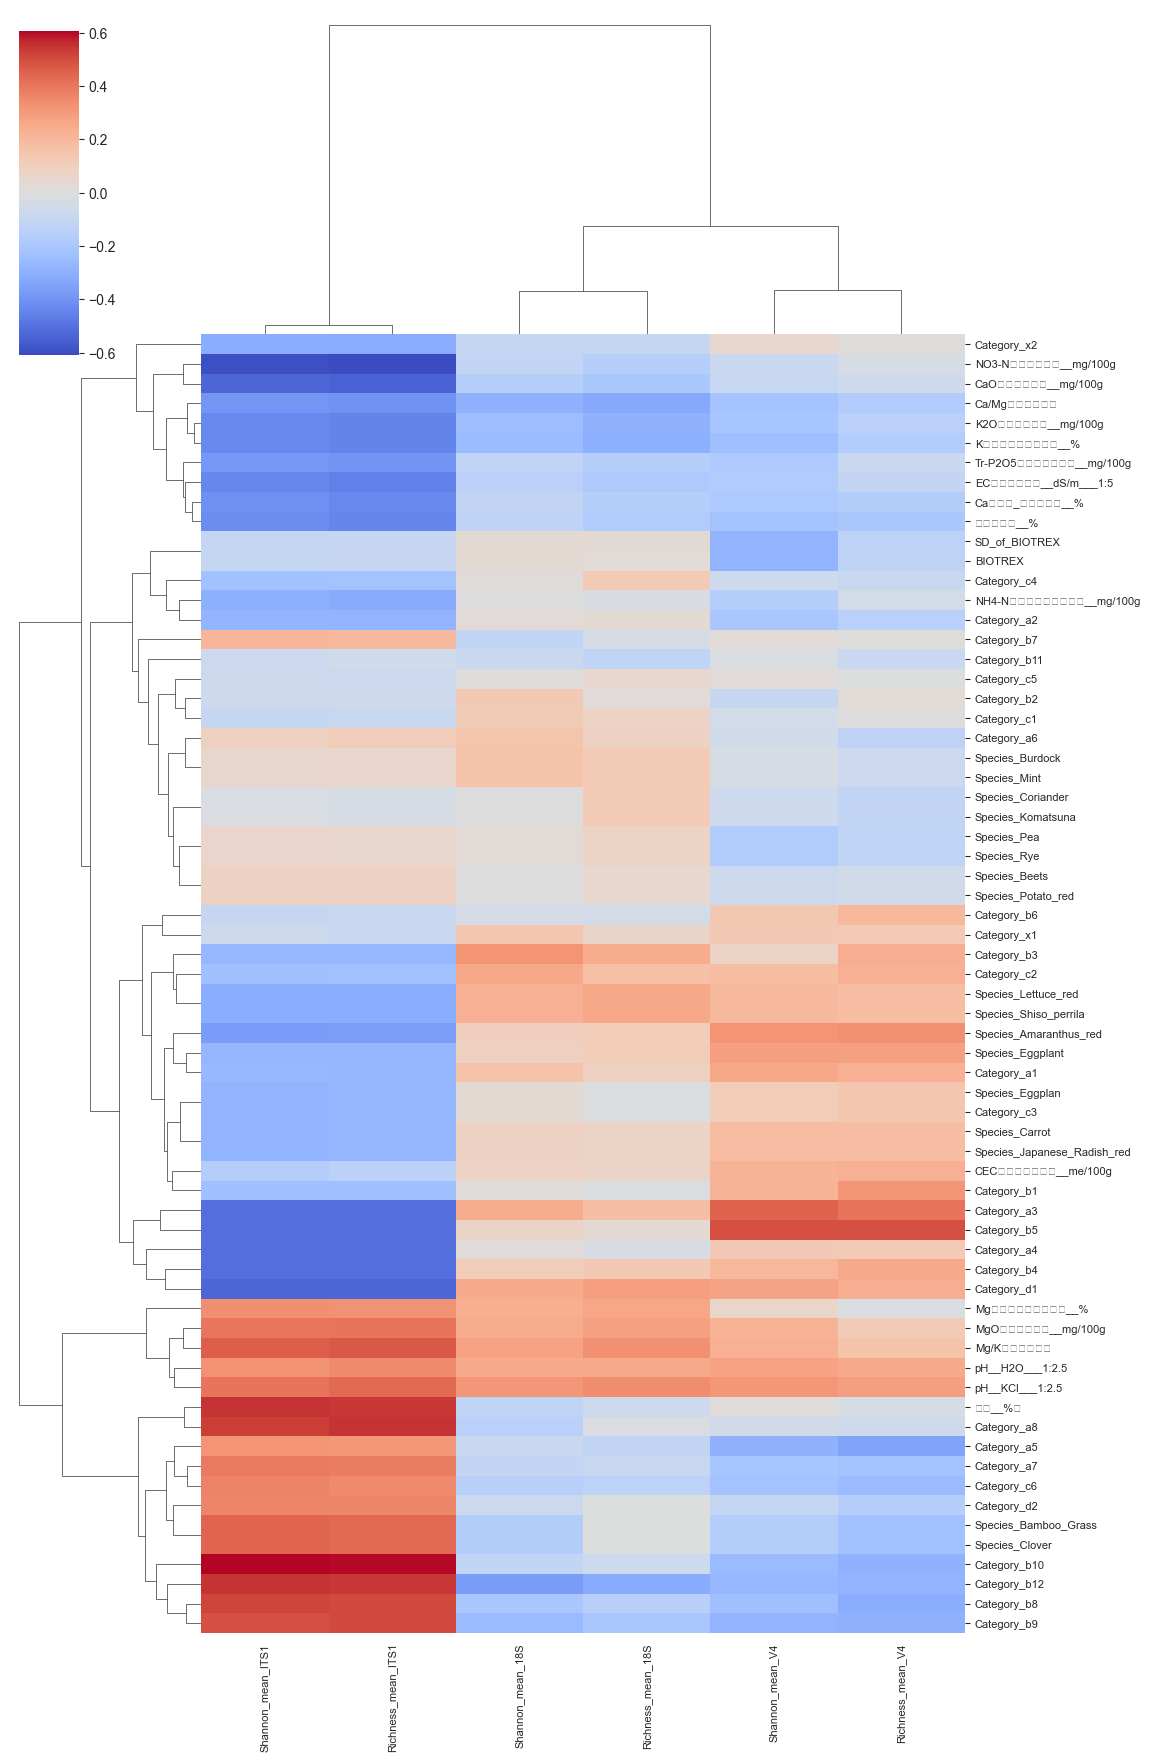

In [31]:
corr = (
    metagenome_mesocosm_df[X + Y]
    .corr(method="spearman")
    .loc[X, Y] * 7
)

g = sns.clustermap(
    corr,
    cmap="coolwarm",
    center=0,
    figsize=(12, 18),
    xticklabels=True,
    yticklabels=True
)

# --- Force all x labels ---
plt.setp(
    g.ax_heatmap.get_xticklabels(),
    rotation=90,
    ha="center",
    fontsize=8
)

# --- Force all y labels ---
plt.setp(
    g.ax_heatmap.get_yticklabels(),
    rotation=0,
    fontsize=8
)

plt.show()

## Clustermap
Tree structure out of correlational pattern
→Analyse at the species diversity levels a*, b*, c*, d* (a*=a1+a2+…+a8) « meta-sample »
Add the analysis of tea metabolome data vs. other variables (including the species diversity levels a*, b*, c*, d*)

In [32]:
diversity_map = {
    0: "x",
    2: "a",
    4: "b",
    8: "c",
    16: "d"
}

metagenome_mesocosm_df["diversity_level"] = (
    metagenome_mesocosm_df["nb_species"].map(diversity_map)
)

diversity_dummies = pd.get_dummies(
    metagenome_mesocosm_df["diversity_level"],
    prefix="div"
)

metagenome_mesocosm_df = pd.concat(
    [metagenome_mesocosm_df, diversity_dummies],
    axis=1
)

DIVERSITY_FEATURES = diversity_dummies.columns.tolist()

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 12491 (\N{KATAKANA LETTER NI}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 24907 (\N{CJK UNIFIED IDEOGRAPH-614B}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.

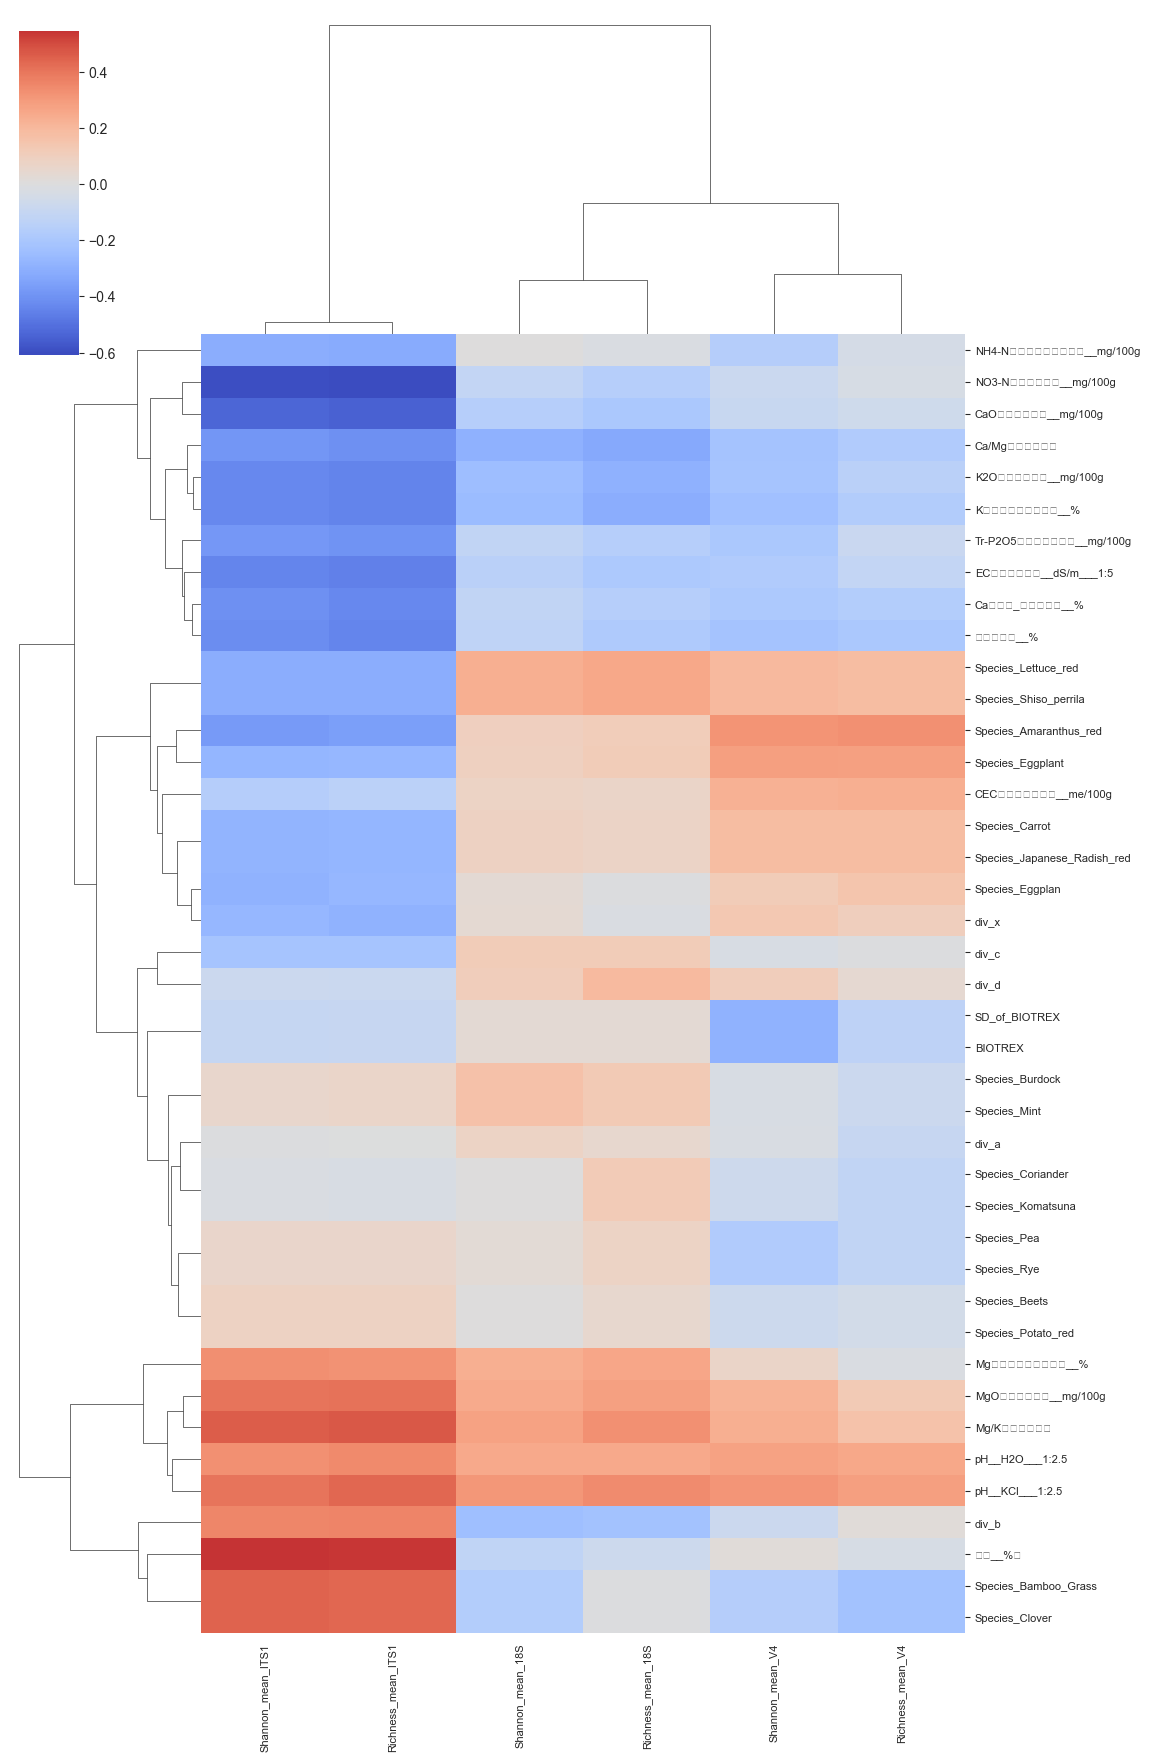

In [33]:
X = (
    BIOTREX_FEATURES +
    SOIL_FEATURES +
    SPECIES_FEATURES +
    DIVERSITY_FEATURES
)
Y = [
    "Shannon_mean_18S", "Shannon_mean_ITS1", "Shannon_mean_V4",
    "Richness_mean_18S", "Richness_mean_ITS1", "Richness_mean_V4"
]

corr = (
    metagenome_mesocosm_df[X + Y]
    .corr(method="spearman")
    .loc[X, Y] * 7
)

g = sns.clustermap(
    corr,
    cmap="coolwarm",
    center=0,
    figsize=(12, 18),
    xticklabels=True,
    yticklabels=True
)

# --- Force all x labels ---
plt.setp(
    g.ax_heatmap.get_xticklabels(),
    rotation=90,
    ha="center",
    fontsize=8
)

# --- Force all y labels ---
plt.setp(
    g.ax_heatmap.get_yticklabels(),
    rotation=0,
    fontsize=8
)

plt.show()

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/603819492.py:61: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/603819492.py:61: UserWarning:

Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/603819492.py:61: UserWarning:

Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/603819492.py:61: UserWarning:

Glyph 20253 (\N{CJK UNIFIED IDEOGRAPH-4F1D}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/603819492.py:61: UserWarning:

Glyph 23566 (\N{CJK UNIFIED IDEOGRAPH-5C0E}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/603819492.py:61: UserWarning:

Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(

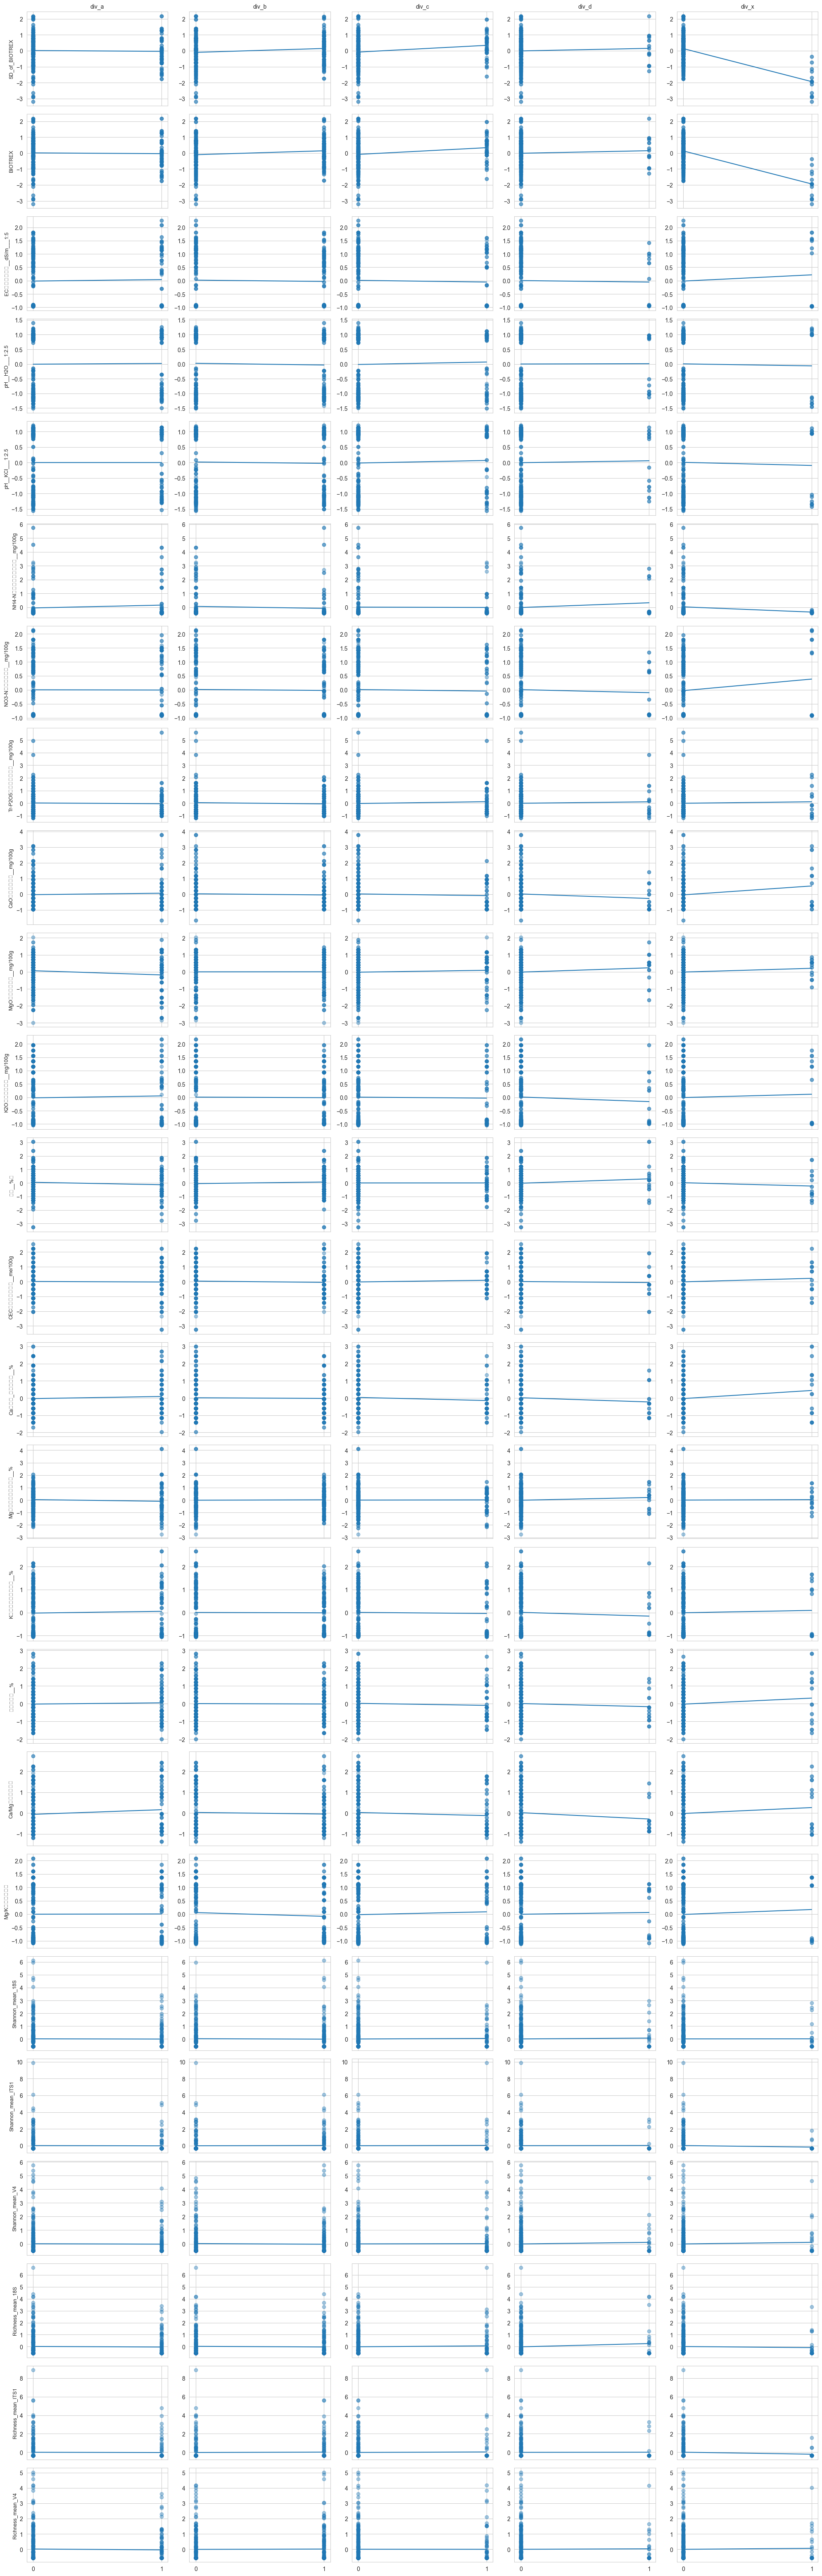

In [34]:
OUTPUT_FEATURES = BIOTREX_FEATURES + SOIL_FEATURES + ["Shannon_mean_18S", "Shannon_mean_ITS1", "Shannon_mean_V4","Richness_mean_18S", "Richness_mean_ITS1", "Richness_mean_V4"]

n_rows = len(OUTPUT_FEATURES)
n_cols = len(DIVERSITY_FEATURES)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 2.5 * n_rows),
    sharex=True
)

if n_rows == 1:
    axes = axes[np.newaxis, :]

results = []

for i, y_col in enumerate(OUTPUT_FEATURES):
    for j, d_col in enumerate(DIVERSITY_FEATURES):

        x = metagenome_mesocosm_df[d_col]
        y = metagenome_mesocosm_df[y_col]

        mask = x.notna() & y.notna()
        x = x[mask]
        y = y[mask]

        if x.nunique() < 2:
            slope = np.nan
            intercept = np.nan
        else:
            y_std = (y - y.mean()) / y.std(ddof=0)
            res = linregress(x, y_std)
            slope = res.slope
            intercept = res.intercept

        # Store result
        results.append({
            "output_feature": y_col,
            "diversity_feature": d_col,
            "slope": slope
        })

        # Plot
        ax = axes[i, j]
        ax.scatter(x, y_std, alpha=0.4)

        if not np.isnan(slope):
            x_line = np.array([0, 1])
            y_line = intercept + slope * x_line
            ax.plot(x_line, y_line)

        if i == 0:
            ax.set_title(d_col, fontsize=10)

        if j == 0:
            ax.set_ylabel(y_col, fontsize=9)

        ax.set_xticks([0, 1])

plt.tight_layout()
plt.show()


/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 22633 (\N{CJK UNIFIED IDEOGRAPH-5869}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 25563 (\N{CJK UNIFIED IDEOGRAPH-63DB}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from font(s) Arial.

/opt/an

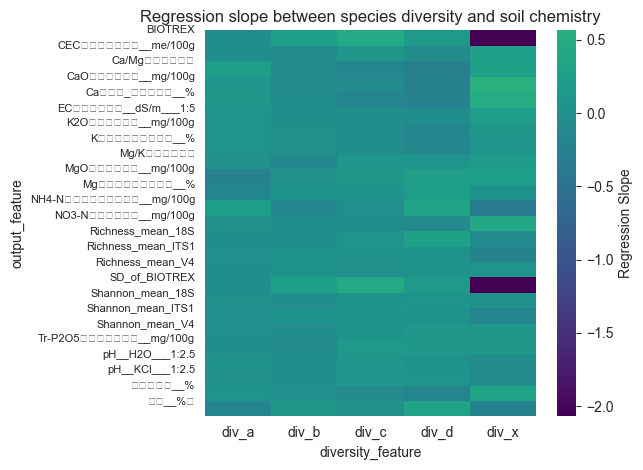

In [35]:
slopes_df = pd.DataFrame(results)
slopes_matrix = slopes_df.pivot(
    index="output_feature",
    columns="diversity_feature",
    values="slope"
)

ax = sns.heatmap(
    slopes_matrix,
    cmap="viridis",   # small typo fixed
    center=0,
    cbar_kws={"label": "Regression Slope"},
    xticklabels=True,
    yticklabels=True
)

# Force ALL x ticks
# ax.set_xticks(range(slopes_matrix.shape[1]))
# ax.set_xticklabels(
#     slopes_matrix.columns,
#     rotation=90,
#     ha="center",
#     fontsize=8
# )

# Force ALL y ticks
ax.set_yticks(range(slopes_matrix.shape[0]))
ax.set_yticklabels(
    slopes_matrix.index,
    rotation=0,
    fontsize=8
)
plt.title("Regression slope between species diversity and soil chemistry")
plt.tight_layout()
plt.show()


/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 22633 (\N{CJK UNIFIED IDEOGRAPH-5869}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 25563 (\N{CJK UNIFIED IDEOGRAPH-63DB}) missing from font(s) Arial.

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from font(s) Arial.

/opt/an

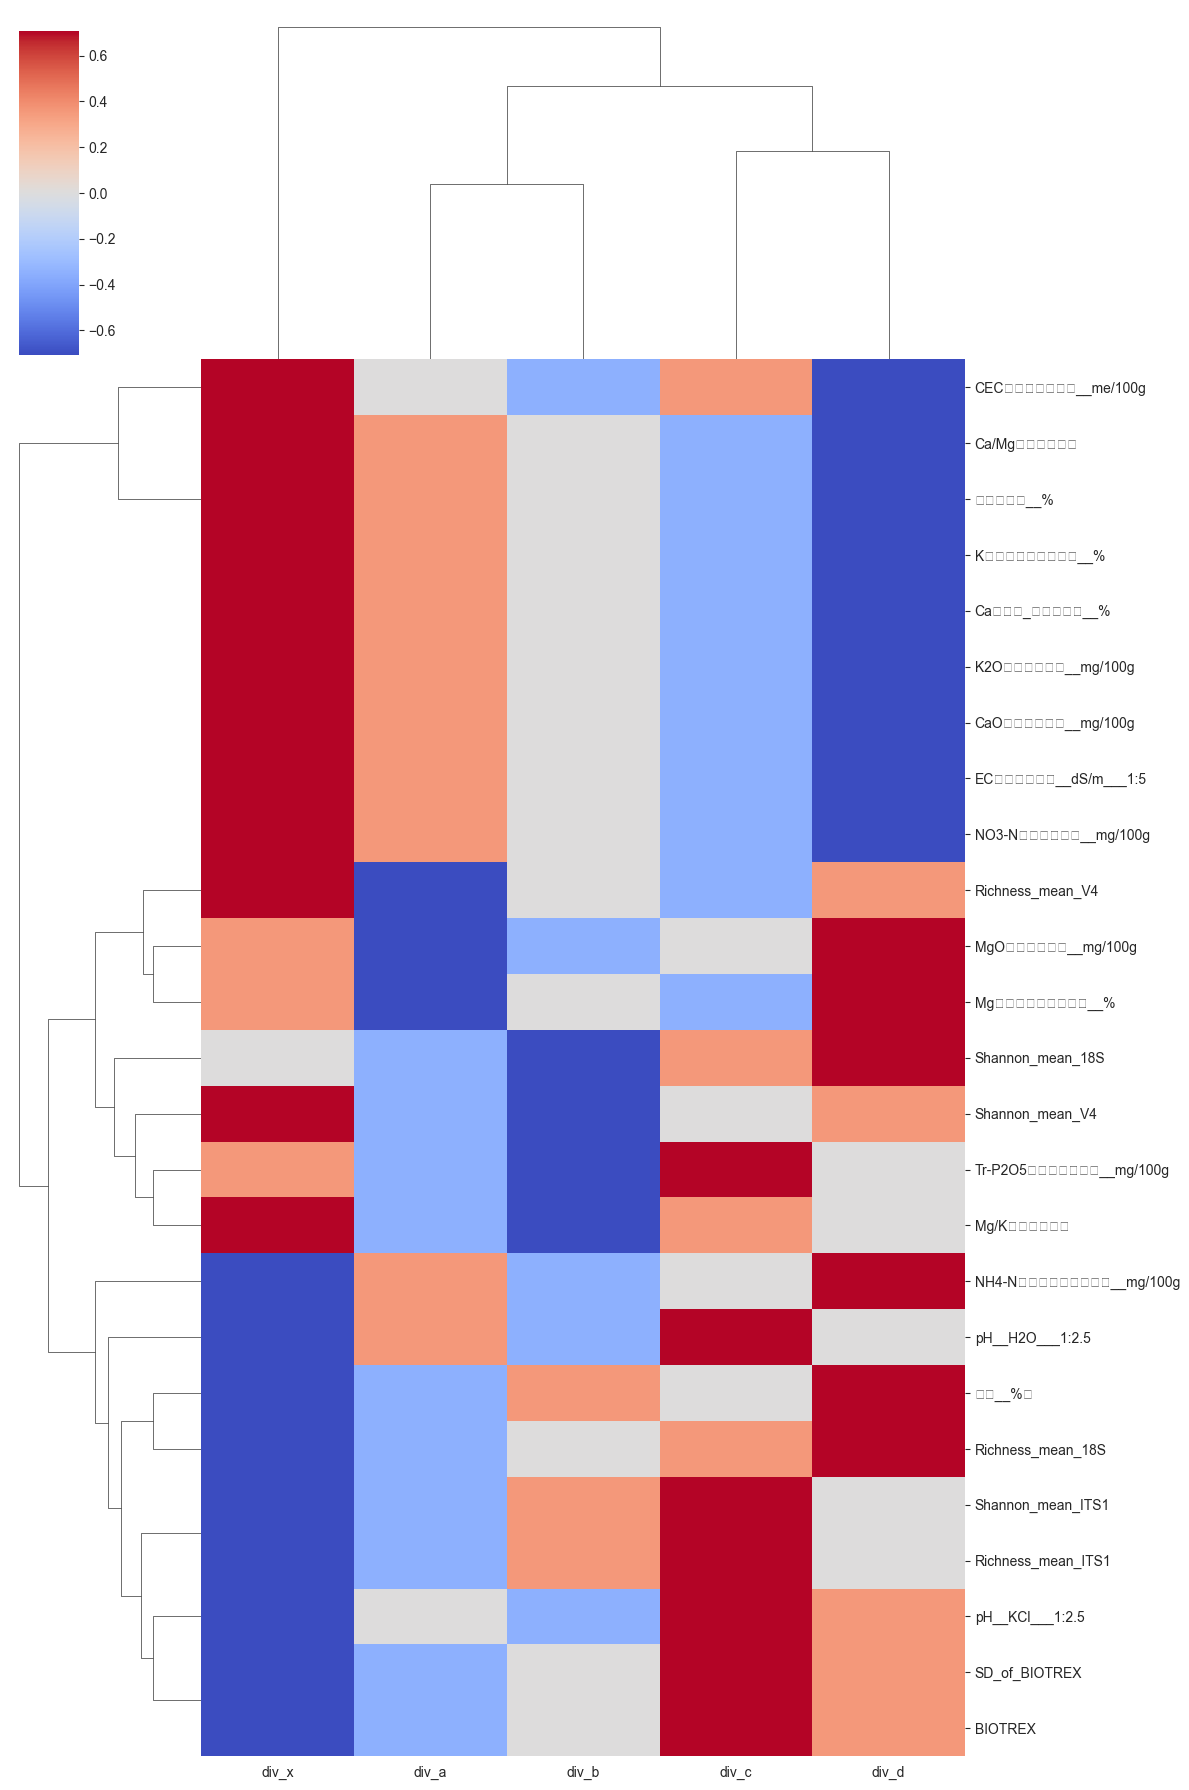

In [36]:
DIVERSITY_FEATURES = diversity_dummies.columns.tolist()

X = (
    BIOTREX_FEATURES +
    SOIL_FEATURES +
    ["Shannon_mean_18S", "Shannon_mean_ITS1", "Shannon_mean_V4",
    "Richness_mean_18S", "Richness_mean_ITS1", "Richness_mean_V4"]
)

Y = (
    DIVERSITY_FEATURES
    )

meta_df = (
    metagenome_mesocosm_df
    .groupby("diversity_level")
    .mean(numeric_only=True)
)

corr_meta = (
    meta_df[X + Y]
    .corr(method="spearman")
    .loc[X, Y]
)

g = sns.clustermap(
    corr_meta,
    cmap="coolwarm",
    center=0,
    figsize=(12, 18),
    xticklabels=True,
    yticklabels=True
)


### Do plant species structure microbial diversity?

<Axes: >

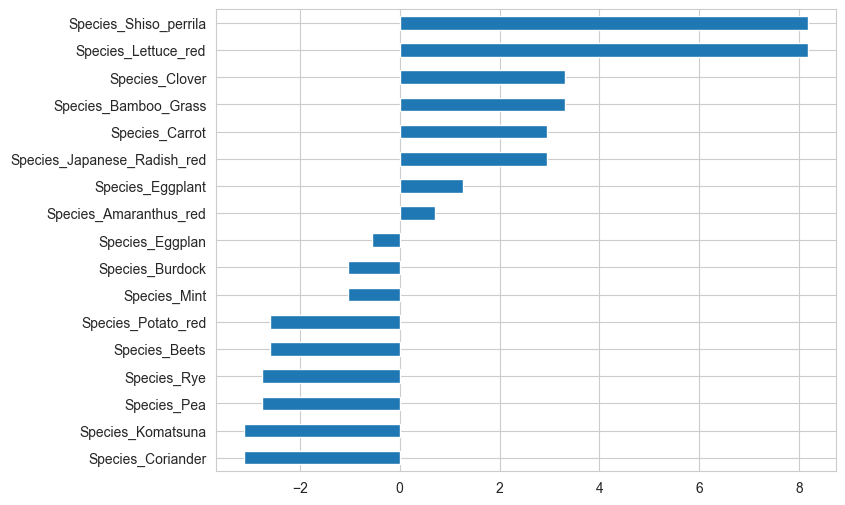

In [37]:
import statsmodels.formula.api as smf

formula = "Shannon_mean_V4 ~ " + " + ".join(SPECIES_FEATURES)
model = smf.ols(formula, data=metagenome_mesocosm_df).fit()

effects = model.params[SPECIES_FEATURES]
effects.sort_values().plot.barh(figsize=(8, 6))

### Which species improve soil richness & BIOTREX

<Axes: >

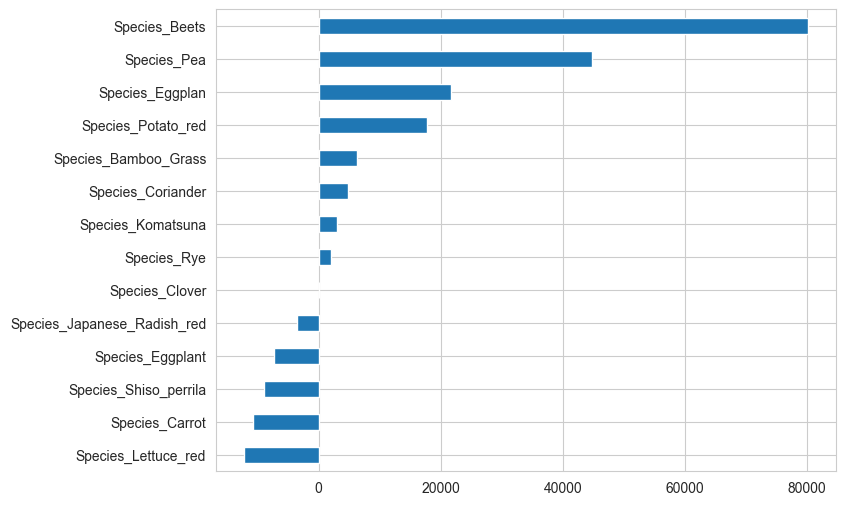

In [38]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = metagenome_mesocosm_df[SPECIES_FEATURES]
y = metagenome_mesocosm_df["BIOTREX"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=5))
])

pipe.fit(X, y)

coef = pd.Series(
    pipe.named_steps["lasso"].coef_,
    index=SPECIES_FEATURES
)

coef[coef != 0].sort_values().plot.barh(figsize=(8, 6))


### Species diversity (number of species) vs metagenome

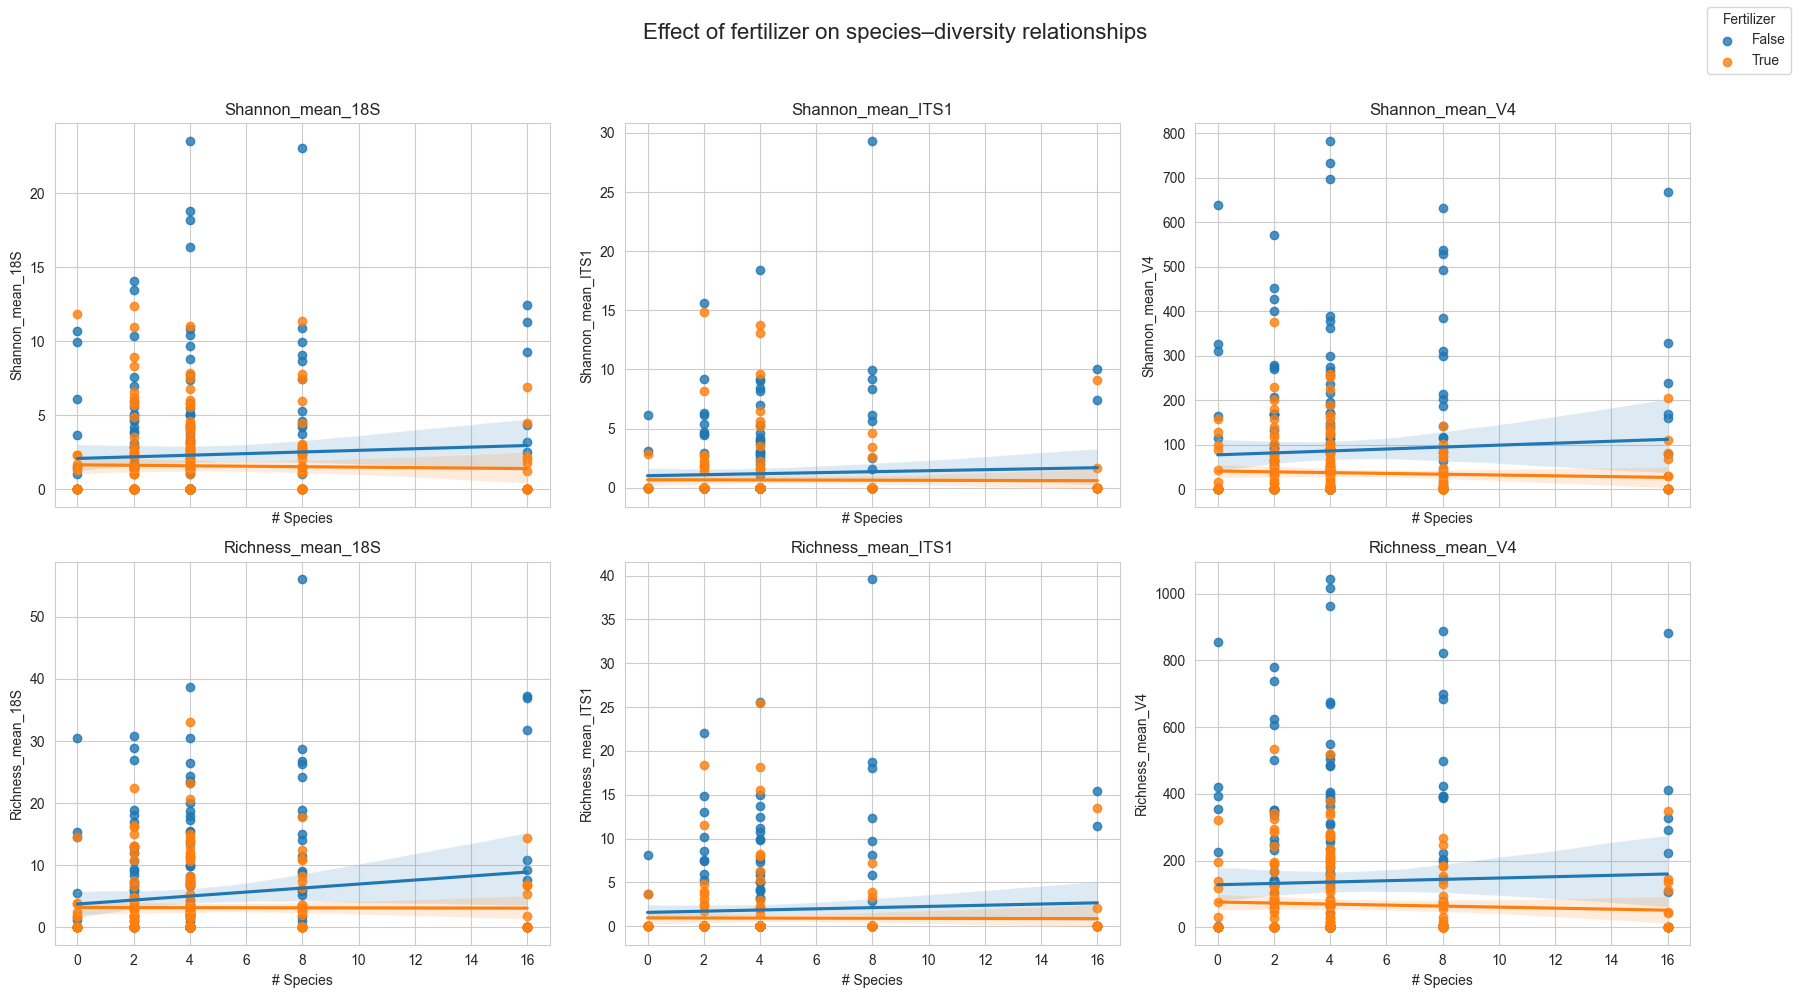

In [39]:
METAGENOME_FEATURES = ["Shannon_mean_18S", "Shannon_mean_ITS1", "Shannon_mean_V4", "Richness_mean_18S", "Richness_mean_ITS1", "Richness_mean_V4"]

# Number of features
n_features = len(METAGENOME_FEATURES)

# Grid size (adjust n_cols if you want)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(6 * n_cols, 5 * n_rows),
    sharex=True
)

# Flatten axes for easy indexing
axes = axes.flatten()

for i, feature in enumerate(METAGENOME_FEATURES):
    ax = axes[i]

    for fert, df_sub in metagenome_mesocosm_df.groupby("Fertilizer"):
        sns.regplot(
            x="#Species",
            y=feature,
            data=df_sub,
            scatter=True,
            ci=95,
            label=fert,
            ax=ax
        )

    ax.set_title(feature)
    ax.set_xlabel("# Species")
    ax.set_ylabel(feature)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global legend (cleaner than repeating it)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Fertilizer", loc="upper right")

fig.suptitle("Effect of fertilizer on species–diversity relationships", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


### Species diversity vs. Metagenomic diversity

### Which soil features are most affected by diversity

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 30707 (\N{CJK UNIFIED IDEOGRAPH-77F3}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 28784 (\N{CJK UNIFIED IDEOGRAPH-7070}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(

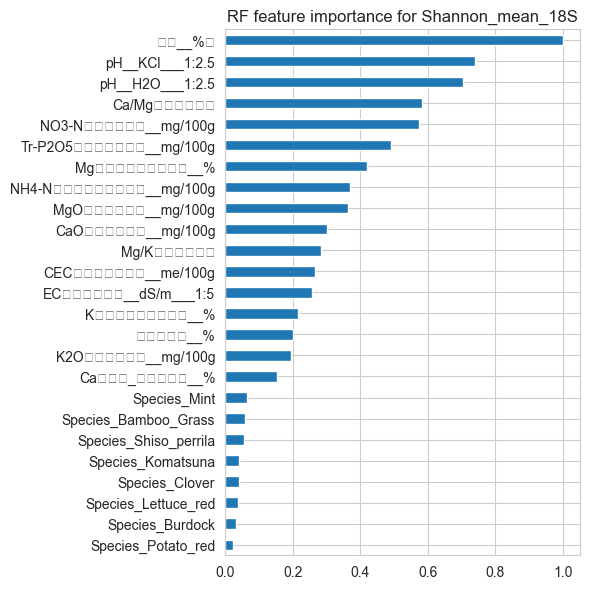

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 30707 (\N{CJK UNIFIED IDEOGRAPH-77F3}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 28784 (\N{CJK UNIFIED IDEOGRAPH-7070}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(

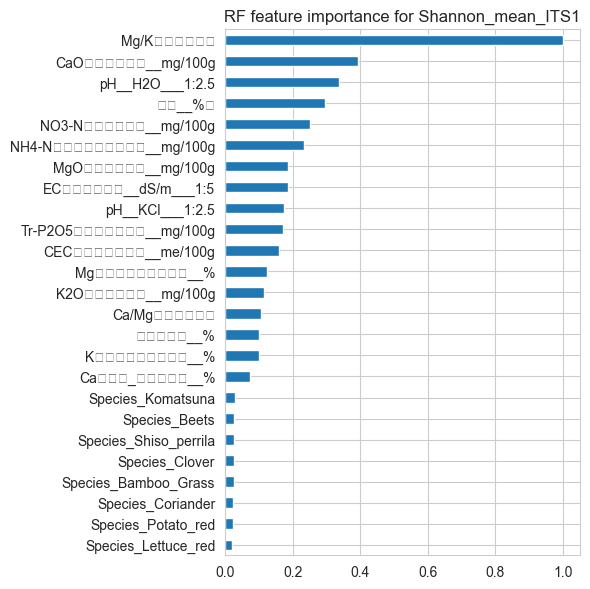

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 30707 (\N{CJK UNIFIED IDEOGRAPH-77F3}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 28784 (\N{CJK UNIFIED IDEOGRAPH-7070}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 22633 (\N{CJK UNIFIED IDEOGRAPH-5869}) missing f

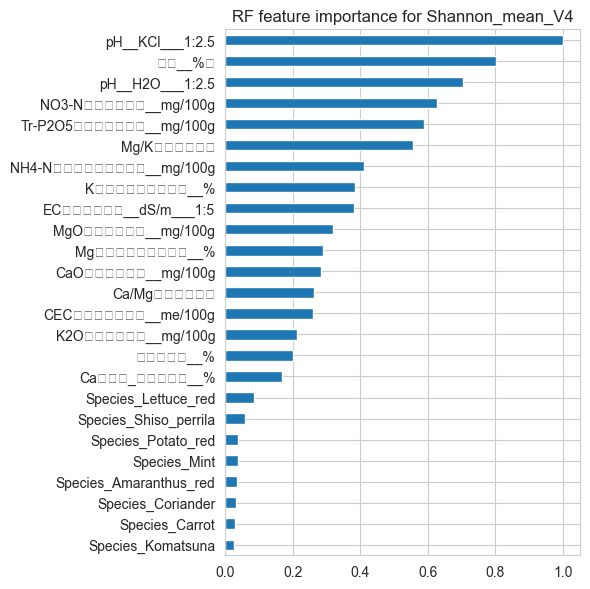

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 30707 (\N{CJK UNIFIED IDEOGRAPH-77F3}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 28784 (\N{CJK UNIFIED IDEOGRAPH-7070}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 22633 (\N{CJK UNIFIED IDEOGRAPH-5869}) missing f

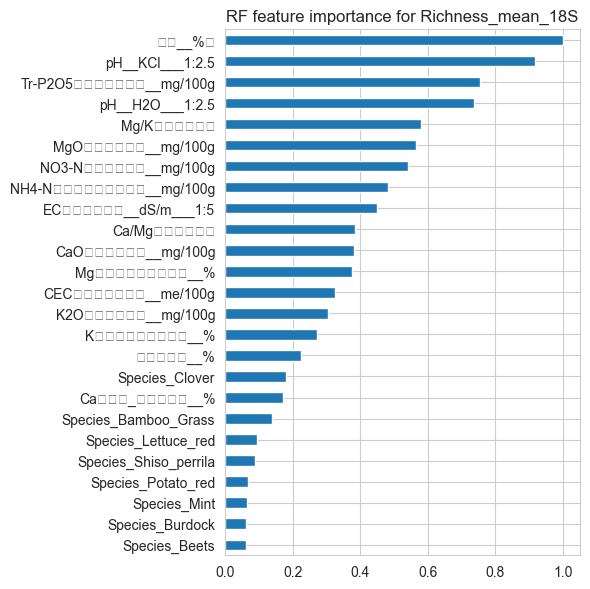

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 30707 (\N{CJK UNIFIED IDEOGRAPH-77F3}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 28784 (\N{CJK UNIFIED IDEOGRAPH-7070}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 22633 (\N{CJK UNIFIED IDEOGRAPH-5869}) missing f

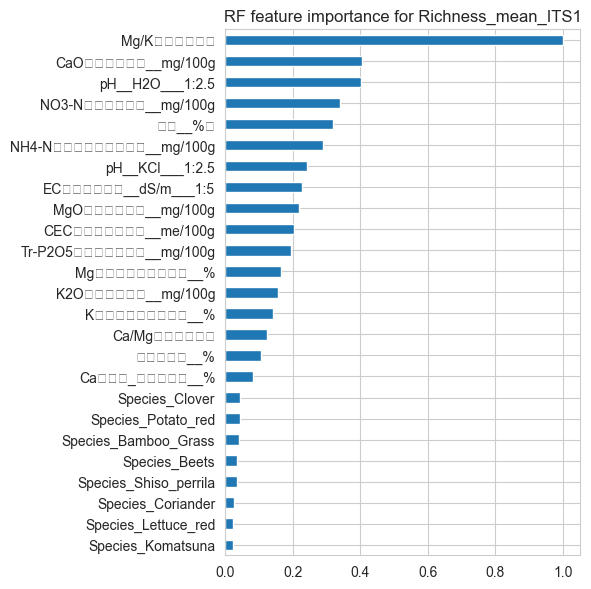

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 30707 (\N{CJK UNIFIED IDEOGRAPH-77F3}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 28784 (\N{CJK UNIFIED IDEOGRAPH-7070}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/527826140.py:32: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(

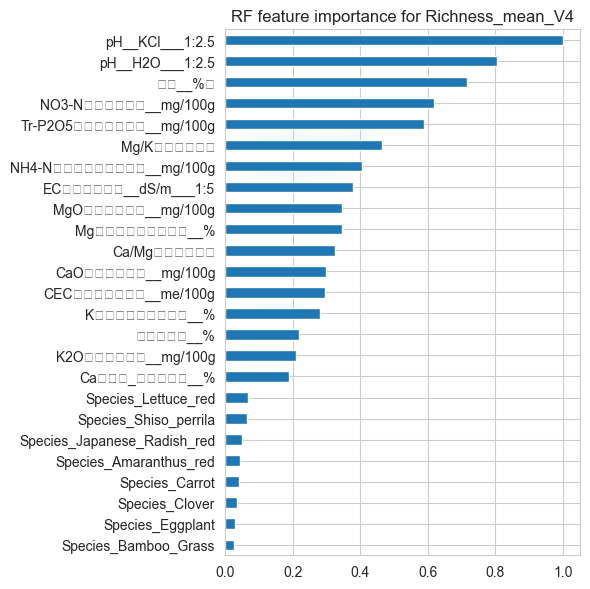

In [40]:
from sklearn.ensemble import RandomForestRegressor

X = metagenome_mesocosm_df[SOIL_FEATURES + SPECIES_FEATURES]

for target in METAGENOME_FEATURES:

    y = metagenome_mesocosm_df[target]

    rf = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X, y)

    importances = pd.Series(
        rf.feature_importances_,
        index=X.columns
    )

    # Min–max normalization to [0, 1]
    importances_norm = (importances - importances.min()) / (
        importances.max() - importances.min()
    )

    importances_top = importances_norm.sort_values().tail(25)

    plt.figure(figsize=(6, 6))
    importances_top.plot.barh()
    plt.title(f"RF feature importance for {target}")

    plt.tight_layout()
    plt.show()
    plt.close()


/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12491 (\N{KATAKANA LETTER NI}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 24907 (\N{CJK UNIFIED IDEOGRAPH-614B}) missing from font(s) Arial.

/var/folders/gl/r

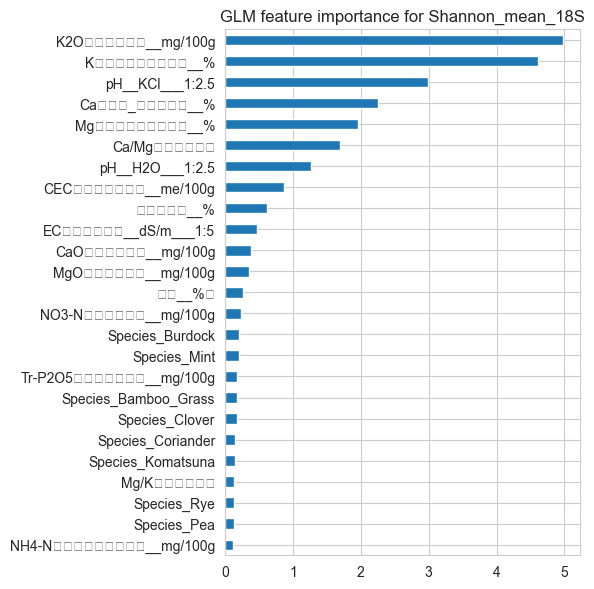

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 25563 (\N{CJK UNIFIED IDEOGRAPH-63DB}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 37324 (\N{CJK UNIFIED IDEOGRAPH-91CC}) missing from

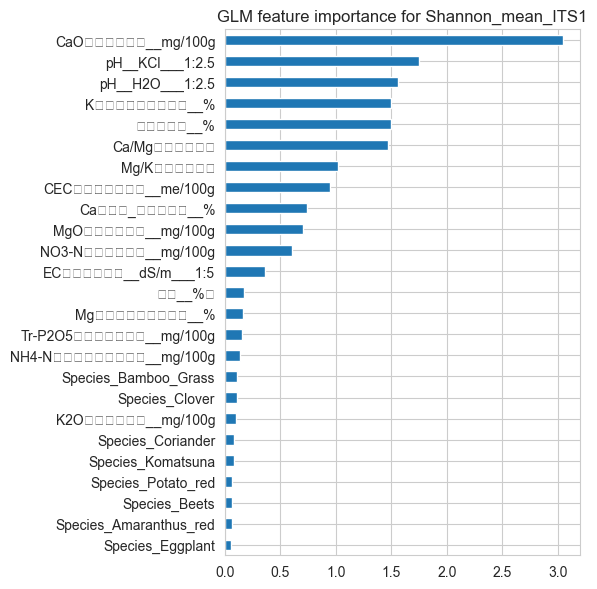

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 33104 (\N{CJK UNIFIED IDEOGRAPH-8150}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 26893 (\N{CJK UNIFIED IDEOGRAPH-690D}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from

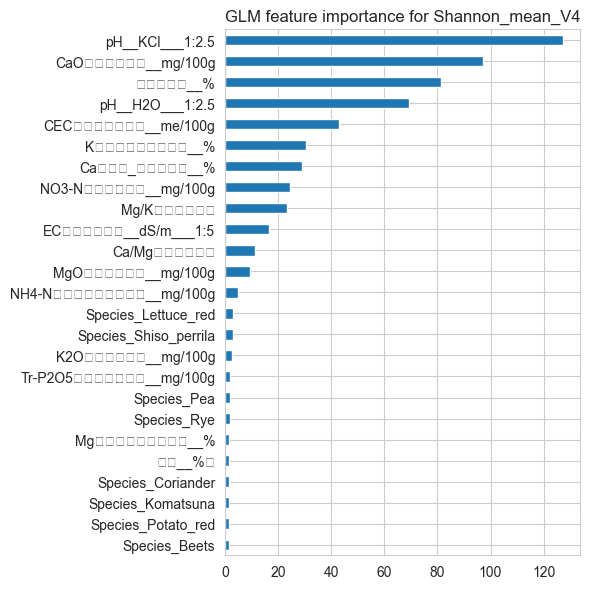

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 33104 (\N{CJK UNIFIED IDEOGRAPH-8150}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 26893 (\N{CJK UNIFIED IDEOGRAPH-690D}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12514 (\N{KATAKANA LETTER MO}) missing from font(s) Arial.

/var/fold

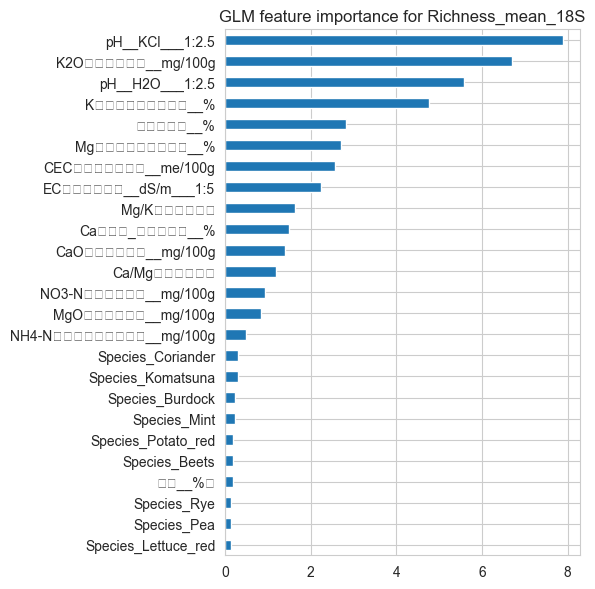

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 21177 (\N{CJK UNIFIED IDEOGRAPH-52B9}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 24907 (\N{CJK UNIFIED IDEOGRAPH-614B}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) Arial.



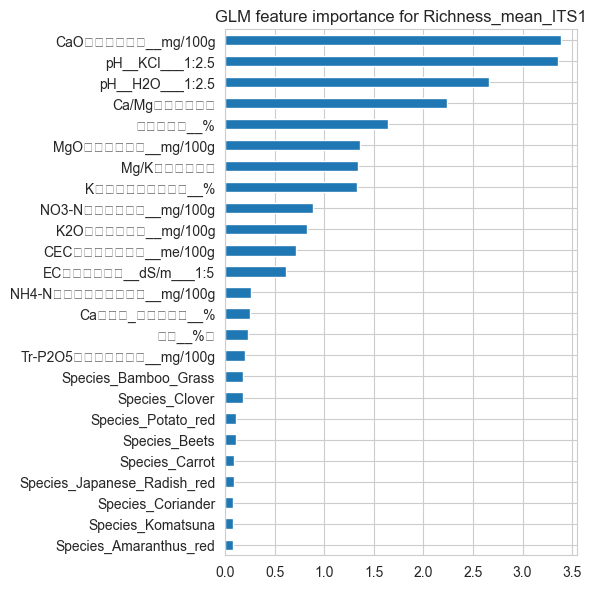

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 33104 (\N{CJK UNIFIED IDEOGRAPH-8150}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 26893 (\N{CJK UNIFIED IDEOGRAPH-690D}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 39165 (\N{CJK UNIFIED IDEOGRAPH-98FD}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) Arial.

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/3576752337.py:56: UserWarning:

Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from

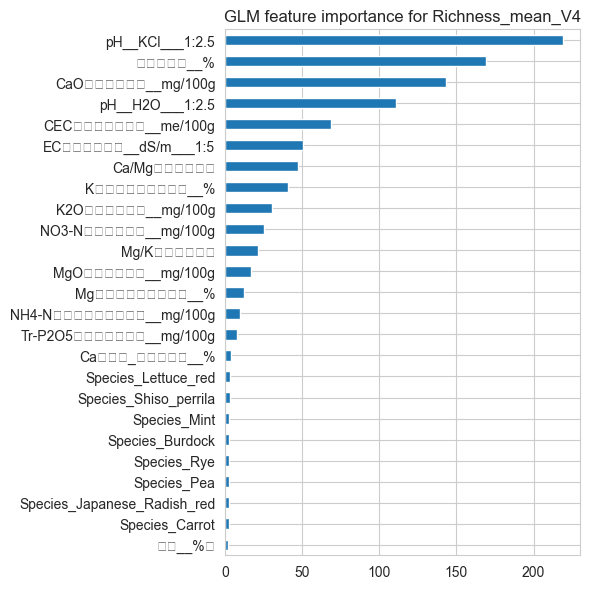

In [41]:
X_raw = metagenome_mesocosm_df[SOIL_FEATURES + SPECIES_FEATURES].copy()

# Force numeric once
X_raw = X_raw.apply(pd.to_numeric, errors="coerce")

for target in METAGENOME_FEATURES:

    y = pd.to_numeric(
        metagenome_mesocosm_df[target],
        errors="coerce"
    )

    # Align and drop NaNs
    valid_idx = X_raw.dropna().index.intersection(y.dropna().index)
    X = X_raw.loc[valid_idx]
    y = y.loc[valid_idx]

    if len(valid_idx) < 10:
        print(f"Skipping {target} (not enough data)")
        continue

    # Standardize predictors (crucial)
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Add intercept
    X_glm = sm.add_constant(X_scaled)

    # Fit GLM
    glm = sm.GLM(
        y,
        X_glm,
        family=sm.families.Gaussian()
    )

    res = glm.fit()

    # Feature importance = |standardized coefficients|
    glm_importance = (
        res.params
        .drop("const")
        .abs()
        .sort_values()
        .tail(25)
    )

    # Plot
    plt.figure(figsize=(6, 6))
    glm_importance.plot.barh()
    plt.title(f"GLM feature importance for {target}")

    plt.tight_layout()
    plt.show()
    plt.close()


### Best species for biotrex and soil richness

In [42]:
# --- Targets ---
TARGET = "BIOTREX"  # adapt if your column name differs

# --- Mediator ---
MICROBIAL_FEATURE = "Richness_mean_V4"

# --- Feature blocks ---
X_species = SPECIES_FEATURES
X_metabolome = METABOLOME_FEATURES

X_all = (
    X_species +
    [MICROBIAL_FEATURE] +
    X_metabolome
)

# --- Drop missing values ---
df = metagenome_mesocosm_df.dropna(
    subset=[TARGET, MICROBIAL_FEATURE]
).copy()

from sklearn.ensemble import GradientBoostingRegressor

X = df[X_all]
y = df[TARGET]

model = GradientBoostingRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.03,
    random_state=42
)

model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.03, n_estimators=500, random_state=42)

<Axes: title={'center': 'Species Feature Importance for BIOTREX Prediction (SHAP)'}>

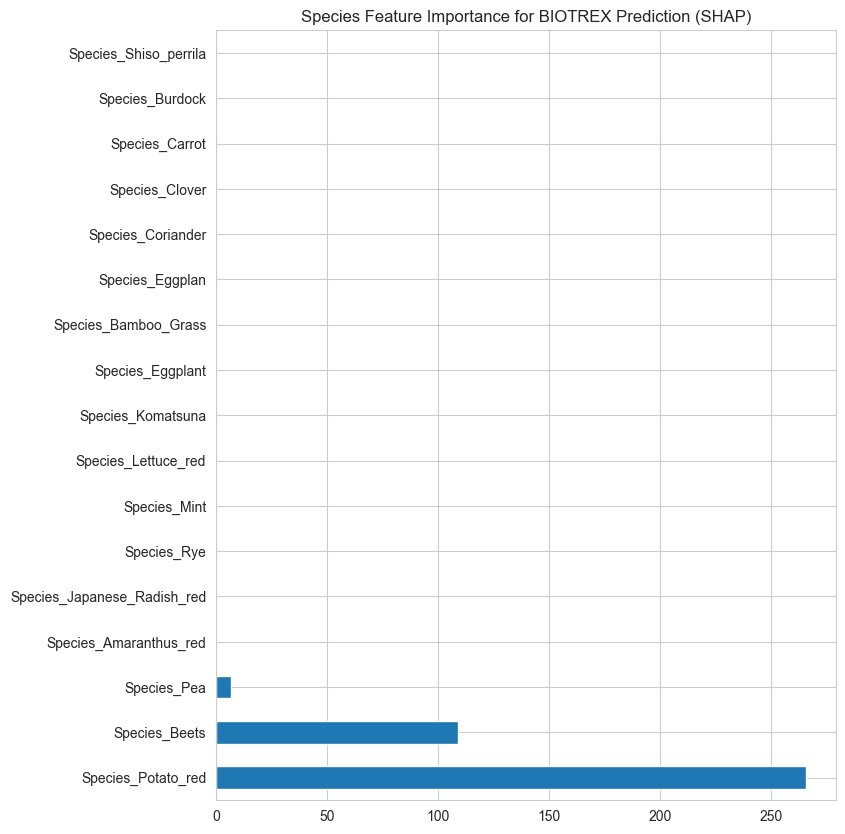

In [43]:
# Global importance with SHAP : species that help BIOTREX

explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap_species = pd.Series(
    np.abs(shap_values.values[:, :len(X_species)]).mean(axis=0),
    index=X_species
).sort_values(ascending=False)

shap_species.plot.barh(figsize=(8, 10), title="Species Feature Importance for BIOTREX Prediction (SHAP)")


#### Identify species that act THROUGH microbial richness

In [44]:
X_mediator = df[X_species + X_metabolome]
y_mediator = df[MICROBIAL_FEATURE]

mediator_model = GradientBoostingRegressor(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.05,
    random_state=42
)

mediator_model.fit(X_mediator, y_mediator)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=400, random_state=42)

In [45]:
explainer_m = shap.Explainer(mediator_model, X_mediator)
shap_mediator = explainer_m(X_mediator)

shap_species_to_microbes = pd.Series(
    np.abs(shap_mediator.values[:, :len(X_species)]).mean(axis=0),
    index=X_species
).sort_values(ascending=False)

shap_species_to_microbes.head(10)


Species_Coriander        0.0004
Species_Mint             0.0001
Species_Potato_red       0.0000
Species_Rye              0.0000
Species_Komatsuna        0.0000
Species_Lettuce_red      0.0000
Species_Burdock          0.0000
Species_Amaranthus_red   0.0000
Species_Pea              0.0000
Species_Eggplant         0.0000
dtype: float64

In [46]:
# Mean absolute SHAP for metabolome
shap_metabolome = np.abs(
    shap_values.values[:, -len(X_metabolome):]
).mean(axis=1)

df["metabolome_dependence"] = shap_metabolome

In [47]:
causal_score = (
    shap_species
    + shap_species_to_microbes
)

causal_df = pd.DataFrame({
    "Species": causal_score.index,
    "Causal_score": causal_score.values
}).sort_values("Causal_score", ascending=False)

causal_df.head(10)


Species  Causal_score
14      Species_Potato_red      265.9020
2            Species_Beets      108.9970
13             Species_Pea        6.7663
6        Species_Coriander        0.0004
12            Species_Mint        0.0001
15             Species_Rye        0.0000
10       Species_Komatsuna        0.0000
11     Species_Lettuce_red        0.0000
3          Species_Burdock        0.0000
0   Species_Amaranthus_red        0.0000

## Annexe

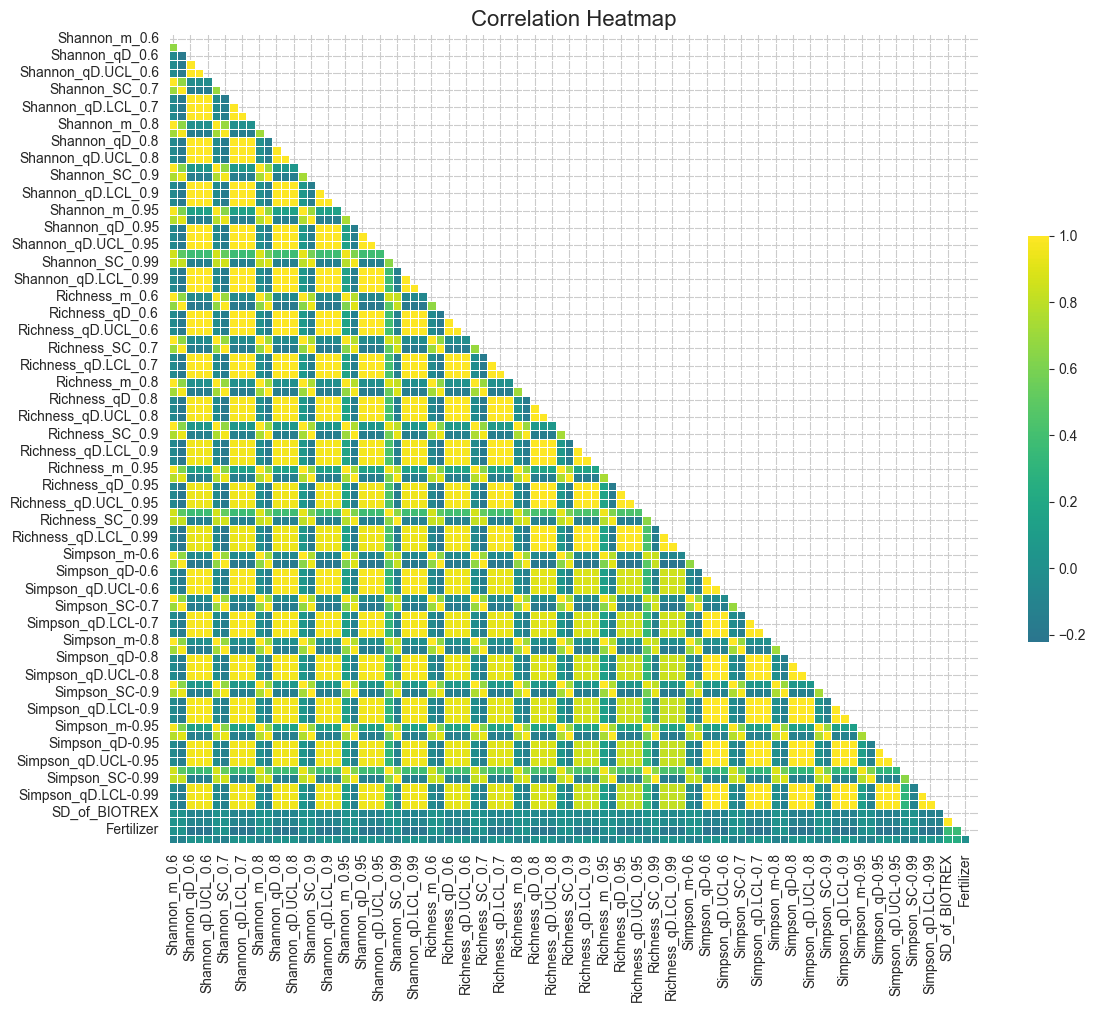


PCA explained variance (first components):

    PC  ExplainedVarianceRatio  ExplainedVariancePct  CumulativePct
0  PC1                  0.5603               56.0344        56.0344
1  PC2                  0.3162               31.6182        87.6526
2  PC3                  0.0472                4.7237        92.3763
3  PC4                  0.0260                2.6017        94.9779
4  PC5                  0.0216                2.1593        97.1372
5  PC6                  0.0103                1.0303        98.1675
6  PC7                  0.0074                0.7370        98.9045


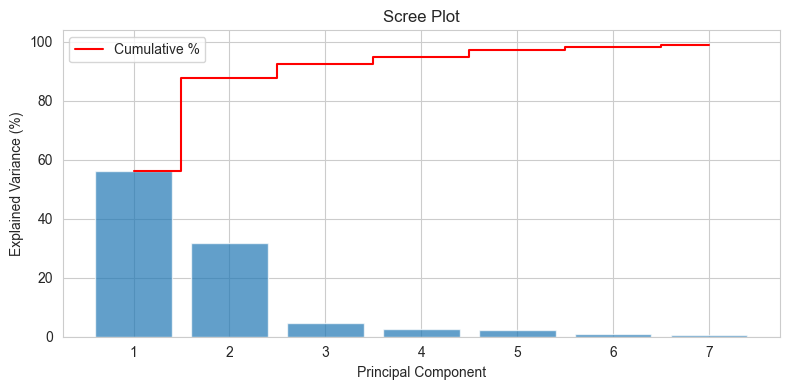

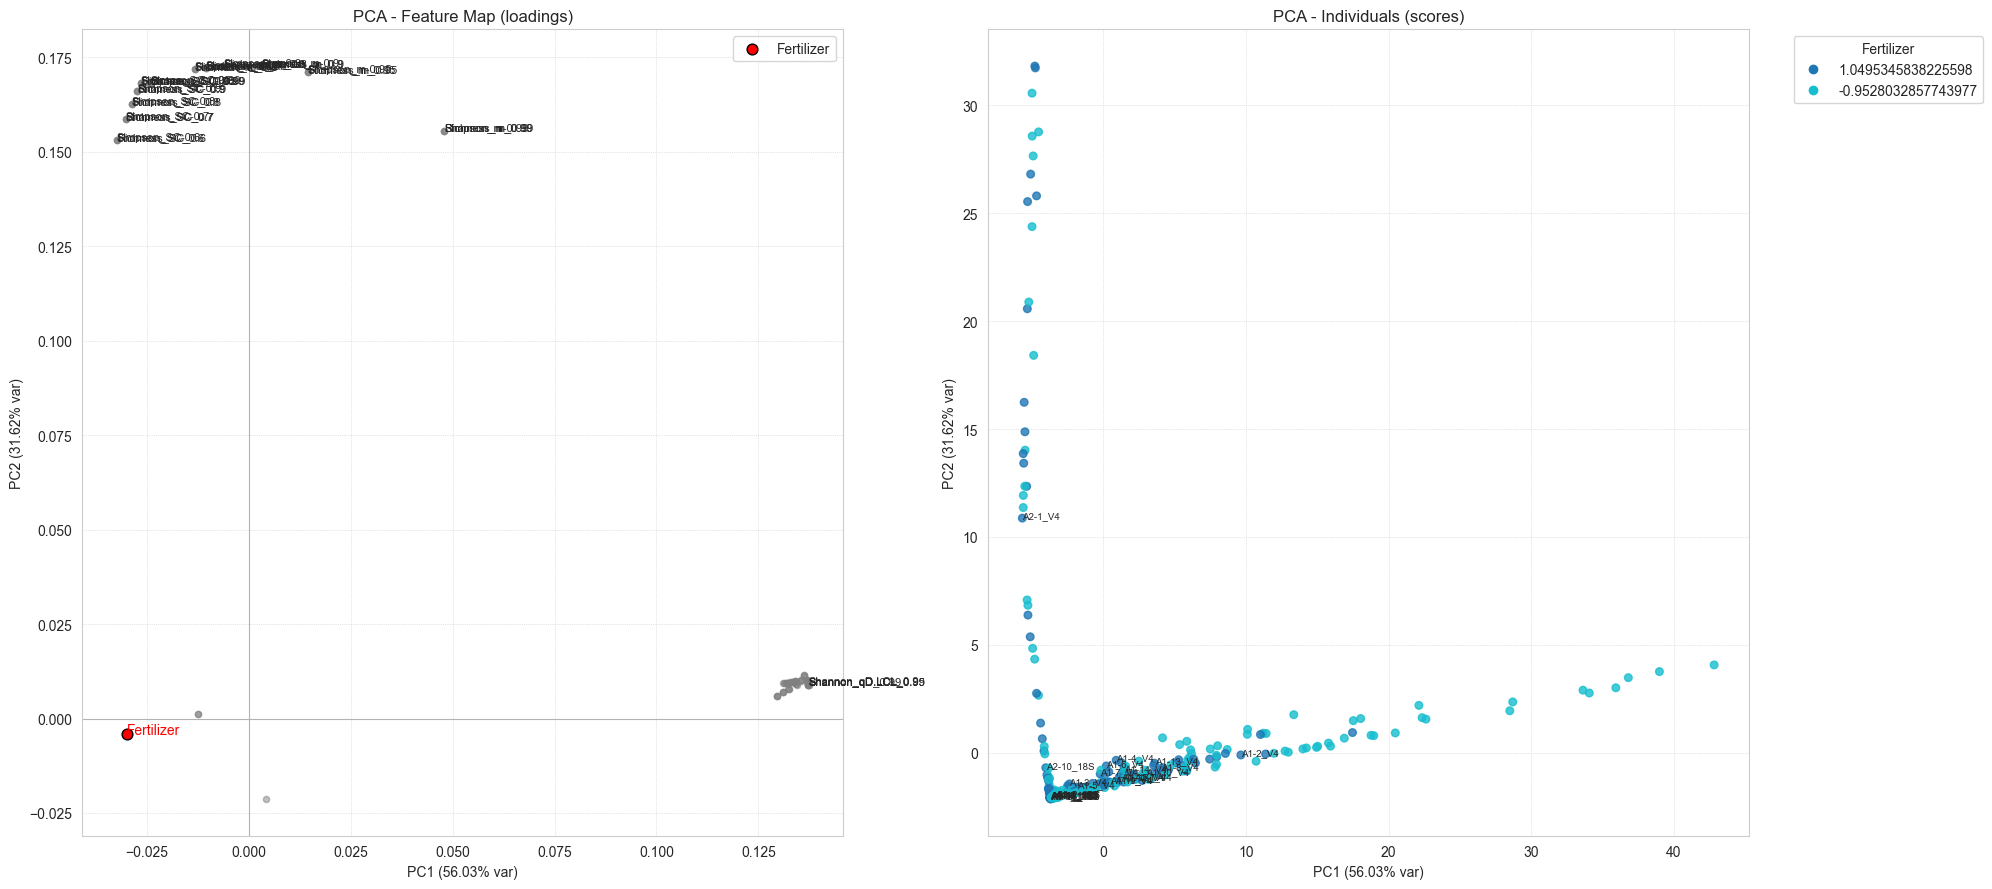


PCA explained variance (first components):

    PC  ExplainedVarianceRatio  ExplainedVariancePct  CumulativePct
0  PC1                  0.5603               56.0344        56.0344
1  PC2                  0.3162               31.6182        87.6526
2  PC3                  0.0472                4.7237        92.3763
3  PC4                  0.0260                2.6017        94.9779
4  PC5                  0.0216                2.1593        97.1372
5  PC6                  0.0103                1.0303        98.1675
6  PC7                  0.0074                0.7370        98.9045


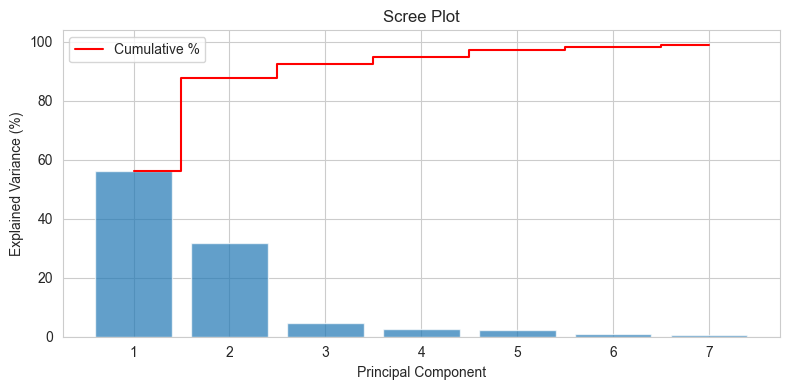

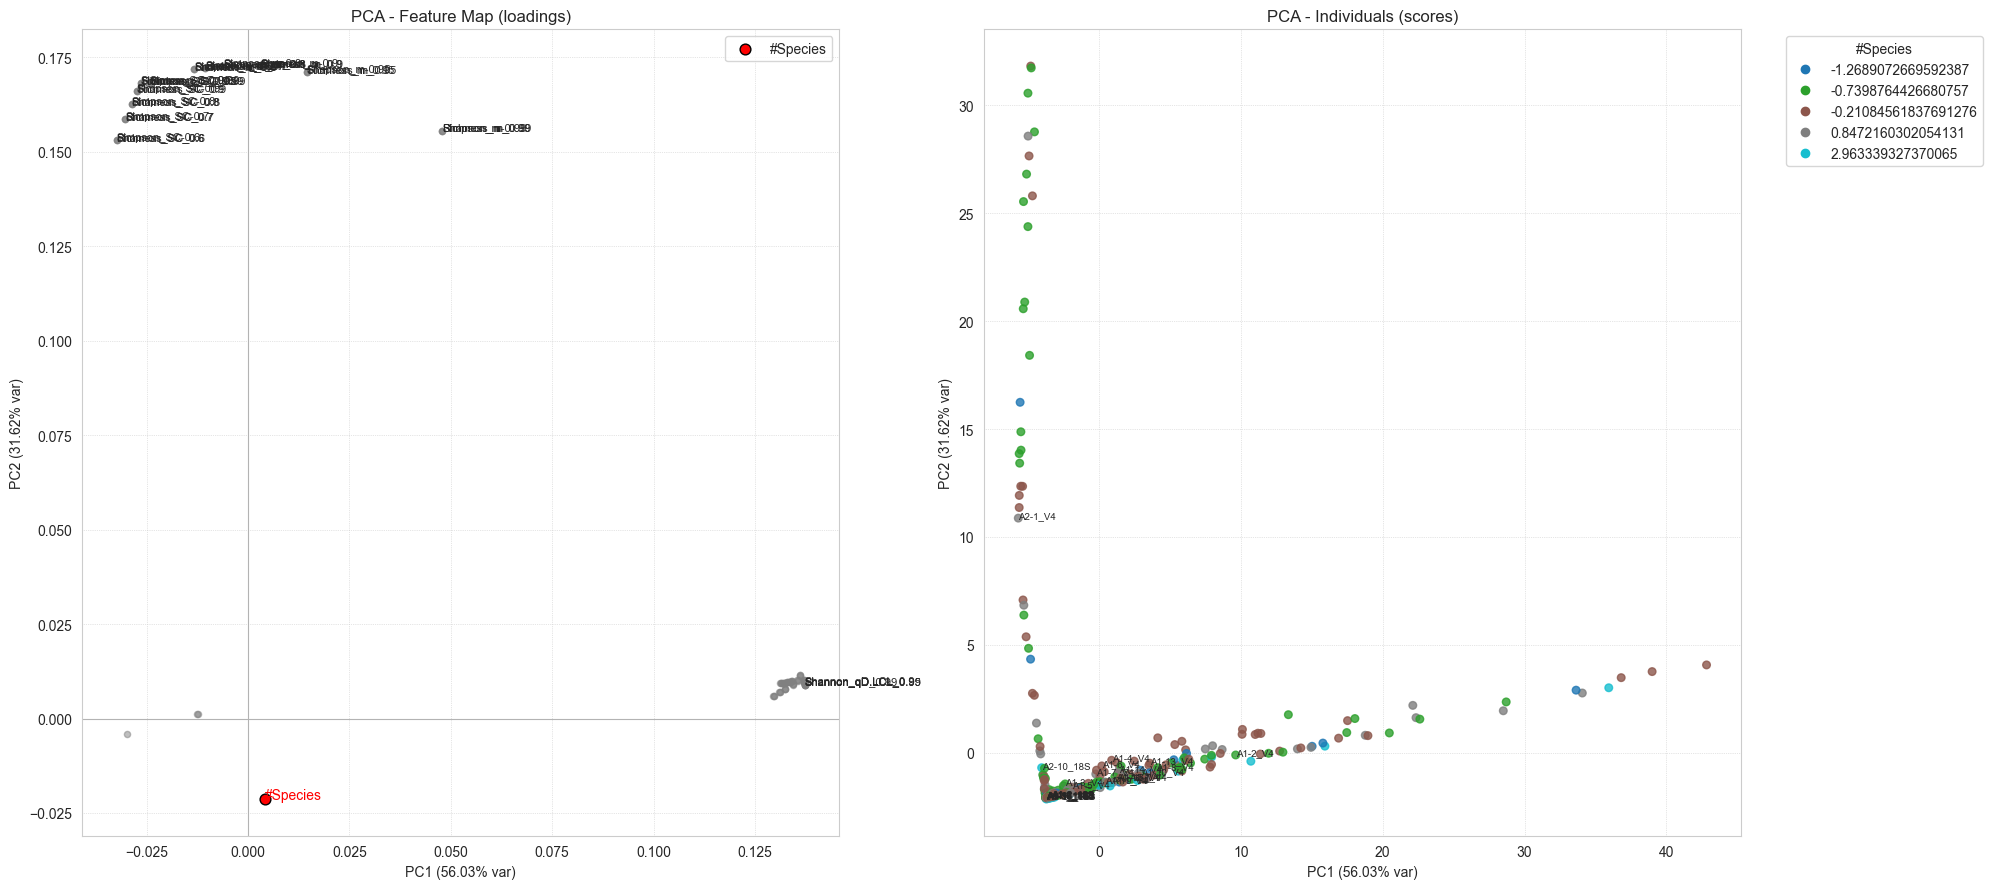

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



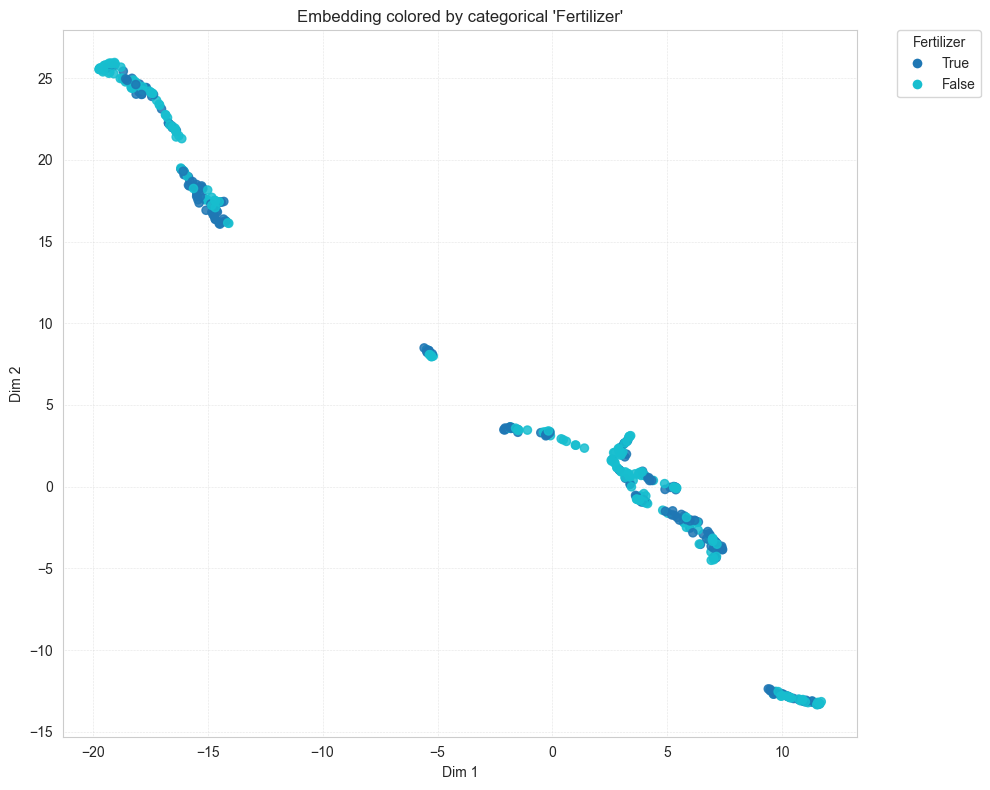

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



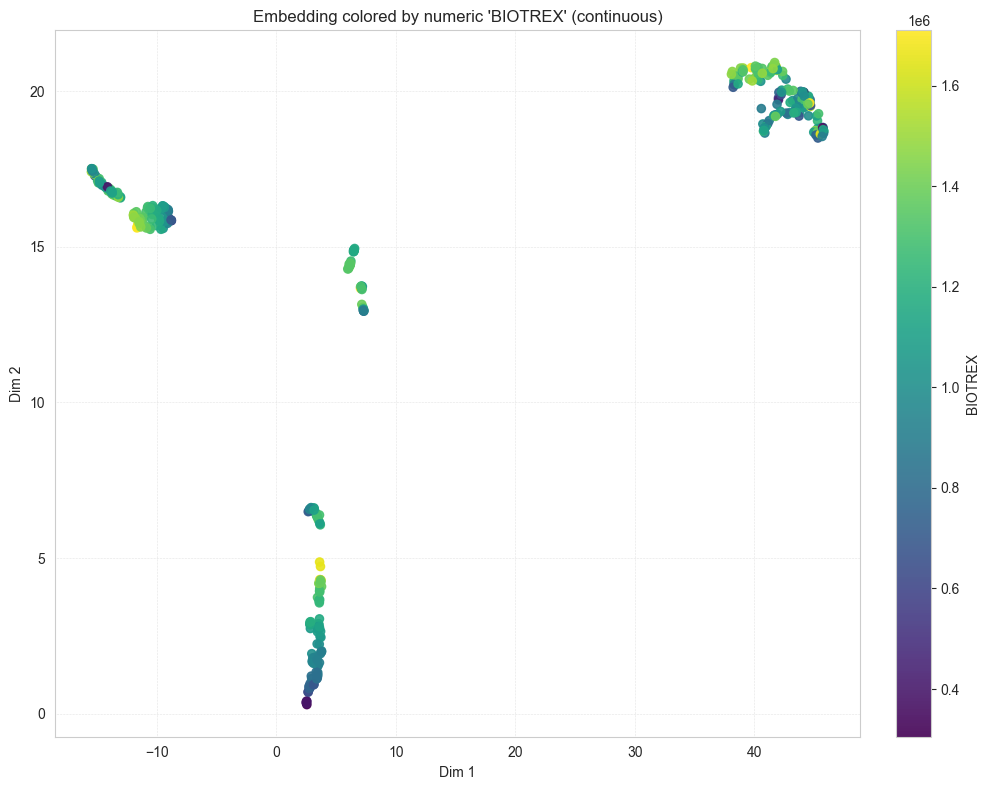

/opt/anaconda3/envs/mesocosm/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



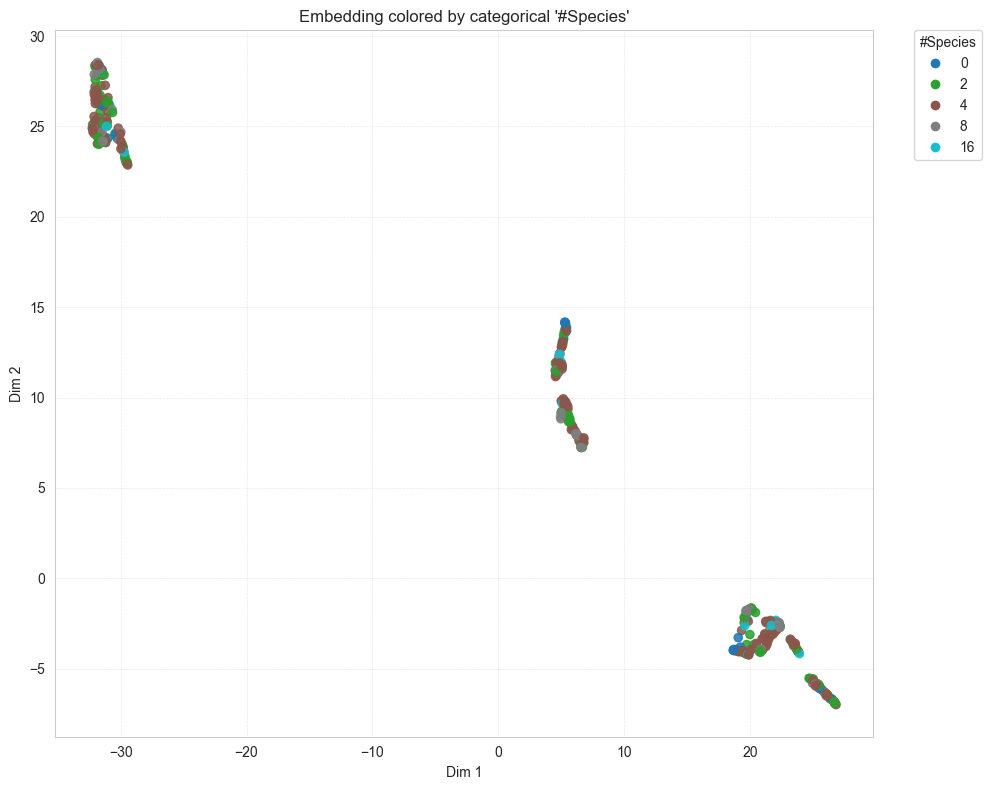

In [48]:
features_of_interest = SHANNON_COL + RICHNESS_COL + SIMPSON_COL + BIOTREX_FEATURES + ["Fertilizer", "#Species"]

Correlation_heat_map(
    df=metagenome_mesocosm_df[features_of_interest].copy()
)

PCA_analysis(
    df=metagenome_mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

PCA_analysis(
    df=metagenome_mesocosm_df[features_of_interest].copy(),
    target_color_col="#Species"
)

UMAP_representation(
    df=metagenome_mesocosm_df[features_of_interest].copy(),
    target_color_col="Fertilizer"
)

UMAP_representation(
    df=metagenome_mesocosm_df[features_of_interest].copy(),
    target_color_col="BIOTREX"
)

UMAP_representation(
    df=metagenome_mesocosm_df[features_of_interest].copy(),
    target_color_col="#Species"
)

In [49]:
df = metagenome_mesocosm_df.copy()

# helper: list all diversity columns for each index (Shannon/Simpson/Richness)
def gather_index_cols(prefix):
    # matches e.g. 'Shannon_qD_0.9' or 'Richness_qD_0.95'
    return [c for c in df.columns if c.startswith(prefix) and "_qD_" in c]

SH_COLS = gather_index_cols("Shannon")
SI_COLS = gather_index_cols("Simpson")
R_COLS  = gather_index_cols("Richness")

# extract coverage values present from column names (strings after last underscore)
def coverage_from_col(c):
    return c.split("_")[-1]

# convert to long
def melt_index(prefix_cols, index_name):
    sub = df[[df.columns[0]]].copy()  # placeholder to keep index aligned
    # select the qD columns
    cols = prefix_cols
    temp = df[cols].copy()
    # rename to include coverage only
    temp.columns = [coverage_from_col(c) for c in cols]
    # melt
    long = temp.reset_index().melt(id_vars="ID", var_name="coverage", value_name="qD")
    long = long.rename(columns={"ID":"ID"})
    long["index_type"] = index_name
    return long

sh_long = melt_index(SH_COLS, "Shannon")
si_long = melt_index(SI_COLS, "Simpson")
r_long  = melt_index(R_COLS,  "Richness")

diversity_long = pd.concat([sh_long, si_long, r_long], axis=0).reset_index(drop=True)

# attach metadata from original df (one row per ID): primer, BIOTREX, soil, species dummies, etc.
meta = df.drop(columns=[*SH_COLS, *SI_COLS, *R_COLS]).reset_index().rename(columns={"index":"ID"})
diversity_long = diversity_long.merge(meta, on="ID", how="left")

# add numeric coverage
diversity_long["coverage"] = diversity_long["coverage"].astype(float)


In [50]:
COV = 0.9  # change to 0.95 or 0.99 if you prefer
div_cov = diversity_long[diversity_long["coverage"] == COV].copy()

# Alternatively, compute mean across all coverages per ID and index:
div_mean = diversity_long.groupby(["ID","index_type"], as_index=False)["qD"].mean()
# merge meta
div_mean = div_mean.merge(meta, on="ID", how="left")

In [51]:
from scipy.stats import spearmanr

# pick a single index (e.g., Shannon), or loop over indices
idx = "Shannon"
div_idx = div_cov[div_cov["index_type"] == idx].set_index("ID")

# columns to test against
test_cols = BIOTREX_FEATURES + SOIL_FEATURES 

results = []
for feat in test_cols:
    if feat not in div_idx.columns: 
        continue
    x = div_idx["qD"].values
    y = div_idx[feat].values
    mask = (~np.isnan(x)) & (~np.isnan(y))
    if mask.sum() < 10:
        continue
    rho, p = spearmanr(x[mask], y[mask])
    results.append((feat, rho, p))

corr_df = pd.DataFrame(results, columns=["feature","spearman_rho","p"])
corr_df = corr_df.sort_values("spearman_rho", ascending=False)
corr_df.head(20)


feature  spearman_rho      p
4           pH__KCl___1:2.5        0.1236 0.0118
18               Mg/K　苦土加里比        0.1077 0.0284
9        MgO　交換性苦土__mg/100g        0.1030 0.0362
3           pH__H2O___1:2.5        0.0962 0.0504
14           Mg飽和度　苦土飽和度__%        0.0571 0.2460
12      CEC　塩基置換容量__me/100g        0.0513 0.2978
11                   腐植__%　        0.0175 0.7230
0             SD_of_BIOTREX       -0.0277 0.5745
1                   BIOTREX       -0.0281 0.5691
5   NH4-N　アンモニア態窒素__mg/100g       -0.0540 0.2733
6      NO3-N　硝酸態窒素__mg/100g       -0.0588 0.2329
2      EC　電気伝導率__dS/m___1:5       -0.0693 0.1594
8        CaO　交換性石灰__mg/100g       -0.0717 0.1451
7   Tr-P2O5　有効態リン酸__mg/100g       -0.0782 0.1119
13           Ca飽和度_石灰飽和度__%       -0.0825 0.0937
16                 塩基飽和度__%       -0.0905 0.0657
10       K2O　交換性加里__mg/100g       -0.0987 0.0446
17              Ca/Mg　石灰苦土比       -0.1065 0.0303
15            K飽和度　加里飽和度__%       -0.1065 0.0303

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/1438861818.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




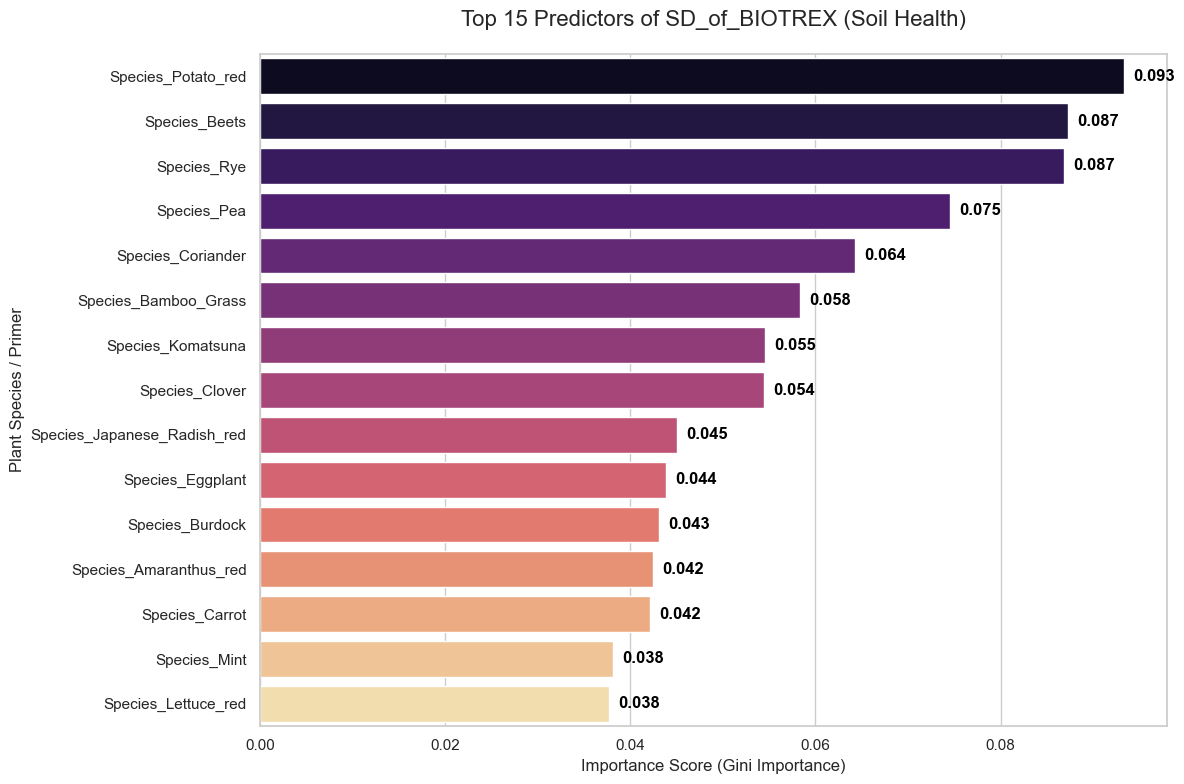

Top Species positively correlated with Biotrex:
Species_Beets          0.3153
Species_Potato_red     0.3153
Species_Clover         0.1705
Species_Bamboo_Grass   0.1705
Species_Rye            0.1702
dtype: float64


In [52]:
from sklearn.ensemble import RandomForestRegressor

# 1. Prepare the Data
# Target: We use the first feature in BIOTREX_FEATURES as the primary soil health indicator
target_variable = BIOTREX_FEATURES[0] 

# Features: We combine Species one-hot columns and Primer one-hot columns
# This allows the model to see which biological group (Primer) and which Plant (Species) 
# best explain the variance in Biotrex.
feature_columns = SPECIES_FEATURES + ["Primer_18S", "Primer_ITS1", "Primer_V4"]

# Filter out rows with missing target values to ensure a clean training set
df_clean = metagenome_mesocosm_df.dropna(subset=[target_variable])

X = df_clean[feature_columns]
y = df_clean[target_variable]

# 2. Train the Random Forest Model
# We use 500 trees for a more stable importance ranking
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X, y)

# 3. Extract and Rank Feature Importances
importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 4. Visualization
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create a horizontal bar plot for readability
plot = sns.barplot(
    data=importances.head(15), # Show top 15 predictors for clarity
    x='Importance', 
    y='Feature', 
    palette="magma"
)

# Refine labels and titles
plt.title(f"Top 15 Predictors of {target_variable} (Soil Health)", fontsize=16, pad=20)
plt.xlabel("Importance Score (Gini Importance)", fontsize=12)
plt.ylabel("Plant Species / Primer", fontsize=12)

# Add value labels to the end of each bar
for i, v in enumerate(importances.head(15)['Importance']):
    plot.text(v + 0.001, i, f"{v:.3f}", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# --- Optional: Directional Analysis ---
# Random Forest shows "importance" (how much it helps predict), but not if it's positive or negative.
# Let's calculate the correlation to see which species *increase* soil health.
correlations = X.corrwith(y).sort_values(ascending=False)
print("Top Species positively correlated with Biotrex:")
print(correlations.head(5))

/var/folders/gl/rn38q7bs2pj1hy5qqsdz25mr0000gp/T/ipykernel_79076/2322179832.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




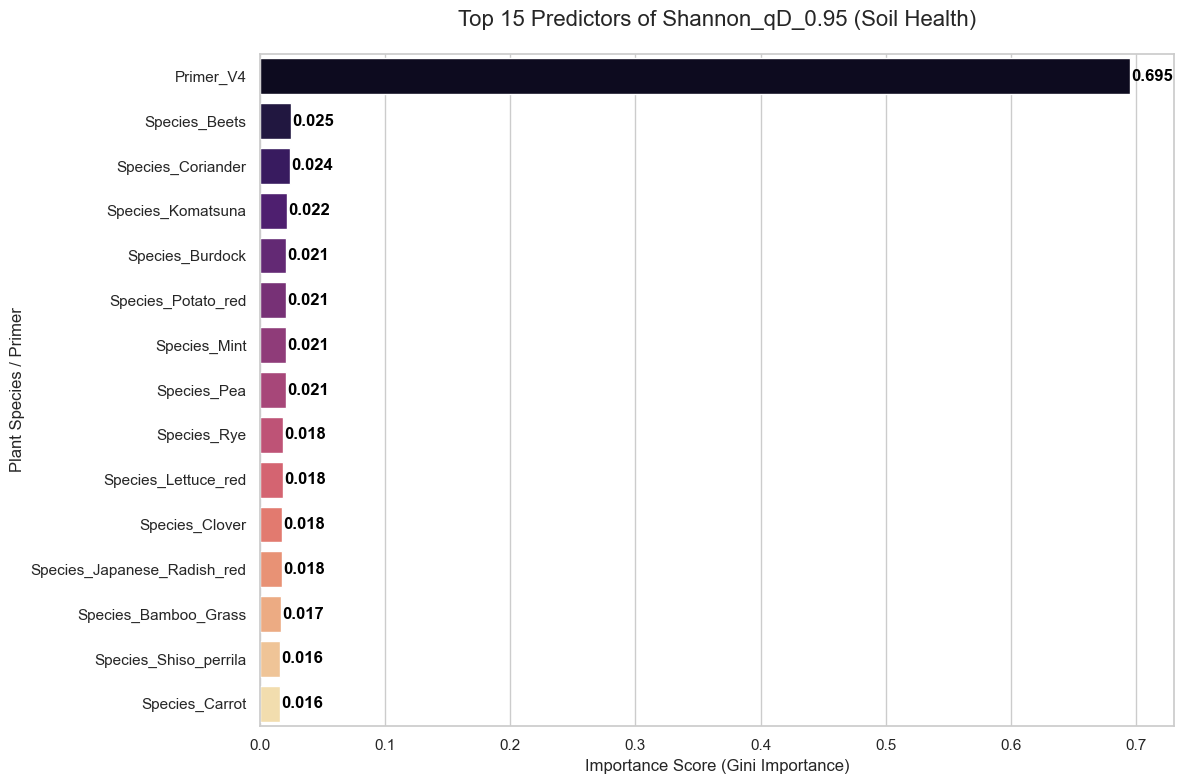

Top Species positively correlated with Biotrex:
Primer_V4               0.5793
Species_Shiso_perrila   0.0489
Species_Lettuce_red     0.0489
Species_Eggplant        0.0255
Species_Beets           0.0221
dtype: float64


In [53]:
target_variable =  'Shannon_qD_0.95'

# Features: We combine Species one-hot columns and Primer one-hot columns
# This allows the model to see which biological group (Primer) and which Plant (Species) 
# best explain the variance in Biotrex.
feature_columns = SPECIES_FEATURES + ["Primer_18S", "Primer_ITS1", "Primer_V4"]

# Filter out rows with missing target values to ensure a clean training set
df_clean = metagenome_mesocosm_df.dropna(subset=[target_variable])

X = df_clean[feature_columns]
y = df_clean[target_variable]

# 2. Train the Random Forest Model
# We use 500 trees for a more stable importance ranking
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X, y)

# 3. Extract and Rank Feature Importances
importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 4. Visualization
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create a horizontal bar plot for readability
plot = sns.barplot(
    data=importances.head(15), # Show top 15 predictors for clarity
    x='Importance', 
    y='Feature', 
    palette="magma"
)

# Refine labels and titles
plt.title(f"Top 15 Predictors of {target_variable} (Soil Health)", fontsize=16, pad=20)
plt.xlabel("Importance Score (Gini Importance)", fontsize=12)
plt.ylabel("Plant Species / Primer", fontsize=12)

# Add value labels to the end of each bar
for i, v in enumerate(importances.head(15)['Importance']):
    plot.text(v + 0.001, i, f"{v:.3f}", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig("species_importance_biotrex.png")
plt.show()

# --- Optional: Directional Analysis ---
# Random Forest shows "importance" (how much it helps predict), but not if it's positive or negative.
# Let's calculate the correlation to see which species *increase* soil health.
correlations = X.corrwith(y).sort_values(ascending=False)
print("Top Species positively correlated with Biotrex:")
print(correlations.head(5))

Here `Primer_V4` indicates that the bacterial community composition is more critical to soil richness than eukaryotes or fungi in this specific experiment.

In [54]:
df = metagenome_mesocosm_df.copy()

# helper: list all diversity columns for each index (Shannon/Simpson/Richness)
def gather_index_cols(prefix):
    # matches e.g. 'Shannon_qD_0.9' or 'Richness_qD_0.95'
    return [c for c in df.columns if c.startswith(prefix) and "_qD_" in c]

SH_COLS = gather_index_cols("Shannon")
SI_COLS = gather_index_cols("Simpson")
R_COLS  = gather_index_cols("Richness")

# extract coverage values present from column names (strings after last underscore)
def coverage_from_col(c):
    return c.split("_")[-1]

# convert to long
def melt_index(prefix_cols, index_name):
    sub = df[[df.columns[0]]].copy()  # placeholder to keep index aligned
    # select the qD columns
    cols = prefix_cols
    temp = df[cols].copy()
    # rename to include coverage only
    temp.columns = [coverage_from_col(c) for c in cols]
    # melt
    long = temp.reset_index().melt(id_vars="ID", var_name="coverage", value_name="qD")
    long = long.rename(columns={"ID":"ID"})
    long["index_type"] = index_name
    return long

sh_long = melt_index(SH_COLS, "Shannon")
si_long = melt_index(SI_COLS, "Simpson")
r_long  = melt_index(R_COLS,  "Richness")

diversity_long = pd.concat([sh_long, si_long, r_long], axis=0).reset_index(drop=True)

# attach metadata from original df (one row per ID): primer, BIOTREX, soil, species dummies, etc.
meta = df.drop(columns=[*SH_COLS, *SI_COLS, *R_COLS]).reset_index().rename(columns={"index":"ID"})
diversity_long = diversity_long.merge(meta, on="ID", how="left")

# add numeric coverage
diversity_long["coverage"] = diversity_long["coverage"].astype(float)


In [55]:
import scipy.stats as stats

species_cols = SPECIES_FEATURES  # your list of species one-hot
idx_df = div_cov[div_cov["index_type"] == "Shannon"].set_index("ID")

species_results = []
for sp in species_cols:
    if sp not in idx_df.columns: continue
    present = idx_df[idx_df[sp] == 1]["qD"].dropna()
    absent  = idx_df[idx_df[sp] == 0]["qD"].dropna()
    if len(present) < 5 or len(absent) < 5:
        continue
    stat, p = stats.mannwhitneyu(present, absent, alternative="two-sided")
    species_results.append((sp, present.median(), absent.median(), stat, p, len(present), len(absent)))

sp_df = pd.DataFrame(species_results, columns=["species","median_present","median_absent","stat","p","n_present","n_absent"])
sp_df = sp_df.sort_values("median_present", ascending=False)
sp_df.head(20)


species  median_present  median_absent       stat  \
16        Species_Shiso_perrila         11.0967         8.9951 18913.0000   
11          Species_Lettuce_red         11.0967         8.9951 18913.0000   
2                 Species_Beets         10.5363         8.9732 18095.0000   
14           Species_Potato_red         10.5363         8.9732 18095.0000   
4                Species_Carrot         10.5037         8.9951 18321.0000   
9   Species_Japanese_Radish_red         10.5037         8.9951 18321.0000   
3               Species_Burdock         10.2860         8.9401 19106.0000   
12                 Species_Mint         10.2860         8.9401 19106.0000   
10            Species_Komatsuna         10.2829         9.1133 17868.0000   
6             Species_Coriander         10.2829         9.1133 17868.0000   
0        Species_Amaranthus_red         10.0294         9.0172 18831.0000   
1          Species_Bamboo_Grass         10.0294         9.2095 18218.0000   
5                Species_Clover         10.0294         9.2095 18218.0000   
8              Species_Eggplant         10.0294         9.0172 17807.0000   
13                  Species_Pea          8.9952         9.9112 17773.0000   
15                  Species_Rye          8.9952         9.9112 17773.0000   
7               Species_Eggplan          8.6517         9.4709  2332.0000   

        p  n_present  n_absent  
16 0.3214        122       292  
11 0.3214        122       292  
2  0.9772        125       289  
14 0.9772        125       289  
4  0.5378        120       294  
9  0.5378        120       294  
3  0.3907        126       288  
12 0.3907        126       288  
10 0.9204        124       290  
6  0.9204        124       290  
0  0.3187        121       293  
1  0.8844        129       285  
5  0.8844        129       285  
8  0.2695        109       305  
13 0.7408        126       288  
15 0.7408        126       288  
7  0.8457         12       402